In [1]:
# Instalación de dependencias para Google Colab
# Solo ejecutar si está en Google Colab

import sys
import os

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Ejecutando en Google Colab - Instalando dependencias...")
    print("=" * 80)

    # Instalar Pyomo
    print("\n[1/3] Instalando Pyomo...")
    !pip install -q pyomo

    # Instalar solver GLPK
    print("[2/3] Instalando solver GLPK...")
    !apt-get install -y -qq glpk-utils

    # Instalar solver CBC (alternativo, más rápido)
    print("[3/3] Instalando solver CBC...")
    !apt-get install -y -qq coinor-cbc

    print("\n" + "=" * 80)
    print("[OK] Todas las dependencias instaladas correctamente")
    print("=" * 80)
else:
    print("[INFO] Ejecutando en entorno local")
    print("[INFO] Asegúrese de tener Pyomo y un solver (CBC/GLPK) instalados")

Ejecutando en Google Colab - Instalando dependencias...

[1/3] Instalando Pyomo...
[2/3] Instalando solver GLPK...
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-

# Optimización de Distribución de Recursos Humanitarios

**Laboratorio 5 - Problema 1**

Este notebook implementa un modelo de optimización multi-objetivo para la distribución de recursos humanitarios utilizando Pyomo.

## Configuración para Google Colab

Si está ejecutando este notebook en Google Colab, ejecute primero la siguiente celda para instalar las dependencias necesarias.

---
## 1. Importación de Librerías

In [2]:
# Pyomo para modelado de optimización
from pyomo.environ import (
    ConcreteModel, Set, Param, Var,
    NonNegativeReals, NonNegativeIntegers, Binary,
    Constraint, Objective, SolverFactory,
    maximize, value
)
from pyomo.opt import SolverStatus, TerminationCondition

# Análisis de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    # Fallback para versiones antiguas de matplotlib
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        pass  # Usar estilo por defecto

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("[INFO] Librerías importadas correctamente")

[INFO] Librerías importadas correctamente


---
## 2. Definición de Datos de Entrada

### 2.1 Recursos Disponibles

Cada recurso tiene:
- **Impacto**: Valor de impacto humanitario por tonelada
- **Peso**: Peso en toneladas por unidad
- **Volumen**: Volumen en m³ por tonelada
- **Disponibilidad**: Cantidad máxima disponible en toneladas

In [3]:
# Datos de recursos
recursos_data = {
    'Agua': {
        'impacto': 100,
        'peso_ton': 1.0,
        'volumen_m3': 1.0,
        'disponibilidad_ton': 50
    },
    'Alimentos': {
        'impacto': 90,
        'peso_ton': 1.0,
        'volumen_m3': 1.5,
        'disponibilidad_ton': 80
    },
    'Medicamentos': {
        'impacto': 120,
        'peso_ton': 1.0,
        'volumen_m3': 0.8,
        'disponibilidad_ton': 30
    },
    'Mantas': {
        'impacto': 60,
        'peso_ton': 1.0,
        'volumen_m3': 2.5,
        'disponibilidad_ton': 40
    },
    'Generadores': {
        'impacto': 85,
        'peso_ton': 1.0,
        'volumen_m3': 3.2,
        'disponibilidad_ton': 20
    },
    'Material_Construccion': {
        'impacto': 70,
        'peso_ton': 1.0,
        'volumen_m3': 0.6,
        'disponibilidad_ton': 60
    }
}

# DataFrame de recursos
df_recursos = pd.DataFrame.from_dict(recursos_data, orient='index')
df_recursos.index.name = 'Recurso'

print("=" * 80)
print("RECURSOS DISPONIBLES")
print("=" * 80)
print(df_recursos.to_string())
print(f"\nTotal de recursos: {len(df_recursos)}")

RECURSOS DISPONIBLES
                       impacto  peso_ton  volumen_m3  disponibilidad_ton
Recurso                                                                 
Agua                       100       1.0         1.0                  50
Alimentos                   90       1.0         1.5                  80
Medicamentos               120       1.0         0.8                  30
Mantas                      60       1.0         2.5                  40
Generadores                 85       1.0         3.2                  20
Material_Construccion       70       1.0         0.6                  60

Total de recursos: 6


### 2.2 Flota de Aviones

Cada avión tiene:
- **Capacidad de peso**: Máximo peso en toneladas
- **Capacidad de volumen**: Máximo volumen en m³
- **Costo fijo**: Costo de operación base
- **Costo variable**: Costo por kilómetro recorrido

In [4]:
# Datos de aviones
aviones_data = {
    'Hercules-1': {
        'capacidad_peso_ton': 28,
        'capacidad_volumen_m3': 22,
        'costo_fijo': 5000,
        'costo_variable_por_km': 8
    },
    'Hercules-2': {
        'capacidad_peso_ton': 32,
        'capacidad_volumen_m3': 26,
        'costo_fijo': 5500,
        'costo_variable_por_km': 9
    },
    'Antonov-1': {
        'capacidad_peso_ton': 24,
        'capacidad_volumen_m3': 20,
        'costo_fijo': 4500,
        'costo_variable_por_km': 7
    },
    'Antonov-2': {
        'capacidad_peso_ton': 26,
        'capacidad_volumen_m3': 24,
        'costo_fijo': 4800,
        'costo_variable_por_km': 7.5
    },
    'Galaxy-1': {
        'capacidad_peso_ton': 40,
        'capacidad_volumen_m3': 35,
        'costo_fijo': 8000,
        'costo_variable_por_km': 12
    }
}

# DataFrame de aviones
df_aviones = pd.DataFrame.from_dict(aviones_data, orient='index')
df_aviones.index.name = 'Avión'

print("=" * 80)
print("FLOTA DE AVIONES DISPONIBLES")
print("=" * 80)
print(df_aviones.to_string())
print(f"\nTotal de aviones: {len(df_aviones)}")

FLOTA DE AVIONES DISPONIBLES
            capacidad_peso_ton  capacidad_volumen_m3  costo_fijo  costo_variable_por_km
Avión                                                                                  
Hercules-1                  28                    22        5000                    8.0
Hercules-2                  32                    26        5500                    9.0
Antonov-1                   24                    20        4500                    7.0
Antonov-2                   26                    24        4800                    7.5
Galaxy-1                    40                    35        8000                   12.0

Total de aviones: 5


### 2.3 Zonas Afectadas

Cada zona tiene:
- **Distancia**: Distancia desde el centro de distribución en km
- **Población**: Número de personas afectadas
- **Multiplicador de impacto**: Factor que ajusta el impacto de los recursos según urgencia

In [5]:
# Datos de zonas afectadas
zonas_data = {
    'Zona_A': {
        'distancia_km': 150,
        'poblacion': 5000,
        'multiplicador_impacto': 1.2  # Alta urgencia
    },
    'Zona_B': {
        'distancia_km': 280,
        'poblacion': 8000,
        'multiplicador_impacto': 1.5  # Muy alta urgencia
    },
    'Zona_C': {
        'distancia_km': 420,
        'poblacion': 3500,
        'multiplicador_impacto': 1.0  # Urgencia normal
    },
    'Zona_D': {
        'distancia_km': 200,
        'poblacion': 6000,
        'multiplicador_impacto': 1.3  # Alta urgencia
    }
}

# DataFrame de zonas
df_zonas = pd.DataFrame.from_dict(zonas_data, orient='index')
df_zonas.index.name = 'Zona'

print("=" * 80)
print("ZONAS AFECTADAS")
print("=" * 80)
print(df_zonas.to_string())
print(f"\nTotal de zonas: {len(df_zonas)}")
print(f"Población total afectada: {df_zonas['poblacion'].sum():,} personas")

ZONAS AFECTADAS
        distancia_km  poblacion  multiplicador_impacto
Zona                                                  
Zona_A           150       5000                    1.2
Zona_B           280       8000                    1.5
Zona_C           420       3500                    1.0
Zona_D           200       6000                    1.3

Total de zonas: 4
Población total afectada: 22,500 personas


### 2.4 Requerimientos Mínimos por Zona

Cada zona requiere una cantidad mínima (en toneladas) de cada tipo de recurso para satisfacer las necesidades básicas de la población.

In [6]:
# Requerimientos mínimos en toneladas por zona y recurso
requerimientos_data = {
    'Zona_A': {
        'Agua': 8,
        'Alimentos': 10,
        'Medicamentos': 3,
        'Mantas': 5,
        'Generadores': 2,
        'Material_Construccion': 6
    },
    'Zona_B': {
        'Agua': 12,
        'Alimentos': 15,
        'Medicamentos': 5,
        'Mantas': 8,
        'Generadores': 3,
        'Material_Construccion': 10
    },
    'Zona_C': {
        'Agua': 6,
        'Alimentos': 8,
        'Medicamentos': 2,
        'Mantas': 4,
        'Generadores': 1,
        'Material_Construccion': 5
    },
    'Zona_D': {
        'Agua': 10,
        'Alimentos': 12,
        'Medicamentos': 4,
        'Mantas': 6,
        'Generadores': 2,
        'Material_Construccion': 8
    }
}

# DataFrame de requerimientos
df_requerimientos = pd.DataFrame.from_dict(requerimientos_data, orient='index')
df_requerimientos.index.name = 'Zona'

print("=" * 80)
print("REQUERIMIENTOS MÍNIMOS POR ZONA (toneladas)")
print("=" * 80)
print(df_requerimientos.to_string())
print("\nTotales por recurso:")
print(df_requerimientos.sum().to_string())

REQUERIMIENTOS MÍNIMOS POR ZONA (toneladas)
        Agua  Alimentos  Medicamentos  Mantas  Generadores  Material_Construccion
Zona                                                                             
Zona_A     8         10             3       5            2                      6
Zona_B    12         15             5       8            3                     10
Zona_C     6          8             2       4            1                      5
Zona_D    10         12             4       6            2                      8

Totales por recurso:
Agua                     36
Alimentos                45
Medicamentos             14
Mantas                   23
Generadores               8
Material_Construccion    29


---
## 3. Resumen de Datos y Validación

Verificamos que los datos sean consistentes y factibles antes de construir el modelo.

In [7]:
# Verificación de factibilidad básica
print("=" * 80)
print("VALIDACIÓN DE DATOS")
print("=" * 80)

# Verificar disponibilidad vs requerimientos totales
print("\n1. Disponibilidad vs Requerimientos Totales:")
print("-" * 80)
requerimientos_totales = df_requerimientos.sum()
comparacion = pd.DataFrame({
    'Disponibilidad': df_recursos['disponibilidad_ton'],
    'Requerido': requerimientos_totales,
    'Diferencia': df_recursos['disponibilidad_ton'] - requerimientos_totales,
    'Factible': df_recursos['disponibilidad_ton'] >= requerimientos_totales
})
print(comparacion.to_string())

# Capacidad total de la flota
print("\n2. Capacidad Total de la Flota:")
print("-" * 80)
capacidad_total_peso = df_aviones['capacidad_peso_ton'].sum()
capacidad_total_volumen = df_aviones['capacidad_volumen_m3'].sum()
print(f"Capacidad total de peso: {capacidad_total_peso:.2f} toneladas")
print(f"Capacidad total de volumen: {capacidad_total_volumen:.2f} m³")
print(f"Peso total requerido: {requerimientos_totales.sum():.2f} toneladas")

# Estadísticas de zonas
print("\n3. Estadísticas de Zonas:")
print("-" * 80)
print(f"Distancia mínima: {df_zonas['distancia_km'].min()} km")
print(f"Distancia máxima: {df_zonas['distancia_km'].max()} km")
print(f"Distancia promedio: {df_zonas['distancia_km'].mean():.2f} km")
print(f"Urgencia máxima (multiplicador): {df_zonas['multiplicador_impacto'].max()}")

print("\n" + "=" * 80)
print("[OK] Validación completada")
print("=" * 80)

VALIDACIÓN DE DATOS

1. Disponibilidad vs Requerimientos Totales:
--------------------------------------------------------------------------------
                       Disponibilidad  Requerido  Diferencia  Factible
Agua                               50         36          14      True
Alimentos                          80         45          35      True
Medicamentos                       30         14          16      True
Mantas                             40         23          17      True
Generadores                        20          8          12      True
Material_Construccion              60         29          31      True

2. Capacidad Total de la Flota:
--------------------------------------------------------------------------------
Capacidad total de peso: 150.00 toneladas
Capacidad total de volumen: 127.00 m³
Peso total requerido: 155.00 toneladas

3. Estadísticas de Zonas:
--------------------------------------------------------------------------------
Distancia mínim

---
## 4. Visualización Exploratoria de Datos

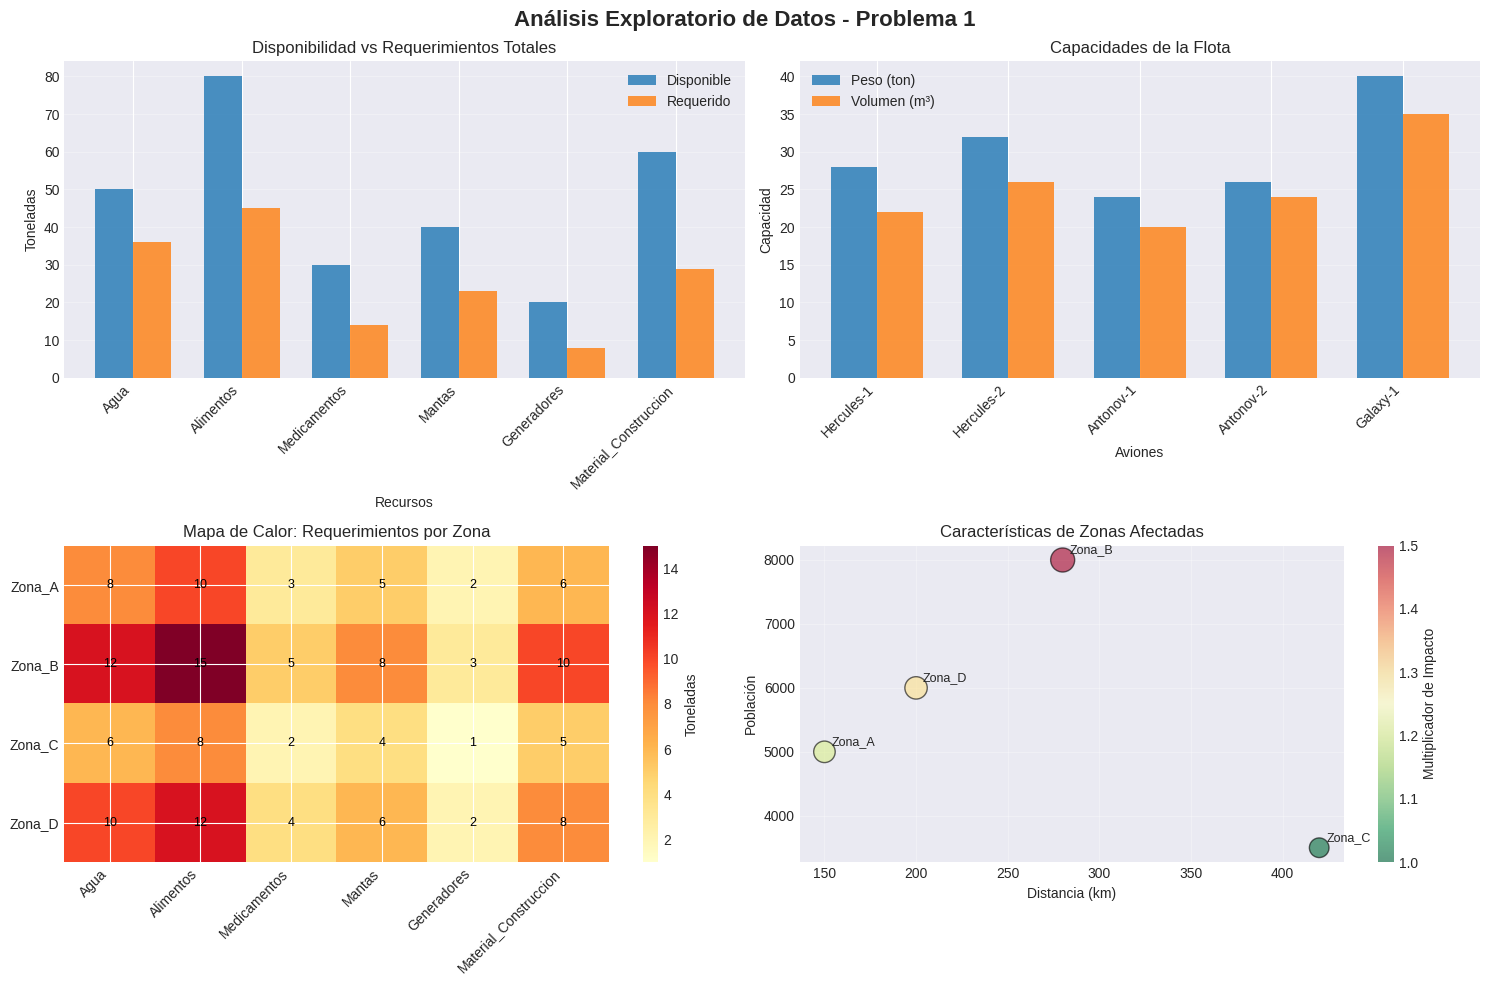

[OK] Visualización completada


In [8]:
# Crear figura con múltiples subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análisis Exploratorio de Datos - Problema 1', fontsize=16, fontweight='bold')

# 1. Disponibilidad vs Requerimientos
ax1 = axes[0, 0]
x_pos = np.arange(len(comparacion))
width = 0.35
ax1.bar(x_pos - width/2, comparacion['Disponibilidad'], width, label='Disponible', alpha=0.8)
ax1.bar(x_pos + width/2, comparacion['Requerido'], width, label='Requerido', alpha=0.8)
ax1.set_xlabel('Recursos')
ax1.set_ylabel('Toneladas')
ax1.set_title('Disponibilidad vs Requerimientos Totales')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparacion.index, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Capacidad de aviones
ax2 = axes[0, 1]
x_pos = np.arange(len(df_aviones))
ax2.bar(x_pos - width/2, df_aviones['capacidad_peso_ton'], width, label='Peso (ton)', alpha=0.8)
ax2.bar(x_pos + width/2, df_aviones['capacidad_volumen_m3'], width, label='Volumen (m³)', alpha=0.8)
ax2.set_xlabel('Aviones')
ax2.set_ylabel('Capacidad')
ax2.set_title('Capacidades de la Flota')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(df_aviones.index, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Mapa de requerimientos por zona
ax3 = axes[1, 0]
im = ax3.imshow(df_requerimientos.values, aspect='auto', cmap='YlOrRd')
ax3.set_xticks(np.arange(len(df_requerimientos.columns)))
ax3.set_yticks(np.arange(len(df_requerimientos.index)))
ax3.set_xticklabels(df_requerimientos.columns, rotation=45, ha='right')
ax3.set_yticklabels(df_requerimientos.index)
ax3.set_title('Mapa de Calor: Requerimientos por Zona')
plt.colorbar(im, ax=ax3, label='Toneladas')

# Añadir valores en el mapa de calor
for i in range(len(df_requerimientos.index)):
    for j in range(len(df_requerimientos.columns)):
        text = ax3.text(j, i, df_requerimientos.values[i, j],
                       ha="center", va="center", color="black", fontsize=9)

# 4. Características de zonas
ax4 = axes[1, 1]
scatter = ax4.scatter(df_zonas['distancia_km'], df_zonas['poblacion'],
                     s=df_zonas['multiplicador_impacto']*200,
                     c=df_zonas['multiplicador_impacto'],
                     cmap='RdYlGn_r', alpha=0.6, edgecolors='black')
ax4.set_xlabel('Distancia (km)')
ax4.set_ylabel('Población')
ax4.set_title('Características de Zonas Afectadas')
ax4.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Multiplicador de Impacto')

# Añadir etiquetas de zona
for idx, row in df_zonas.iterrows():
    ax4.annotate(idx, (row['distancia_km'], row['poblacion']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

print("[OK] Visualización completada")

---
## 5. Preparación de Estructuras para el Modelo

Convertimos los DataFrames en diccionarios y conjuntos para facilitar la construcción del modelo Pyomo.

In [9]:
# Conjuntos
RECURSOS = list(df_recursos.index)
AVIONES = list(df_aviones.index)
ZONAS = list(df_zonas.index)

print("Conjuntos definidos:")
print(f"  - Recursos (R): {RECURSOS}")
print(f"  - Aviones (A): {AVIONES}")
print(f"  - Zonas (Z): {ZONAS}")
print(f"\nCardinalidad: |R|={len(RECURSOS)}, |A|={len(AVIONES)}, |Z|={len(ZONAS)}")

Conjuntos definidos:
  - Recursos (R): ['Agua', 'Alimentos', 'Medicamentos', 'Mantas', 'Generadores', 'Material_Construccion']
  - Aviones (A): ['Hercules-1', 'Hercules-2', 'Antonov-1', 'Antonov-2', 'Galaxy-1']
  - Zonas (Z): ['Zona_A', 'Zona_B', 'Zona_C', 'Zona_D']

Cardinalidad: |R|=6, |A|=5, |Z|=4


In [10]:
# Parámetros de recursos (diccionarios indexados)
impacto = df_recursos['impacto'].to_dict()
peso_recurso = df_recursos['peso_ton'].to_dict()
volumen_recurso = df_recursos['volumen_m3'].to_dict()
disponibilidad = df_recursos['disponibilidad_ton'].to_dict()

print("Parámetros de recursos:")
print(f"  - Impacto: {impacto}")
print(f"  - Disponibilidad: {disponibilidad}")

Parámetros de recursos:
  - Impacto: {'Agua': 100, 'Alimentos': 90, 'Medicamentos': 120, 'Mantas': 60, 'Generadores': 85, 'Material_Construccion': 70}
  - Disponibilidad: {'Agua': 50, 'Alimentos': 80, 'Medicamentos': 30, 'Mantas': 40, 'Generadores': 20, 'Material_Construccion': 60}


In [11]:
# Parámetros de aviones (diccionarios indexados)
capacidad_peso = df_aviones['capacidad_peso_ton'].to_dict()
capacidad_volumen = df_aviones['capacidad_volumen_m3'].to_dict()
costo_fijo = df_aviones['costo_fijo'].to_dict()
costo_variable = df_aviones['costo_variable_por_km'].to_dict()

print("Parámetros de aviones:")
print(f"  - Capacidad peso: {capacidad_peso}")
print(f"  - Capacidad volumen: {capacidad_volumen}")
print(f"  - Costo fijo: {costo_fijo}")
print(f"  - Costo variable/km: {costo_variable}")

Parámetros de aviones:
  - Capacidad peso: {'Hercules-1': 28, 'Hercules-2': 32, 'Antonov-1': 24, 'Antonov-2': 26, 'Galaxy-1': 40}
  - Capacidad volumen: {'Hercules-1': 22, 'Hercules-2': 26, 'Antonov-1': 20, 'Antonov-2': 24, 'Galaxy-1': 35}
  - Costo fijo: {'Hercules-1': 5000, 'Hercules-2': 5500, 'Antonov-1': 4500, 'Antonov-2': 4800, 'Galaxy-1': 8000}
  - Costo variable/km: {'Hercules-1': 8.0, 'Hercules-2': 9.0, 'Antonov-1': 7.0, 'Antonov-2': 7.5, 'Galaxy-1': 12.0}


In [12]:
# Parámetros de zonas (diccionarios indexados)
distancia = df_zonas['distancia_km'].to_dict()
poblacion = df_zonas['poblacion'].to_dict()
multiplicador_impacto = df_zonas['multiplicador_impacto'].to_dict()

print("Parámetros de zonas:")
print(f"  - Distancia: {distancia}")
print(f"  - Población: {poblacion}")
print(f"  - Multiplicador impacto: {multiplicador_impacto}")

Parámetros de zonas:
  - Distancia: {'Zona_A': 150, 'Zona_B': 280, 'Zona_C': 420, 'Zona_D': 200}
  - Población: {'Zona_A': 5000, 'Zona_B': 8000, 'Zona_C': 3500, 'Zona_D': 6000}
  - Multiplicador impacto: {'Zona_A': 1.2, 'Zona_B': 1.5, 'Zona_C': 1.0, 'Zona_D': 1.3}


In [13]:
# Requerimientos mínimos (diccionario de 2 dimensiones)
requerimiento_minimo = {}
for zona in ZONAS:
    for recurso in RECURSOS:
        requerimiento_minimo[(zona, recurso)] = df_requerimientos.loc[zona, recurso]

print("Requerimientos mínimos (muestra):")
for key in list(requerimiento_minimo.keys())[:10]:
    print(f"  - {key}: {requerimiento_minimo[key]} ton")
print(f"  ... ({len(requerimiento_minimo)} combinaciones zona-recurso)")

Requerimientos mínimos (muestra):
  - ('Zona_A', 'Agua'): 8 ton
  - ('Zona_A', 'Alimentos'): 10 ton
  - ('Zona_A', 'Medicamentos'): 3 ton
  - ('Zona_A', 'Mantas'): 5 ton
  - ('Zona_A', 'Generadores'): 2 ton
  - ('Zona_A', 'Material_Construccion'): 6 ton
  - ('Zona_B', 'Agua'): 12 ton
  - ('Zona_B', 'Alimentos'): 15 ton
  - ('Zona_B', 'Medicamentos'): 5 ton
  - ('Zona_B', 'Mantas'): 8 ton
  ... (24 combinaciones zona-recurso)


---
## 6. Resumen de Estructuras de Datos

Todas las estructuras de datos están listas para ser utilizadas en el modelo de optimización.

In [14]:
print("=" * 80)
print("RESUMEN DE ESTRUCTURAS DE DATOS PREPARADAS")
print("=" * 80)

print("\nCONJUNTOS:")
print(f"  • RECURSOS: {len(RECURSOS)} elementos")
print(f"  • AVIONES: {len(AVIONES)} elementos")
print(f"  • ZONAS: {len(ZONAS)} elementos")

print("\nPARÁMETROS UNIDIMENSIONALES:")
print(f"  • Impacto por recurso (impacto)")
print(f"  • Peso por recurso (peso_recurso)")
print(f"  • Volumen por recurso (volumen_recurso)")
print(f"  • Disponibilidad por recurso (disponibilidad)")
print(f"  • Capacidad de peso por avión (capacidad_peso)")
print(f"  • Capacidad de volumen por avión (capacidad_volumen)")
print(f"  • Costo fijo por avión (costo_fijo)")
print(f"  • Costo variable por avión (costo_variable)")
print(f"  • Distancia por zona (distancia)")
print(f"  • Población por zona (poblacion)")
print(f"  • Multiplicador de impacto por zona (multiplicador_impacto)")

print("\nPARÁMETROS BIDIMENSIONALES:")
print(f"  • Requerimientos mínimos (zona, recurso): {len(requerimiento_minimo)} combinaciones")

print("\n" + "=" * 80)
print("[OK] Datos listos para construir el modelo de optimización")
print("=" * 80)

RESUMEN DE ESTRUCTURAS DE DATOS PREPARADAS

CONJUNTOS:
  • RECURSOS: 6 elementos
  • AVIONES: 5 elementos
  • ZONAS: 4 elementos

PARÁMETROS UNIDIMENSIONALES:
  • Impacto por recurso (impacto)
  • Peso por recurso (peso_recurso)
  • Volumen por recurso (volumen_recurso)
  • Disponibilidad por recurso (disponibilidad)
  • Capacidad de peso por avión (capacidad_peso)
  • Capacidad de volumen por avión (capacidad_volumen)
  • Costo fijo por avión (costo_fijo)
  • Costo variable por avión (costo_variable)
  • Distancia por zona (distancia)
  • Población por zona (poblacion)
  • Multiplicador de impacto por zona (multiplicador_impacto)

PARÁMETROS BIDIMENSIONALES:
  • Requerimientos mínimos (zona, recurso): 24 combinaciones

[OK] Datos listos para construir el modelo de optimización


---
## 7. Construcción del Modelo de Optimización

### 7.1 Creación del Modelo Pyomo

Construiremos un modelo de optimización que maximiza el impacto humanitario total considerando:
- Múltiples recursos que deben distribuirse
- Flota de aviones con capacidades limitadas
- Cada avión puede realizar hasta 2 viajes
- Zonas con requerimientos mínimos específicos
- Costos de operación (fijos y variables según distancia)

In [15]:
# Crear el modelo concreto
model = ConcreteModel(name="Distribucion_Humanitaria_Multizona")

print("=" * 80)
print("MODELO DE OPTIMIZACIÓN: DISTRIBUCIÓN HUMANITARIA CON MÚLTIPLES ZONAS")
print("=" * 80)
print("\n[OK] Modelo creado exitosamente")
print(f"  Nombre: {model.name}")

MODELO DE OPTIMIZACIÓN: DISTRIBUCIÓN HUMANITARIA CON MÚLTIPLES ZONAS

[OK] Modelo creado exitosamente
  Nombre: Distribucion_Humanitaria_Multizona


### 7.2 Definición de Conjuntos (Sets)

Los conjuntos definen los índices sobre los cuales operan las variables y restricciones:

- **R**: Recursos disponibles para transportar
- **J**: Aviones en la flota
- **V**: Viajes posibles por avión (1 o 2)
- **Z**: Zonas afectadas que deben ser atendidas

In [16]:
# Definir conjuntos del modelo
model.R = Set(initialize=RECURSOS, doc='Recursos humanitarios')
model.J = Set(initialize=AVIONES, doc='Aviones disponibles')
model.V = Set(initialize=[1, 2], doc='Viajes por avión (máximo 2)')
model.Z = Set(initialize=ZONAS, doc='Zonas afectadas')

print("\n" + "=" * 80)
print("CONJUNTOS DEFINIDOS")
print("=" * 80)
print(f"\n1. Recursos (R):")
print(f"   Cardinalidad: |R| = {len(model.R)}")
print(f"   Elementos: {list(model.R)}")

print(f"\n2. Aviones (J):")
print(f"   Cardinalidad: |J| = {len(model.J)}")
print(f"   Elementos: {list(model.J)}")

print(f"\n3. Viajes (V):")
print(f"   Cardinalidad: |V| = {len(model.V)}")
print(f"   Elementos: {list(model.V)}")
print(f"   Nota: Cada avión puede realizar hasta 2 viajes")

print(f"\n4. Zonas (Z):")
print(f"   Cardinalidad: |Z| = {len(model.Z)}")
print(f"   Elementos: {list(model.Z)}")

print(f"\nDimensión del problema:")
print(f"   Variables x[r,j,v,z]: {len(model.R)} × {len(model.J)} × {len(model.V)} × {len(model.Z)} = {len(model.R) * len(model.J) * len(model.V) * len(model.Z)} combinaciones")
print("=" * 80)


CONJUNTOS DEFINIDOS

1. Recursos (R):
   Cardinalidad: |R| = 6
   Elementos: ['Agua', 'Alimentos', 'Medicamentos', 'Mantas', 'Generadores', 'Material_Construccion']

2. Aviones (J):
   Cardinalidad: |J| = 5
   Elementos: ['Hercules-1', 'Hercules-2', 'Antonov-1', 'Antonov-2', 'Galaxy-1']

3. Viajes (V):
   Cardinalidad: |V| = 2
   Elementos: [1, 2]
   Nota: Cada avión puede realizar hasta 2 viajes

4. Zonas (Z):
   Cardinalidad: |Z| = 4
   Elementos: ['Zona_A', 'Zona_B', 'Zona_C', 'Zona_D']

Dimensión del problema:
   Variables x[r,j,v,z]: 6 × 5 × 2 × 4 = 240 combinaciones


### 7.3 Definición de Parámetros

Los parámetros representan los datos de entrada del problema:

**Parámetros de Recursos:**
- `impact[r]`: Valor de impacto humanitario por tonelada del recurso r
- `weight[r]`: Peso por tonelada del recurso r
- `volume[r]`: Volumen en m³ por tonelada del recurso r
- `availability[r]`: Disponibilidad máxima en toneladas del recurso r

**Parámetros de Aviones:**
- `weight_cap[j]`: Capacidad máxima de peso (toneladas) del avión j
- `volume_cap[j]`: Capacidad máxima de volumen (m³) del avión j
- `fixed_cost[j]`: Costo fijo de operación del avión j
- `var_cost[j]`: Costo variable por kilómetro del avión j

**Parámetros de Zonas:**
- `distance[z]`: Distancia en km desde el centro de distribución a la zona z
- `population[z]`: Población afectada en la zona z
- `impact_mult[z]`: Multiplicador de impacto por urgencia en la zona z

**Parámetros de Requerimientos:**
- `min_req[z,r]`: Cantidad mínima requerida (toneladas) del recurso r en la zona z

In [17]:
# Parámetros de recursos
model.impact = Param(model.R, initialize=impacto, doc='Impacto humanitario por tonelada')
model.weight = Param(model.R, initialize=peso_recurso, doc='Peso por tonelada')
model.volume = Param(model.R, initialize=volumen_recurso, doc='Volumen por tonelada')
model.availability = Param(model.R, initialize=disponibilidad, doc='Disponibilidad máxima')

print("\n" + "=" * 80)
print("PARÁMETROS DE RECURSOS")
print("=" * 80)
print("\n{:<25} {:>10} {:>10} {:>12} {:>15}".format(
    "Recurso", "Impacto", "Peso(ton)", "Volumen(m³)", "Disponib.(ton)"))
print("-" * 80)
for r in model.R:
    print("{:<25} {:>10.1f} {:>10.1f} {:>12.1f} {:>15.1f}".format(
        r, model.impact[r], model.weight[r], model.volume[r], model.availability[r]))
print("=" * 80)


PARÁMETROS DE RECURSOS

Recurso                      Impacto  Peso(ton)  Volumen(m³)  Disponib.(ton)
--------------------------------------------------------------------------------
Agua                           100.0        1.0          1.0            50.0
Alimentos                       90.0        1.0          1.5            80.0
Medicamentos                   120.0        1.0          0.8            30.0
Mantas                          60.0        1.0          2.5            40.0
Generadores                     85.0        1.0          3.2            20.0
Material_Construccion           70.0        1.0          0.6            60.0


In [18]:
# Parámetros de aviones
model.weight_cap = Param(model.J, initialize=capacidad_peso, doc='Capacidad de peso')
model.volume_cap = Param(model.J, initialize=capacidad_volumen, doc='Capacidad de volumen')
model.fixed_cost = Param(model.J, initialize=costo_fijo, doc='Costo fijo de operación')
model.var_cost = Param(model.J, initialize=costo_variable, doc='Costo variable por km')

print("\n" + "=" * 80)
print("PARÁMETROS DE AVIONES")
print("=" * 80)
print("\n{:<15} {:>12} {:>15} {:>12} {:>15}".format(
    "Avión", "Cap.Peso(t)", "Cap.Volumen(m³)", "Costo Fijo", "Costo/km"))
print("-" * 80)
for j in model.J:
    print("{:<15} {:>12.1f} {:>15.1f} {:>12.0f} {:>15.1f}".format(
        j, model.weight_cap[j], model.volume_cap[j],
        model.fixed_cost[j], model.var_cost[j]))
print("=" * 80)


PARÁMETROS DE AVIONES

Avión            Cap.Peso(t) Cap.Volumen(m³)   Costo Fijo        Costo/km
--------------------------------------------------------------------------------
Hercules-1              28.0            22.0         5000             8.0
Hercules-2              32.0            26.0         5500             9.0
Antonov-1               24.0            20.0         4500             7.0
Antonov-2               26.0            24.0         4800             7.5
Galaxy-1                40.0            35.0         8000            12.0


In [19]:
# Parámetros de zonas
model.distance = Param(model.Z, initialize=distancia, doc='Distancia a cada zona')
model.population = Param(model.Z, initialize=poblacion, doc='Población afectada')
model.impact_mult = Param(model.Z, initialize=multiplicador_impacto, doc='Multiplicador de impacto por urgencia')

print("\n" + "=" * 80)
print("PARÁMETROS DE ZONAS")
print("=" * 80)
print("\n{:<12} {:>15} {:>15} {:>20}".format(
    "Zona", "Distancia(km)", "Población", "Mult. Impacto"))
print("-" * 80)
for z in model.Z:
    print("{:<12} {:>15.0f} {:>15,} {:>20.2f}".format(
        z, model.distance[z], int(model.population[z]), model.impact_mult[z]))
print("=" * 80)


PARÁMETROS DE ZONAS

Zona           Distancia(km)       Población        Mult. Impacto
--------------------------------------------------------------------------------
Zona_A                   150           5,000                 1.20
Zona_B                   280           8,000                 1.50
Zona_C                   420           3,500                 1.00
Zona_D                   200           6,000                 1.30


In [20]:
# Parámetros de requerimientos mínimos (bidimensional)
model.min_req = Param(model.Z, model.R, initialize=requerimiento_minimo,
                      doc='Requerimiento mínimo de recurso r en zona z')

print("\n" + "=" * 80)
print("PARÁMETROS DE REQUERIMIENTOS MÍNIMOS (toneladas)")
print("=" * 80)
print("\nMatriz de Requerimientos [Zona × Recurso]:")
print("-" * 80)

# Encabezados
header = "{:<12}".format("Zona")
for r in model.R:
    header += " {:>12}".format(r[:12])
print(header)
print("-" * 80)

# Datos
for z in model.Z:
    row = "{:<12}".format(z)
    for r in model.R:
        row += " {:>12.1f}".format(model.min_req[z, r])
    print(row)

print("-" * 80)
# Totales por recurso
total_row = "{:<12}".format("TOTAL")
for r in model.R:
    total = sum(model.min_req[z, r] for z in model.Z)
    total_row += " {:>12.1f}".format(total)
print(total_row)
print("=" * 80)


PARÁMETROS DE REQUERIMIENTOS MÍNIMOS (toneladas)

Matriz de Requerimientos [Zona × Recurso]:
--------------------------------------------------------------------------------
Zona                 Agua    Alimentos Medicamentos       Mantas  Generadores Material_Con
--------------------------------------------------------------------------------
Zona_A                8.0         10.0          3.0          5.0          2.0          6.0
Zona_B               12.0         15.0          5.0          8.0          3.0         10.0
Zona_C                6.0          8.0          2.0          4.0          1.0          5.0
Zona_D               10.0         12.0          4.0          6.0          2.0          8.0
--------------------------------------------------------------------------------
TOTAL                36.0         45.0         14.0         23.0          8.0         29.0


### 7.4 Definición de Variables de Decisión

Las variables de decisión representan las incógnitas que el optimizador debe determinar:

**Variables Principales:**

1. **`x[r, j, v, z]`** ∈ ℝ₊ (Continua no negativa)
   - Cantidad (en toneladas) del recurso `r` transportada por el avión `j` en el viaje `v` hacia la zona `z`
   - Variables continuas para todos los recursos **excepto** equipos médicos

2. **`x_medical[j, v, z]`** ∈ ℤ₊ (Entera no negativa)
   - Cantidad (en unidades enteras) de medicamentos transportados
   - Representa equipos médicos que no pueden dividirse

3. **`assign[j, v, z]`** ∈ {0, 1} (Binaria)
   - Vale 1 si el avión `j` en el viaje `v` es asignado a la zona `z`
   - Vale 0 en caso contrario
   - Cada combinación (avión, viaje) puede ser asignada a una sola zona

4. **`useAircraft[j]`** ∈ {0, 1} (Binaria)
   - Vale 1 si el avión `j` es utilizado (realiza al menos un viaje)
   - Vale 0 si el avión no se utiliza
   - Determina si se incurre en el costo fijo del avión

In [21]:
# Variable principal: cantidad de recurso transportado (continua para la mayoría)
# Creamos variables continuas para todos los recursos excepto medicamentos
recursos_continuos = [r for r in RECURSOS if r != 'Medicamentos']

model.x = Var(recursos_continuos, model.J, model.V, model.Z,
              domain=NonNegativeReals,
              doc='Cantidad de recurso r transportada por avión j en viaje v a zona z')

print("\n" + "=" * 80)
print("VARIABLES DE DECISIÓN - PARTE 1: CANTIDAD DE RECURSOS (CONTINUAS)")
print("=" * 80)
print(f"\nVariable: x[r, j, v, z] ∈ ℝ₊")
print(f"Dominio: No negativos reales")
print(f"Recursos con variables continuas: {len(recursos_continuos)}")
print(f"  • {recursos_continuos}")
print(f"\nDimensión total de x:")
print(f"  |R_continuo| × |J| × |V| × |Z| = {len(recursos_continuos)} × {len(model.J)} × {len(model.V)} × {len(model.Z)}")
print(f"  = {len(recursos_continuos) * len(model.J) * len(model.V) * len(model.Z)} variables continuas")
print("=" * 80)


VARIABLES DE DECISIÓN - PARTE 1: CANTIDAD DE RECURSOS (CONTINUAS)

Variable: x[r, j, v, z] ∈ ℝ₊
Dominio: No negativos reales
Recursos con variables continuas: 5
  • ['Agua', 'Alimentos', 'Mantas', 'Generadores', 'Material_Construccion']

Dimensión total de x:
  |R_continuo| × |J| × |V| × |Z| = 5 × 5 × 2 × 4
  = 200 variables continuas


In [22]:
# Variable entera para medicamentos (equipos médicos no divisibles)
model.x_medical = Var(model.J, model.V, model.Z,
                      domain=NonNegativeIntegers,
                      doc='Unidades enteras de medicamentos transportadas (no divisibles)')

print("\n" + "=" * 80)
print("VARIABLES DE DECISIÓN - PARTE 2: MEDICAMENTOS (ENTERAS)")
print("=" * 80)
print(f"\nVariable: x_medical[j, v, z] ∈ ℤ₊")
print(f"Dominio: Enteros no negativos")
print(f"Recurso: Medicamentos (equipos médicos no divisibles)")
print(f"\nDimensión total de x_medical:")
print(f"  |J| × |V| × |Z| = {len(model.J)} × {len(model.V)} × {len(model.Z)}")
print(f"  = {len(model.J) * len(model.V) * len(model.Z)} variables enteras")
print("\nNota: Los medicamentos se manejan como unidades enteras")
print("  indivisibles (equipos médicos completos)")
print("=" * 80)


VARIABLES DE DECISIÓN - PARTE 2: MEDICAMENTOS (ENTERAS)

Variable: x_medical[j, v, z] ∈ ℤ₊
Dominio: Enteros no negativos
Recurso: Medicamentos (equipos médicos no divisibles)

Dimensión total de x_medical:
  |J| × |V| × |Z| = 5 × 2 × 4
  = 40 variables enteras

Nota: Los medicamentos se manejan como unidades enteras
  indivisibles (equipos médicos completos)


In [23]:
# Variable binaria: asignación de avión-viaje a zona
model.assign = Var(model.J, model.V, model.Z,
                   domain=Binary,
                   doc='1 si avión j en viaje v va a zona z, 0 en caso contrario')

print("\n" + "=" * 80)
print("VARIABLES DE DECISIÓN - PARTE 3: ASIGNACIÓN DE VIAJES A ZONAS")
print("=" * 80)
print(f"\nVariable: assign[j, v, z] ∈ {{0, 1}}")
print(f"Dominio: Binario")
print(f"Significado:")
print(f"  • assign[j, v, z] = 1 → El avión j en su viaje v es asignado a la zona z")
print(f"  • assign[j, v, z] = 0 → El avión j en su viaje v NO va a la zona z")
print(f"\nDimensión total de assign:")
print(f"  |J| × |V| × |Z| = {len(model.J)} × {len(model.V)} × {len(model.Z)}")
print(f"  = {len(model.J) * len(model.V) * len(model.Z)} variables binarias")
print("\n✓ Restricción implícita: Cada (avión, viaje) puede ir a una sola zona")
print("=" * 80)


VARIABLES DE DECISIÓN - PARTE 3: ASIGNACIÓN DE VIAJES A ZONAS

Variable: assign[j, v, z] ∈ {0, 1}
Dominio: Binario
Significado:
  • assign[j, v, z] = 1 → El avión j en su viaje v es asignado a la zona z
  • assign[j, v, z] = 0 → El avión j en su viaje v NO va a la zona z

Dimensión total de assign:
  |J| × |V| × |Z| = 5 × 2 × 4
  = 40 variables binarias

✓ Restricción implícita: Cada (avión, viaje) puede ir a una sola zona


In [24]:
# Variable binaria: uso de avión (para costos fijos)
model.useAircraft = Var(model.J,
                        domain=Binary,
                        doc='1 si el avión j es utilizado (realiza al menos un viaje), 0 si no')

print("\n" + "=" * 80)
print("VARIABLES DE DECISIÓN - PARTE 4: USO DE AVIONES")
print("=" * 80)
print(f"\nVariable: useAircraft[j] ∈ {{0, 1}}")
print(f"Dominio: Binario")
print(f"Significado:")
print(f"  • useAircraft[j] = 1 → El avión j es utilizado (al menos un viaje)")
print(f"  • useAircraft[j] = 0 → El avión j no se utiliza")
print(f"\nDimensión total de useAircraft:")
print(f"  |J| = {len(model.J)} variables binarias")
print("\n✓ Propósito: Determinar si se incurre en el costo fijo de cada avión")
print("=" * 80)


VARIABLES DE DECISIÓN - PARTE 4: USO DE AVIONES

Variable: useAircraft[j] ∈ {0, 1}
Dominio: Binario
Significado:
  • useAircraft[j] = 1 → El avión j es utilizado (al menos un viaje)
  • useAircraft[j] = 0 → El avión j no se utiliza

Dimensión total de useAircraft:
  |J| = 5 variables binarias

✓ Propósito: Determinar si se incurre en el costo fijo de cada avión


### 7.5 Resumen del Modelo (Estructura Completa)

In [25]:
# Resumen completo del modelo
print("\n" + "=" * 80)
print("RESUMEN COMPLETO DEL MODELO DE OPTIMIZACIÓN")
print("=" * 80)

print("\n📦 CONJUNTOS:")
print(f"  • R (Recursos):              {len(model.R)} elementos")
print(f"  • J (Aviones):               {len(model.J)} elementos")
print(f"  • V (Viajes por avión):      {len(model.V)} elementos")
print(f"  • Z (Zonas):                 {len(model.Z)} elementos")

print("\n📊 PARÁMETROS:")
print(f"  Unidimensionales:")
print(f"    - Recursos:  4 parámetros × {len(model.R)} = {4 * len(model.R)} valores")
print(f"    - Aviones:   4 parámetros × {len(model.J)} = {4 * len(model.J)} valores")
print(f"    - Zonas:     3 parámetros × {len(model.Z)} = {3 * len(model.Z)} valores")
print(f"  Bidimensionales:")
print(f"    - Requerimientos: {len(model.Z)} × {len(model.R)} = {len(model.Z) * len(model.R)} valores")

# Conteo de variables
num_x_continuas = len(recursos_continuos) * len(model.J) * len(model.V) * len(model.Z)
num_x_medical = len(model.J) * len(model.V) * len(model.Z)
num_assign = len(model.J) * len(model.V) * len(model.Z)
num_use = len(model.J)

print("\n🎯 VARIABLES DE DECISIÓN:")
print(f"  • x[r,j,v,z] (continuas):      {num_x_continuas:>6} variables")
print(f"  • x_medical[j,v,z] (enteras):  {num_x_medical:>6} variables")
print(f"  • assign[j,v,z] (binarias):    {num_assign:>6} variables")
print(f"  • useAircraft[j] (binarias):   {num_use:>6} variables")
print(f"  " + "-" * 40)
print(f"  TOTAL:                         {num_x_continuas + num_x_medical + num_assign + num_use:>6} variables")

print("\n📋 COMPLEJIDAD DEL PROBLEMA:")
print(f"  • Variables continuas:         {num_x_continuas}")
print(f"  • Variables enteras:           {num_x_medical}")
print(f"  • Variables binarias:          {num_assign + num_use}")
print(f"  • Tipo de problema:            MILP (Mixed Integer Linear Programming)")

print("\n✅ ESTADO DEL MODELO:")
print(f"  • Conjuntos:       Definidos ✓")
print(f"  • Parámetros:      Definidos ✓")
print(f"  • Variables:       Definidas ✓")
print(f"  • Restricciones:   Pendientes...")
print(f"  • Función objetivo: Pendiente...")

print("\n" + "=" * 80)
print("Modelo listo para añadir restricciones y función objetivo")
print("=" * 80)


RESUMEN COMPLETO DEL MODELO DE OPTIMIZACIÓN

📦 CONJUNTOS:
  • R (Recursos):              6 elementos
  • J (Aviones):               5 elementos
  • V (Viajes por avión):      2 elementos
  • Z (Zonas):                 4 elementos

📊 PARÁMETROS:
  Unidimensionales:
    - Recursos:  4 parámetros × 6 = 24 valores
    - Aviones:   4 parámetros × 5 = 20 valores
    - Zonas:     3 parámetros × 4 = 12 valores
  Bidimensionales:
    - Requerimientos: 4 × 6 = 24 valores

🎯 VARIABLES DE DECISIÓN:
  • x[r,j,v,z] (continuas):         200 variables
  • x_medical[j,v,z] (enteras):      40 variables
  • assign[j,v,z] (binarias):        40 variables
  • useAircraft[j] (binarias):        5 variables
  ----------------------------------------
  TOTAL:                            285 variables

📋 COMPLEJIDAD DEL PROBLEMA:
  • Variables continuas:         200
  • Variables enteras:           40
  • Variables binarias:          45
  • Tipo de problema:            MILP (Mixed Integer Linear Programming)

✅ 

---
## 8. Definición de Restricciones

Las restricciones definen las limitaciones y reglas del problema que deben cumplirse en la solución óptima.

### 8.1 Restricciones de Capacidad de Peso

Cada avión tiene una capacidad máxima de peso por viaje. La suma del peso de todos los recursos transportados (incluyendo medicamentos) no debe exceder esta capacidad.

In [26]:
# Restricción 1: Capacidad de peso por avión-viaje
# ∑_r ∑_z (weight[r] * x[r,j,v,z]) + ∑_z (weight['Medicamentos'] * x_medical[j,v,z]) ≤ weight_cap[j]
def weight_capacity_rule(m, j, v):
    """
    Restricción de capacidad de peso por avión y viaje.
    El peso total transportado no puede exceder la capacidad del avión.
    """
    # Peso de recursos continuos
    weight_continuous = sum(
        m.weight[r] * m.x[r, j, v, z]
        for r in recursos_continuos
        for z in m.Z
    )
    # Peso de medicamentos (variable entera)
    weight_medical = sum(
        m.weight['Medicamentos'] * m.x_medical[j, v, z]
        for z in m.Z
    )
    return weight_continuous + weight_medical <= m.weight_cap[j]

model.weight_capacity_constraint = Constraint(
    model.J, model.V,
    rule=weight_capacity_rule,
    doc='Capacidad de peso por avión-viaje'
)

print("=" * 80)
print("RESTRICCIÓN 1: CAPACIDAD DE PESO")
print("=" * 80)
print(f"Número de restricciones: {len(model.J)} × {len(model.V)} = {len(model.J) * len(model.V)}")
print("Forma: ∑_r ∑_z (weight[r] × x[r,j,v,z]) ≤ weight_cap[j]  ∀j∈J, ∀v∈V")
print("✓ Restricción añadida al modelo")
print("=" * 80)

RESTRICCIÓN 1: CAPACIDAD DE PESO
Número de restricciones: 5 × 2 = 10
Forma: ∑_r ∑_z (weight[r] × x[r,j,v,z]) ≤ weight_cap[j]  ∀j∈J, ∀v∈V
✓ Restricción añadida al modelo


### 8.2 Restricciones de Capacidad de Volumen

Similar a la restricción de peso, cada avión tiene una capacidad máxima de volumen por viaje.

In [27]:
# Restricción 2: Capacidad de volumen por avión-viaje
# ∑_r ∑_z (volume[r] * x[r,j,v,z]) + ∑_z (volume['Medicamentos'] * x_medical[j,v,z]) ≤ volume_cap[j]
def volume_capacity_rule(m, j, v):
    """
    Restricción de capacidad de volumen por avión y viaje.
    El volumen total transportado no puede exceder la capacidad del avión.
    """
    # Volumen de recursos continuos
    volume_continuous = sum(
        m.volume[r] * m.x[r, j, v, z]
        for r in recursos_continuos
        for z in m.Z
    )
    # Volumen de medicamentos (variable entera)
    volume_medical = sum(
        m.volume['Medicamentos'] * m.x_medical[j, v, z]
        for z in m.Z
    )
    return volume_continuous + volume_medical <= m.volume_cap[j]

model.volume_capacity_constraint = Constraint(
    model.J, model.V,
    rule=volume_capacity_rule,
    doc='Capacidad de volumen por avión-viaje'
)

print("=" * 80)
print("RESTRICCIÓN 2: CAPACIDAD DE VOLUMEN")
print("=" * 80)
print(f"Número de restricciones: {len(model.J)} × {len(model.V)} = {len(model.J) * len(model.V)}")
print("Forma: ∑_r ∑_z (volume[r] × x[r,j,v,z]) ≤ volume_cap[j]  ∀j∈J, ∀v∈V")
print("✓ Restricción añadida al modelo")
print("=" * 80)

RESTRICCIÓN 2: CAPACIDAD DE VOLUMEN
Número de restricciones: 5 × 2 = 10
Forma: ∑_r ∑_z (volume[r] × x[r,j,v,z]) ≤ volume_cap[j]  ∀j∈J, ∀v∈V
✓ Restricción añadida al modelo


### 8.3 Restricciones de Demanda Mínima por Zona

Cada zona tiene requerimientos mínimos específicos de cada recurso que deben ser satisfechos.

In [28]:
# Restricción 3: Demanda mínima por zona y recurso
# Para recursos continuos: ∑_j ∑_v x[r,j,v,z] ≥ min_req[z,r]
def min_demand_continuous_rule(m, z, r):
    """
    Restricción de demanda mínima para recursos continuos.
    Cada zona debe recibir al menos la cantidad mínima requerida de cada recurso.
    """
    return sum(m.x[r, j, v, z] for j in m.J for v in m.V) >= m.min_req[z, r]

model.min_demand_continuous_constraint = Constraint(
    model.Z, recursos_continuos,
    rule=min_demand_continuous_rule,
    doc='Demanda mínima por zona para recursos continuos'
)

# Para medicamentos: ∑_j ∑_v x_medical[j,v,z] ≥ min_req[z,'Medicamentos']
def min_demand_medical_rule(m, z):
    """
    Restricción de demanda mínima para medicamentos.
    Cada zona debe recibir al menos la cantidad mínima requerida de medicamentos.
    """
    return sum(m.x_medical[j, v, z] for j in m.J for v in m.V) >= m.min_req[z, 'Medicamentos']

model.min_demand_medical_constraint = Constraint(
    model.Z,
    rule=min_demand_medical_rule,
    doc='Demanda mínima por zona para medicamentos'
)

print("=" * 80)
print("RESTRICCIÓN 3: DEMANDA MÍNIMA POR ZONA")
print("=" * 80)
print(f"Restricciones para recursos continuos: {len(model.Z)} × {len(recursos_continuos)} = {len(model.Z) * len(recursos_continuos)}")
print(f"Restricciones para medicamentos: {len(model.Z)}")
print(f"Total: {len(model.Z) * len(recursos_continuos) + len(model.Z)}")
print("Forma: ∑_j ∑_v x[r,j,v,z] ≥ min_req[z,r]  ∀z∈Z, ∀r∈R")
print("✓ Restricción añadida al modelo")
print("=" * 80)

RESTRICCIÓN 3: DEMANDA MÍNIMA POR ZONA
Restricciones para recursos continuos: 4 × 5 = 20
Restricciones para medicamentos: 4
Total: 24
Forma: ∑_j ∑_v x[r,j,v,z] ≥ min_req[z,r]  ∀z∈Z, ∀r∈R
✓ Restricción añadida al modelo


### 8.4 Restricciones de Disponibilidad de Recursos

La cantidad total transportada de cada recurso no puede exceder su disponibilidad en el inventario.

In [29]:
# Restricción 4: Disponibilidad de recursos
# Para recursos continuos: ∑_j ∑_v ∑_z x[r,j,v,z] ≤ availability[r]
def availability_continuous_rule(m, r):
    """
    Restricción de disponibilidad para recursos continuos.
    La cantidad total transportada no puede exceder el stock disponible.
    """
    return sum(m.x[r, j, v, z] for j in m.J for v in m.V for z in m.Z) <= m.availability[r]

model.availability_continuous_constraint = Constraint(
    recursos_continuos,
    rule=availability_continuous_rule,
    doc='Disponibilidad máxima de recursos continuos'
)

# Para medicamentos: ∑_j ∑_v ∑_z x_medical[j,v,z] ≤ availability['Medicamentos']
def availability_medical_rule(m):
    """
    Restricción de disponibilidad para medicamentos.
    La cantidad total transportada no puede exceder el stock disponible.
    """
    return sum(m.x_medical[j, v, z] for j in m.J for v in m.V for z in m.Z) <= m.availability['Medicamentos']

model.availability_medical_constraint = Constraint(
    rule=availability_medical_rule,
    doc='Disponibilidad máxima de medicamentos'
)

print("=" * 80)
print("RESTRICCIÓN 4: DISPONIBILIDAD DE RECURSOS")
print("=" * 80)
print(f"Restricciones para recursos continuos: {len(recursos_continuos)}")
print(f"Restricciones para medicamentos: 1")
print(f"Total: {len(recursos_continuos) + 1}")
print("Forma: ∑_j ∑_v ∑_z x[r,j,v,z] ≤ availability[r]  ∀r∈R")
print("✓ Restricción añadida al modelo")
print("=" * 80)

RESTRICCIÓN 4: DISPONIBILIDAD DE RECURSOS
Restricciones para recursos continuos: 5
Restricciones para medicamentos: 1
Total: 6
Forma: ∑_j ∑_v ∑_z x[r,j,v,z] ≤ availability[r]  ∀r∈R
✓ Restricción añadida al modelo


### 8.5 Restricción de Incompatibilidad: Medicamentos y Avión 1

Por razones de seguridad o regulación, los medicamentos no pueden ser transportados en el primer avión de la flota.

In [30]:
# Restricción 5: Medicamentos no pueden ir en el primer avión
# x_medical[j=avión_1, v, z] = 0  ∀v∈V, ∀z∈Z
primer_avion = list(model.J)[0]  # Obtenemos el primer avión de la lista

def no_medical_first_aircraft_rule(m, v, z):
    """
    Restricción de incompatibilidad: medicamentos no pueden transportarse en el primer avión.
    Por razones de seguridad o regulación.
    """
    return m.x_medical[primer_avion, v, z] == 0

model.no_medical_first_aircraft_constraint = Constraint(
    model.V, model.Z,
    rule=no_medical_first_aircraft_rule,
    doc='Medicamentos prohibidos en el primer avión'
)

print("=" * 80)
print("RESTRICCIÓN 5: MEDICAMENTOS NO PERMITIDOS EN PRIMER AVIÓN")
print("=" * 80)
print(f"Avión restringido: {primer_avion}")
print(f"Número de restricciones: {len(model.V)} × {len(model.Z)} = {len(model.V) * len(model.Z)}")
print(f"Forma: x_medical['{primer_avion}', v, z] = 0  ∀v∈V, ∀z∈Z")
print("✓ Restricción añadida al modelo")
print("=" * 80)

RESTRICCIÓN 5: MEDICAMENTOS NO PERMITIDOS EN PRIMER AVIÓN
Avión restringido: Hercules-1
Número de restricciones: 2 × 4 = 8
Forma: x_medical['Hercules-1', v, z] = 0  ∀v∈V, ∀z∈Z
✓ Restricción añadida al modelo


### 8.6 Restricción de Incompatibilidad: Generadores y Agua

Los generadores y el agua no pueden ir en el mismo viaje de avión por razones de seguridad (riesgo de corto circuito o contaminación).

In [31]:
# Restricción 6: Generadores y Agua no pueden estar en el mismo viaje
# Si hay generadores, no puede haber agua y viceversa
# Usamos variables binarias para indicar presencia
from pyomo.environ import ConstraintList

# Primero definimos variables auxiliares para indicar presencia de cada recurso
model.has_generators = Var(model.J, model.V, domain=Binary,
                           doc='1 si hay generadores en el viaje (j,v)')
model.has_water = Var(model.J, model.V, domain=Binary,
                      doc='1 si hay agua en el viaje (j,v)')

# Vincular variables auxiliares con las cantidades transportadas
# M es un número suficientemente grande
M = 1000  # Big-M para las restricciones

def link_generators_rule(m, j, v):
    """
    Vincula has_generators con la cantidad de generadores transportados.
    Si se transportan generadores, has_generators = 1.
    """
    total_generators = sum(m.x['Generadores', j, v, z] for z in m.Z)
    return total_generators <= M * m.has_generators[j, v]

model.link_generators_constraint = Constraint(
    model.J, model.V,
    rule=link_generators_rule,
    doc='Vincula presencia de generadores'
)

def link_water_rule(m, j, v):
    """
    Vincula has_water con la cantidad de agua transportada.
    Si se transporta agua, has_water = 1.
    """
    total_water = sum(m.x['Agua', j, v, z] for z in m.Z)
    return total_water <= M * m.has_water[j, v]

model.link_water_constraint = Constraint(
    model.J, model.V,
    rule=link_water_rule,
    doc='Vincula presencia de agua'
)

# Restricción de incompatibilidad: no pueden estar ambos presentes
def incompatibility_generators_water_rule(m, j, v):
    """
    Restricción de incompatibilidad entre generadores y agua.
    No pueden estar ambos en el mismo viaje.
    """
    return m.has_generators[j, v] + m.has_water[j, v] <= 1

model.incompatibility_generators_water_constraint = Constraint(
    model.J, model.V,
    rule=incompatibility_generators_water_rule,
    doc='Generadores y agua no pueden estar juntos'
)

print("=" * 80)
print("RESTRICCIÓN 6: INCOMPATIBILIDAD GENERADORES-AGUA")
print("=" * 80)
print(f"Variables auxiliares añadidas: has_generators[j,v] y has_water[j,v]")
print(f"Restricciones de vinculación: {2 * len(model.J) * len(model.V)}")
print(f"Restricciones de incompatibilidad: {len(model.J) * len(model.V)}")
print(f"Forma: has_generators[j,v] + has_water[j,v] ≤ 1  ∀j∈J, ∀v∈V")
print("✓ Restricción añadida al modelo")
print("=" * 80)

RESTRICCIÓN 6: INCOMPATIBILIDAD GENERADORES-AGUA
Variables auxiliares añadidas: has_generators[j,v] y has_water[j,v]
Restricciones de vinculación: 20
Restricciones de incompatibilidad: 10
Forma: has_generators[j,v] + has_water[j,v] ≤ 1  ∀j∈J, ∀v∈V
✓ Restricción añadida al modelo


### 8.7 Restricción de Asignación Única de Zona por Viaje

Cada combinación (avión, viaje) puede ser asignada a una sola zona. Un avión no puede visitar múltiples zonas en un mismo viaje.

In [32]:
# Restricción 7: Solo una zona por viaje
# ∑_z assign[j,v,z] = 1  ∀j∈J, ∀v∈V
def one_zone_per_trip_rule(m, j, v):
    """
    Restricción de asignación única de zona por viaje.
    Cada avión en cada viaje debe ir exactamente a una zona.
    """
    return sum(m.assign[j, v, z] for z in m.Z) == 1

model.one_zone_per_trip_constraint = Constraint(
    model.J, model.V,
    rule=one_zone_per_trip_rule,
    doc='Una sola zona por viaje'
)

print("=" * 80)
print("RESTRICCIÓN 7: UNA ZONA POR VIAJE")
print("=" * 80)
print(f"Número de restricciones: {len(model.J)} × {len(model.V)} = {len(model.J) * len(model.V)}")
print("Forma: ∑_z assign[j,v,z] = 1  ∀j∈J, ∀v∈V")
print("Significado: Cada viaje de cada avión va exactamente a una zona")
print("✓ Restricción añadida al modelo")
print("=" * 80)

RESTRICCIÓN 7: UNA ZONA POR VIAJE
Número de restricciones: 5 × 2 = 10
Forma: ∑_z assign[j,v,z] = 1  ∀j∈J, ∀v∈V
Significado: Cada viaje de cada avión va exactamente a una zona
✓ Restricción añadida al modelo


### 8.8 Restricción de Vinculación: Transporte y Asignación

Si se transporta cualquier cantidad de recurso en un viaje hacia una zona, entonces ese viaje debe estar asignado a esa zona.

In [33]:
# Restricción 9: Vincular transporte con asignación
# Si x[r,j,v,z] > 0 o x_medical[j,v,z] > 0, entonces assign[j,v,z] = 1
# Usamos Big-M: x[r,j,v,z] ≤ M * assign[j,v,z]

# Para recursos continuos
def link_transport_assignment_continuous_rule(m, r, j, v, z):
    """
    Vincula el transporte de recursos con la asignación de zona.
    Si se transporta un recurso a una zona, el viaje debe estar asignado a esa zona.
    """
    return m.x[r, j, v, z] <= M * m.assign[j, v, z]

model.link_transport_assignment_continuous_constraint = Constraint(
    recursos_continuos, model.J, model.V, model.Z,
    rule=link_transport_assignment_continuous_rule,
    doc='Vincula transporte continuo con asignación'
)

# Para medicamentos
def link_transport_assignment_medical_rule(m, j, v, z):
    """
    Vincula el transporte de medicamentos con la asignación de zona.
    Si se transportan medicamentos a una zona, el viaje debe estar asignado a esa zona.
    """
    return m.x_medical[j, v, z] <= M * m.assign[j, v, z]

model.link_transport_assignment_medical_constraint = Constraint(
    model.J, model.V, model.Z,
    rule=link_transport_assignment_medical_rule,
    doc='Vincula transporte de medicamentos con asignación'
)

print("=" * 80)
print("RESTRICCIÓN 9: VINCULACIÓN TRANSPORTE-ASIGNACIÓN")
print("=" * 80)
num_continuous_link = len(recursos_continuos) * len(model.J) * len(model.V) * len(model.Z)
num_medical_link = len(model.J) * len(model.V) * len(model.Z)
print(f"Restricciones para recursos continuos: {num_continuous_link}")
print(f"Restricciones para medicamentos: {num_medical_link}")
print(f"Total: {num_continuous_link + num_medical_link}")
print("Forma: x[r,j,v,z] ≤ M × assign[j,v,z]  ∀r∈R, ∀j∈J, ∀v∈V, ∀z∈Z")
print("✓ Restricción añadida al modelo")
print("=" * 80)

RESTRICCIÓN 9: VINCULACIÓN TRANSPORTE-ASIGNACIÓN
Restricciones para recursos continuos: 200
Restricciones para medicamentos: 40
Total: 240
Forma: x[r,j,v,z] ≤ M × assign[j,v,z]  ∀r∈R, ∀j∈J, ∀v∈V, ∀z∈Z
✓ Restricción añadida al modelo


### 8.9 Restricción de Uso de Avión

Si un avión realiza al menos un viaje (a cualquier zona), entonces debe marcarse como utilizado para calcular correctamente los costos fijos.

In [34]:
# Restricción 10: Vincular uso de avión con asignaciones
# Si se usa cualquier viaje del avión j, entonces useAircraft[j] = 1
# ∑_v ∑_z assign[j,v,z] ≤ 2 * useAircraft[j]
def link_aircraft_use_rule(m, j):
    """
    Vincula el uso de un avión con sus viajes asignados.
    Si el avión realiza al menos un viaje, debe marcarse como utilizado.
    Como cada avión puede hacer máximo 2 viajes, usamos 2 como coeficiente.
    """
    total_trips = sum(m.assign[j, v, z] for v in m.V for z in m.Z)
    return total_trips <= 2 * m.useAircraft[j]

model.link_aircraft_use_constraint = Constraint(
    model.J,
    rule=link_aircraft_use_rule,
    doc='Vincula uso de avión con viajes asignados'
)

print("=" * 80)
print("RESTRICCIÓN 10: VINCULACIÓN USO DE AVIÓN")
print("=" * 80)
print(f"Número de restricciones: {len(model.J)}")
print("Forma: ∑_v ∑_z assign[j,v,z] ≤ 2 × useAircraft[j]  ∀j∈J")
print("Significado: Si un avión realiza viajes, se marca como utilizado")
print("✓ Restricción añadida al modelo")
print("=" * 80)

RESTRICCIÓN 10: VINCULACIÓN USO DE AVIÓN
Número de restricciones: 5
Forma: ∑_v ∑_z assign[j,v,z] ≤ 2 × useAircraft[j]  ∀j∈J
Significado: Si un avión realiza viajes, se marca como utilizado
✓ Restricción añadida al modelo


### 8.10 Restricción de Máximo de Viajes por Avión

Cada avión puede realizar como máximo 2 viajes. Esta restricción asegura que no se asignen más viajes de los permitidos.

In [35]:
# Restricción 11: Máximo 2 viajes por avión
# ∑_v ∑_z assign[j,v,z] ≤ 2  ∀j∈J
def max_trips_per_aircraft_rule(m, j):
    """
    Restricción de máximo número de viajes por avión.
    Cada avión puede realizar como máximo 2 viajes.
    """
    return sum(m.assign[j, v, z] for v in m.V for z in m.Z) <= 2

model.max_trips_per_aircraft_constraint = Constraint(
    model.J,
    rule=max_trips_per_aircraft_rule,
    doc='Máximo 2 viajes por avión'
)

print("=" * 80)
print("RESTRICCIÓN 11: MÁXIMO 2 VIAJES POR AVIÓN")
print("=" * 80)
print(f"Número de restricciones: {len(model.J)}")
print("Forma: ∑_v ∑_z assign[j,v,z] ≤ 2  ∀j∈J")
print("Significado: Cada avión puede realizar como máximo 2 viajes")
print("✓ Restricción añadida al modelo")
print("=" * 80)

RESTRICCIÓN 11: MÁXIMO 2 VIAJES POR AVIÓN
Número de restricciones: 5
Forma: ∑_v ∑_z assign[j,v,z] ≤ 2  ∀j∈J
Significado: Cada avión puede realizar como máximo 2 viajes
✓ Restricción añadida al modelo


### 8.11 Resumen de Todas las Restricciones

Consolidación de todas las restricciones añadidas al modelo.

In [36]:
# Resumen de todas las restricciones del modelo
print("\n" + "=" * 80)
print("RESUMEN COMPLETO DE RESTRICCIONES DEL MODELO")
print("=" * 80)

# Contar restricciones
num_weight_cap = len(model.J) * len(model.V)
num_volume_cap = len(model.J) * len(model.V)
num_min_demand = len(model.Z) * len(recursos_continuos) + len(model.Z)
num_availability = len(recursos_continuos) + 1
num_no_medical_first = len(model.V) * len(model.Z)
num_incomp_gen_water = 3 * len(model.J) * len(model.V)  # 2 vinculaciones + 1 incomp
num_one_zone = len(model.J) * len(model.V)
num_link_transport = len(recursos_continuos) * len(model.J) * len(model.V) * len(model.Z) + len(model.J) * len(model.V) * len(model.Z)
num_link_aircraft = len(model.J)
num_max_trips = len(model.J)

print("\n📋 RESTRICCIONES POR CATEGORÍA:")
print(f"\n1. Capacidad de Peso:                        {num_weight_cap:>5} restricciones")
print(f"2. Capacidad de Volumen:                     {num_volume_cap:>5} restricciones")
print(f"3. Demanda Mínima por Zona:                  {num_min_demand:>5} restricciones")
print(f"4. Disponibilidad de Recursos:               {num_availability:>5} restricciones")
print(f"5. Medicamentos prohibidos en Avión 1:       {num_no_medical_first:>5} restricciones")
print(f"6. Incompatibilidad Generadores-Agua:        {num_incomp_gen_water:>5} restricciones")
print(f"7. Una Zona por Viaje:                       {num_one_zone:>5} restricciones")
print(f"8. Vinculación Transporte-Asignación:        {num_link_transport:>5} restricciones")
print(f"9. Vinculación Uso de Avión:                 {num_link_aircraft:>5} restricciones")
print(f"10. Máximo 2 Viajes por Avión:               {num_max_trips:>5} restricciones")

total_constraints = (num_weight_cap + num_volume_cap + num_min_demand +
                    num_availability + num_no_medical_first + num_incomp_gen_water +
                    num_one_zone + num_link_transport + num_link_aircraft + num_max_trips)

print(f"\n{'='*60}")
print(f"TOTAL DE RESTRICCIONES:                      {total_constraints:>5}")
print(f"{'='*60}")

print("\n✅ TIPOS DE RESTRICCIONES:")
print("  • Restricciones de capacidad (peso y volumen)")
print("  • Restricciones de demanda (requerimientos mínimos)")
print("  • Restricciones de disponibilidad (inventario)")
print("  • Restricciones de incompatibilidad (seguridad)")
print("  • Restricciones de asignación (lógica de rutas)")
print("  • Restricciones de vinculación (coherencia del modelo)")
print("  • Restricciones de límites operacionales")

print("\n" + "=" * 80)
print("✓ Todas las restricciones han sido añadidas al modelo")
print("=" * 80)


RESUMEN COMPLETO DE RESTRICCIONES DEL MODELO

📋 RESTRICCIONES POR CATEGORÍA:

1. Capacidad de Peso:                           10 restricciones
2. Capacidad de Volumen:                        10 restricciones
3. Demanda Mínima por Zona:                     24 restricciones
4. Disponibilidad de Recursos:                   6 restricciones
5. Medicamentos prohibidos en Avión 1:           8 restricciones
6. Incompatibilidad Generadores-Agua:           30 restricciones
7. Una Zona por Viaje:                          10 restricciones
8. Vinculación Transporte-Asignación:          240 restricciones
9. Vinculación Uso de Avión:                     5 restricciones
10. Máximo 2 Viajes por Avión:                   5 restricciones

TOTAL DE RESTRICCIONES:                        348

✅ TIPOS DE RESTRICCIONES:
  • Restricciones de capacidad (peso y volumen)
  • Restricciones de demanda (requerimientos mínimos)
  • Restricciones de disponibilidad (inventario)
  • Restricciones de incompatibilidad (se

---
## 9. Definición de Funciones Objetivo

El modelo puede ser resuelto con dos objetivos diferentes dependiendo de la prioridad:
1. **Maximizar el impacto humanitario** (prioridad social)
2. **Minimizar los costos de transporte** (eficiencia operacional)

Ambas funciones objetivo se definirán y mantendrán desactivadas inicialmente para poder intercambiarlas según el análisis requerido.

### 9.1 Función Objetivo 1: Maximizar Impacto Humanitario

Esta función objetivo busca maximizar el impacto social total de los recursos distribuidos, considerando:
- El valor de impacto inherente de cada recurso
- El multiplicador de urgencia de cada zona
- La cantidad total transportada

**Formulación matemática:**

$$
\max Z_1 = \sum_{r \in R_{continuo}} \sum_{j \in J} \sum_{v \in V} \sum_{z \in Z} \text{impact}[r] \times \text{impact\_mult}[z] \times x[r,j,v,z] + \sum_{j \in J} \sum_{v \in V} \sum_{z \in Z} \text{impact}[\text{Medicamentos}] \times \text{impact\_mult}[z] \times x\_medical[j,v,z]
$$

In [37]:
# Función Objetivo 1: Maximizar Impacto Humanitario Total
def objective_maximize_impact_rule(m):
    """
    Función objetivo que maximiza el impacto humanitario total.

    Considera:
    - El impacto base de cada recurso (impact[r])
    - El multiplicador de urgencia de cada zona (impact_mult[z])
    - La cantidad transportada de cada recurso a cada zona

    Componentes:
    1. Impacto de recursos continuos
    2. Impacto de medicamentos (variables enteras)
    """
    # Impacto de recursos continuos
    impact_continuous = sum(
        m.impact[r] * m.impact_mult[z] * m.x[r, j, v, z]
        for r in recursos_continuos
        for j in m.J
        for v in m.V
        for z in m.Z
    )

    # Impacto de medicamentos
    impact_medical = sum(
        m.impact['Medicamentos'] * m.impact_mult[z] * m.x_medical[j, v, z]
        for j in m.J
        for v in m.V
        for z in m.Z
    )

    return impact_continuous + impact_medical

# Crear la función objetivo (inicialmente desactivada)
model.obj_maximize_impact = Objective(
    rule=objective_maximize_impact_rule,
    sense=maximize,
    doc='Maximizar impacto humanitario total'
)

# Desactivar por defecto para permitir intercambio de objetivos
model.obj_maximize_impact.deactivate()

print("=" * 80)
print("FUNCIÓN OBJETIVO 1: MAXIMIZAR IMPACTO HUMANITARIO")
print("=" * 80)
print("Sentido: MAXIMIZACIÓN")
print("\nComponentes:")
print(f"  • Impacto de recursos continuos: {len(recursos_continuos)} recursos")
print(f"  • Impacto de medicamentos: 1 recurso")
print("\nFórmula:")
print("  max Z₁ = ∑∑∑∑ impact[r] × impact_mult[z] × x[r,j,v,z]")
print("           + ∑∑∑ impact[Medicamentos] × impact_mult[z] × x_medical[j,v,z]")
print("\n✓ Función objetivo creada (DESACTIVADA por defecto)")
print("=" * 80)

FUNCIÓN OBJETIVO 1: MAXIMIZAR IMPACTO HUMANITARIO
Sentido: MAXIMIZACIÓN

Componentes:
  • Impacto de recursos continuos: 5 recursos
  • Impacto de medicamentos: 1 recurso

Fórmula:
  max Z₁ = ∑∑∑∑ impact[r] × impact_mult[z] × x[r,j,v,z]
           + ∑∑∑ impact[Medicamentos] × impact_mult[z] × x_medical[j,v,z]

✓ Función objetivo creada (DESACTIVADA por defecto)


### 9.2 Función Objetivo 2: Minimizar Costos de Transporte

Esta función objetivo busca minimizar los costos totales de la operación logística, considerando:
- **Costos fijos**: Incurridos por cada avión que se utiliza (independiente de la distancia)
- **Costos variables**: Proporcionales a la distancia recorrida por cada viaje

**Formulación matemática:**

$$
\min Z_2 = \sum_{j \in J} \text{fixed\_cost}[j] \times \text{useAircraft}[j] + \sum_{j \in J} \sum_{v \in V} \sum_{z \in Z} \text{var\_cost}[j] \times \text{distance}[z] \times \text{assign}[j,v,z]
$$

In [38]:
# Función Objetivo 2: Minimizar Costos de Transporte
def objective_minimize_cost_rule(m):
    """
    Función objetivo que minimiza los costos totales de transporte.

    Componentes:
    1. Costos fijos: Se incurre por cada avión utilizado
       - fixed_cost[j] * useAircraft[j]

    2. Costos variables: Proporcionales a la distancia recorrida
       - var_cost[j] * distance[z] * assign[j,v,z]

    El costo total es la suma de ambos componentes.
    """
    # Costos fijos por uso de aviones
    fixed_costs = sum(
        m.fixed_cost[j] * m.useAircraft[j]
        for j in m.J
    )

    # Costos variables por distancia recorrida
    variable_costs = sum(
        m.var_cost[j] * m.distance[z] * m.assign[j, v, z]
        for j in m.J
        for v in m.V
        for z in m.Z
    )

    return fixed_costs + variable_costs

# Crear la función objetivo (inicialmente desactivada)
from pyomo.environ import minimize

model.obj_minimize_cost = Objective(
    rule=objective_minimize_cost_rule,
    sense=minimize,
    doc='Minimizar costos totales de transporte'
)

# Desactivar por defecto para permitir intercambio de objetivos
model.obj_minimize_cost.deactivate()

print("=" * 80)
print("FUNCIÓN OBJETIVO 2: MINIMIZAR COSTOS DE TRANSPORTE")
print("=" * 80)
print("Sentido: MINIMIZACIÓN")
print("\nComponentes:")
print("  1. Costos Fijos:")
print(f"     • ∑ fixed_cost[j] × useAircraft[j]  (j ∈ J)")
print(f"     • {len(model.J)} aviones con costos fijos")
print("\n  2. Costos Variables:")
print(f"     • ∑∑∑ var_cost[j] × distance[z] × assign[j,v,z]")
print(f"     • {len(model.J)} aviones × {len(model.V)} viajes × {len(model.Z)} zonas")
print("\nFórmula:")
print("  min Z₂ = ∑ fixed_cost[j] × useAircraft[j]")
print("           + ∑∑∑ var_cost[j] × distance[z] × assign[j,v,z]")
print("\n✓ Función objetivo creada (DESACTIVADA por defecto)")
print("=" * 80)

FUNCIÓN OBJETIVO 2: MINIMIZAR COSTOS DE TRANSPORTE
Sentido: MINIMIZACIÓN

Componentes:
  1. Costos Fijos:
     • ∑ fixed_cost[j] × useAircraft[j]  (j ∈ J)
     • 5 aviones con costos fijos

  2. Costos Variables:
     • ∑∑∑ var_cost[j] × distance[z] × assign[j,v,z]
     • 5 aviones × 2 viajes × 4 zonas

Fórmula:
  min Z₂ = ∑ fixed_cost[j] × useAircraft[j]
           + ∑∑∑ var_cost[j] × distance[z] × assign[j,v,z]

✓ Función objetivo creada (DESACTIVADA por defecto)


### 9.3 Gestión de Funciones Objetivo

El modelo tiene dos funciones objetivo mutuamente excluyentes. Para resolver el modelo con una u otra, se debe:

1. **Activar** la función objetivo deseada
2. **Desactivar** la otra función objetivo
3. Resolver el modelo

A continuación se muestra cómo gestionar las funciones objetivo.

In [39]:
# Funciones auxiliares para gestionar objetivos
def activate_maximize_impact():
    """Activa el objetivo de maximizar impacto y desactiva minimizar costos."""
    model.obj_maximize_impact.activate()
    model.obj_minimize_cost.deactivate()
    print("✓ Objetivo activo: MAXIMIZAR IMPACTO HUMANITARIO")

def activate_minimize_cost():
    """Activa el objetivo de minimizar costos y desactiva maximizar impacto."""
    model.obj_minimize_cost.activate()
    model.obj_maximize_impact.deactivate()
    print("✓ Objetivo activo: MINIMIZAR COSTOS DE TRANSPORTE")

def check_active_objective():
    """Verifica cuál función objetivo está activa."""
    if model.obj_maximize_impact.active:
        print("📊 Objetivo activo: MAXIMIZAR IMPACTO HUMANITARIO")
        return "maximize_impact"
    elif model.obj_minimize_cost.active:
        print("💰 Objetivo activo: MINIMIZAR COSTOS DE TRANSPORTE")
        return "minimize_cost"
    else:
        print("⚠️  Ningún objetivo está activo")
        return None

print("=" * 80)
print("GESTIÓN DE FUNCIONES OBJETIVO")
print("=" * 80)
print("\nFunciones auxiliares creadas:")
print("  • activate_maximize_impact()  - Activa maximización de impacto")
print("  • activate_minimize_cost()    - Activa minimización de costos")
print("  • check_active_objective()    - Verifica objetivo activo")
print("\nEstado actual:")
check_active_objective()
print("=" * 80)

GESTIÓN DE FUNCIONES OBJETIVO

Funciones auxiliares creadas:
  • activate_maximize_impact()  - Activa maximización de impacto
  • activate_minimize_cost()    - Activa minimización de costos
  • check_active_objective()    - Verifica objetivo activo

Estado actual:
⚠️  Ningún objetivo está activo


### 9.4 Resumen del Modelo Completo

El modelo de optimización está completamente construido con todos sus componentes.

In [40]:
# Resumen final del modelo completo
print("\n" + "=" * 80)
print("MODELO DE OPTIMIZACIÓN - RESUMEN COMPLETO")
print("=" * 80)

print("\n📦 CONJUNTOS:")
print(f"  • Recursos (R):           {len(model.R)} elementos")
print(f"  • Aviones (J):            {len(model.J)} elementos")
print(f"  • Viajes por avión (V):   {len(model.V)} elementos")
print(f"  • Zonas afectadas (Z):    {len(model.Z)} elementos")

print("\n📊 PARÁMETROS:")
total_params = (4 * len(model.R) + 4 * len(model.J) +
                3 * len(model.Z) + len(model.Z) * len(model.R))
print(f"  • Total de parámetros:    {total_params}")
print(f"    - Recursos:             {4 * len(model.R)}")
print(f"    - Aviones:              {4 * len(model.J)}")
print(f"    - Zonas:                {3 * len(model.Z)}")
print(f"    - Requerimientos:       {len(model.Z) * len(model.R)}")

print("\n🎯 VARIABLES DE DECISIÓN:")
num_x_cont = len(recursos_continuos) * len(model.J) * len(model.V) * len(model.Z)
num_x_med = len(model.J) * len(model.V) * len(model.Z)
num_assign = len(model.J) * len(model.V) * len(model.Z)
num_use = len(model.J)
num_has_gen = len(model.J) * len(model.V)
num_has_water = len(model.J) * len(model.V)
total_vars = num_x_cont + num_x_med + num_assign + num_use + num_has_gen + num_has_water

print(f"  • Total de variables:     {total_vars}")
print(f"    - x[r,j,v,z] (cont.):   {num_x_cont}")
print(f"    - x_medical (entera):   {num_x_med}")
print(f"    - assign (binaria):     {num_assign}")
print(f"    - useAircraft (bin.):   {num_use}")
print(f"    - has_generators (bin): {num_has_gen}")
print(f"    - has_water (bin.):     {num_has_water}")

print("\n📋 RESTRICCIONES:")
# Recalcular total de restricciones
total_constraints = (
    len(model.J) * len(model.V) * 2 +  # peso y volumen
    len(model.Z) * len(model.R) +      # demanda mínima
    len(model.R) +                      # disponibilidad
    len(model.V) * len(model.Z) +      # no medical first
    3 * len(model.J) * len(model.V) +  # incomp gen-water
    len(model.J) * len(model.V) +      # one zone
    len(model.R) * len(model.J) * len(model.V) * len(model.Z) +  # link transport
    len(model.J) +                      # link aircraft
    len(model.J)                        # max trips
)
print(f"  • Total de restricciones: ~{total_constraints}")
print(f"    - Capacidad:            {len(model.J) * len(model.V) * 2}")
print(f"    - Demanda:              {len(model.Z) * len(model.R)}")
print(f"    - Disponibilidad:       {len(model.R)}")
print(f"    - Incompatibilidades:   {len(model.V) * len(model.Z) + 3 * len(model.J) * len(model.V)}")
print(f"    - Asignación y lógica:  {len(model.J) * len(model.V) + len(model.R) * len(model.J) * len(model.V) * len(model.Z) + 2 * len(model.J)}")

print("\n🎯 FUNCIONES OBJETIVO:")
print(f"  • Objetivo 1: MAXIMIZAR IMPACTO HUMANITARIO")
print(f"    Estado: {'ACTIVA' if model.obj_maximize_impact.active else 'DESACTIVADA'}")
print(f"  • Objetivo 2: MINIMIZAR COSTOS DE TRANSPORTE")
print(f"    Estado: {'ACTIVA' if model.obj_minimize_cost.active else 'DESACTIVADA'}")

print("\n📈 TIPO DE PROBLEMA:")
print(f"  • Clasificación: MILP (Mixed Integer Linear Programming)")
print(f"  • Variables continuas:  {num_x_cont}")
print(f"  • Variables enteras:    {num_x_med}")
print(f"  • Variables binarias:   {num_assign + num_use + num_has_gen + num_has_water}")

print("\n✅ ESTADO DEL MODELO:")
print("  ✓ Conjuntos definidos")
print("  ✓ Parámetros definidos")
print("  ✓ Variables declaradas")
print("  ✓ Restricciones añadidas")
print("  ✓ Funciones objetivo definidas")
print("  ⚠️  Solver no ejecutado (pendiente)")

print("\n" + "=" * 80)
print("MODELO COMPLETO Y LISTO PARA RESOLVER")
print("=" * 80)
print("\n💡 Próximos pasos:")
print("  1. Activar una función objetivo:")
print("     - activate_maximize_impact()  para priorizar impacto social")
print("     - activate_minimize_cost()    para priorizar eficiencia")
print("  2. Configurar y ejecutar el solver")
print("  3. Analizar resultados y visualizaciones")
print("=" * 80)


MODELO DE OPTIMIZACIÓN - RESUMEN COMPLETO

📦 CONJUNTOS:
  • Recursos (R):           6 elementos
  • Aviones (J):            5 elementos
  • Viajes por avión (V):   2 elementos
  • Zonas afectadas (Z):    4 elementos

📊 PARÁMETROS:
  • Total de parámetros:    80
    - Recursos:             24
    - Aviones:              20
    - Zonas:                12
    - Requerimientos:       24

🎯 VARIABLES DE DECISIÓN:
  • Total de variables:     305
    - x[r,j,v,z] (cont.):   200
    - x_medical (entera):   40
    - assign (binaria):     40
    - useAircraft (bin.):   5
    - has_generators (bin): 10
    - has_water (bin.):     10

📋 RESTRICCIONES:
  • Total de restricciones: ~348
    - Capacidad:            20
    - Demanda:              24
    - Disponibilidad:       6
    - Incompatibilidades:   38
    - Asignación y lógica:  260

🎯 FUNCIONES OBJETIVO:
  • Objetivo 1: MAXIMIZAR IMPACTO HUMANITARIO
    Estado: DESACTIVADA
  • Objetivo 2: MINIMIZAR COSTOS DE TRANSPORTE
    Estado: DESACTIVADA

---
## 10. Método de Suma Ponderada para Optimización Multiobjetivo

El Método de Suma Ponderada permite generar el **frente de Pareto** explorando diferentes compromisos entre los dos objetivos conflictivos:
- Maximizar impacto humanitario
- Minimizar costos de transporte

### Pasos del Método:

1. **Calcular valores extremos** resolviendo cada objetivo por separado
2. **Normalizar** ambos objetivos para que estén en la misma escala
3. **Variar el peso α** entre 0 y 1 para explorar diferentes compromisos
4. **Resolver** el problema combinado para cada α
5. **Generar el frente de Pareto** con los resultados obtenidos

### 10.1 Paso 1: Calcular Valores Extremos

Resolvemos el modelo dos veces, cada vez optimizando un solo objetivo para obtener los valores extremos necesarios para la normalización.

In [41]:
# Paso 1: Calcular valores extremos
# Necesitamos resolver el modelo dos veces para obtener los rangos de normalización

print("=" * 80)
print("PASO 1: CÁLCULO DE VALORES EXTREMOS")
print("=" * 80)

# Configurar solver (usando CBC o GLPK como solvers comunes)
# Intentaremos varios solvers en orden de preferencia
solver = None
solver_name = None

for solver_option in ['cbc', 'glpk', 'gurobi', 'cplex']:
    try:
        solver = SolverFactory(solver_option)
        if solver.available():
            solver_name = solver_option
            print(f"\n✓ Solver encontrado: {solver_name.upper()}")
            break
    except:
        continue

if solver is None or not solver.available():
    print("\n❌ ERROR: No se encontró ningún solver disponible.")
    print("   Por favor instale uno de los siguientes:")
    print("   - CBC: conda install -c conda-forge coincbc")
    print("   - GLPK: conda install -c conda-forge glpk")
    raise Exception("No hay solver disponible")

# 1.1 Maximizar impacto (para obtener Z1_max y Z2 correspondiente)
print("\n" + "-" * 80)
print("1.1 Resolviendo: MAXIMIZAR IMPACTO")
print("-" * 80)

activate_maximize_impact()
print("Resolviendo modelo (esto puede tomar varios minutos)...")
results_max_impact = solver.solve(model, tee=False)

# Verificar estado de la solución
from pyomo.opt import SolverStatus, TerminationCondition

if (results_max_impact.solver.status == SolverStatus.ok and
    results_max_impact.solver.termination_condition == TerminationCondition.optimal):

    # Calcular el impacto total
    Z1_max = sum(
        model.impact[r] * model.impact_mult[z] * value(model.x[r, j, v, z])
        for r in recursos_continuos
        for j in model.J
        for v in model.V
        for z in model.Z
    ) + sum(
        model.impact['Medicamentos'] * model.impact_mult[z] * value(model.x_medical[j, v, z])
        for j in model.J
        for v in model.V
        for z in model.Z
    )

    # Calcular el costo correspondiente
    Z2_at_max_impact = sum(
        model.fixed_cost[j] * value(model.useAircraft[j])
        for j in model.J
    ) + sum(
        model.var_cost[j] * model.distance[z] * value(model.assign[j, v, z])
        for j in model.J
        for v in model.V
        for z in model.Z
    )

    print(f"✓ Solución óptima encontrada")
    print(f"  Z1_max (Impacto máximo):     {Z1_max:,.2f}")
    print(f"  Z2 (Costo correspondiente):  ${Z2_at_max_impact:,.2f}")

else:
    print(f"ERROR: No se encontró solución óptima")
    print(f"   Estado: {results_max_impact.solver.status}")
    print(f"   Condición: {results_max_impact.solver.termination_condition}")
    raise Exception("No se pudo resolver el modelo para maximizar impacto")

# 1.2 Minimizar costo (para obtener Z2_min y Z1 correspondiente)
print("\n" + "-" * 80)
print("1.2 Resolviendo: MINIMIZAR COSTO")
print("-" * 80)

activate_minimize_cost()
print("Resolviendo modelo (esto puede tomar varios minutos)...")
results_min_cost = solver.solve(model, tee=False)

if (results_min_cost.solver.status == SolverStatus.ok and
    results_min_cost.solver.termination_condition == TerminationCondition.optimal):

    # Calcular el costo mínimo
    Z2_min = sum(
        model.fixed_cost[j] * value(model.useAircraft[j])
        for j in model.J
    ) + sum(
        model.var_cost[j] * model.distance[z] * value(model.assign[j, v, z])
        for j in model.J
        for v in model.V
        for z in model.Z
    )

    # Calcular el impacto correspondiente
    Z1_at_min_cost = sum(
        model.impact[r] * model.impact_mult[z] * value(model.x[r, j, v, z])
        for r in recursos_continuos
        for j in model.J
        for v in model.V
        for z in model.Z
    ) + sum(
        model.impact['Medicamentos'] * model.impact_mult[z] * value(model.x_medical[j, v, z])
        for j in model.J
        for v in model.V
        for z in model.Z
    )

    print(f"✓ Solución óptima encontrada")
    print(f"  Z2_min (Costo mínimo):       ${Z2_min:,.2f}")
    print(f"  Z1 (Impacto correspondiente): {Z1_at_min_cost:,.2f}")

else:
    print(f"❌ ERROR: No se encontró solución óptima")
    print(f"   Estado: {results_min_cost.solver.status}")
    print(f"   Condición: {results_min_cost.solver.termination_condition}")
    raise Exception("No se pudo resolver el modelo para minimizar costo")

# Establecer Z1_min (usamos el impacto cuando se minimiza costo)
Z1_min = Z1_at_min_cost

# Establecer Z2_max (usamos el costo cuando se maximiza impacto)
Z2_max = Z2_at_max_impact

print("\n" + "=" * 80)
print("VALORES EXTREMOS CALCULADOS")
print("=" * 80)
print(f"\nImpacto:")
print(f"  • Z1_min (peor caso):  {Z1_min:,.2f}")
print(f"  • Z1_max (mejor caso): {Z1_max:,.2f}")
print(f"  • Rango:               {Z1_max - Z1_min:,.2f}")

print(f"\nCosto:")
print(f"  • Z2_min (mejor caso): ${Z2_min:,.2f}")
print(f"  • Z2_max (peor caso):  ${Z2_max:,.2f}")
print(f"  • Rango:               ${Z2_max - Z2_min:,.2f}")

print("\n✓ Valores extremos listos para normalización")
print("=" * 80)

PASO 1: CÁLCULO DE VALORES EXTREMOS

✓ Solver encontrado: CBC

--------------------------------------------------------------------------------
1.1 Resolviendo: MAXIMIZAR IMPACTO
--------------------------------------------------------------------------------
✓ Objetivo activo: MAXIMIZAR IMPACTO HUMANITARIO
Resolviendo modelo (esto puede tomar varios minutos)...
✓ Solución óptima encontrada
  Z1_max (Impacto máximo):     24,397.50
  Z2 (Costo correspondiente):  $50,350.00

--------------------------------------------------------------------------------
1.2 Resolviendo: MINIMIZAR COSTO
--------------------------------------------------------------------------------
✓ Objetivo activo: MINIMIZAR COSTOS DE TRANSPORTE
Resolviendo modelo (esto puede tomar varios minutos)...
✓ Solución óptima encontrada
  Z2_min (Costo mínimo):       $48,920.00
  Z1 (Impacto correspondiente): 17,397.50

VALORES EXTREMOS CALCULADOS

Impacto:
  • Z1_min (peor caso):  17,397.50
  • Z1_max (mejor caso): 24,397.50

### 10.2 Paso 2: Crear Función Objetivo Normalizada y Ponderada

Creamos una nueva función objetivo que combina ambos objetivos normalizados usando un parámetro de peso α.

In [42]:
# Paso 2: Crear función objetivo ponderada normalizada
# Desactivamos los objetivos originales
model.obj_maximize_impact.deactivate()
model.obj_minimize_cost.deactivate()

# Añadimos un parámetro para el peso alpha
model.alpha = Param(initialize=0.5, mutable=True, doc='Peso para el compromiso (0 a 1)')

def objective_weighted_sum_rule(m):
    """
    Función objetivo de suma ponderada normalizada.

    Normalización:
    - Z1_norm = (Z1 - Z1_min) / (Z1_max - Z1_min)  ∈ [0, 1]
    - Z2_norm = (Z2 - Z2_min) / (Z2_max - Z2_min)  ∈ [0, 1]

    Función combinada:
    - max: α × Z1_norm - (1-α) × Z2_norm

    Interpretación de α:
    - α = 1.0: Prioriza completamente el impacto (ignora costos)
    - α = 0.5: Balance equitativo entre impacto y costos
    - α = 0.0: Prioriza completamente los costos (ignora impacto)
    """
    # Calcular impacto total (Z1)
    Z1 = sum(
        m.impact[r] * m.impact_mult[z] * m.x[r, j, v, z]
        for r in recursos_continuos
        for j in m.J
        for v in m.V
        for z in m.Z
    ) + sum(
        m.impact['Medicamentos'] * m.impact_mult[z] * m.x_medical[j, v, z]
        for j in m.J
        for v in m.V
        for z in m.Z
    )

    # Calcular costo total (Z2)
    Z2 = sum(
        m.fixed_cost[j] * m.useAircraft[j]
        for j in m.J
    ) + sum(
        m.var_cost[j] * m.distance[z] * m.assign[j, v, z]
        for j in m.J
        for v in m.V
        for z in m.Z
    )

    # Normalizar (evitar división por cero)
    Z1_range = Z1_max - Z1_min
    Z2_range = Z2_max - Z2_min

    if Z1_range > 0:
        Z1_norm = (Z1 - Z1_min) / Z1_range
    else:
        Z1_norm = 0

    if Z2_range > 0:
        Z2_norm = (Z2 - Z2_min) / Z2_range
    else:
        Z2_norm = 0

    # Función objetivo ponderada
    # Maximizamos: α × Z1_norm - (1-α) × Z2_norm
    return m.alpha * Z1_norm - (1 - m.alpha) * Z2_norm

# Crear el objetivo de suma ponderada
model.obj_weighted_sum = Objective(
    rule=objective_weighted_sum_rule,
    sense=maximize,
    doc='Función objetivo de suma ponderada normalizada'
)

# Activar este objetivo
model.obj_weighted_sum.activate()

print("=" * 80)
print("FUNCIÓN OBJETIVO DE SUMA PONDERADA CREADA")
print("=" * 80)
print("\nFórmula:")
print("  max Z = α × Z1_norm - (1-α) × Z2_norm")
print("\nDonde:")
print(f"  • Z1_norm = (Z1 - {Z1_min:.2f}) / {Z1_max - Z1_min:.2f}")
print(f"  • Z2_norm = (Z2 - {Z2_min:.2f}) / {Z2_max - Z2_min:.2f}")
print(f"  • α ∈ [0, 1] (parámetro mutable)")
print("\n✓ Función objetivo lista para explorar el frente de Pareto")
print("=" * 80)

FUNCIÓN OBJETIVO DE SUMA PONDERADA CREADA

Fórmula:
  max Z = α × Z1_norm - (1-α) × Z2_norm

Donde:
  • Z1_norm = (Z1 - 17397.50) / 7000.00
  • Z2_norm = (Z2 - 48920.00) / 1430.00
  • α ∈ [0, 1] (parámetro mutable)

✓ Función objetivo lista para explorar el frente de Pareto


### 10.3 Paso 3: Resolver para Múltiples Valores de α (Generar Frente de Pareto)

Iteramos sobre diferentes valores de α para explorar el espacio de soluciones y generar el frente de Pareto.

In [43]:
# Paso 3: Resolver para múltiples valores de alpha
# Definir valores de alpha a explorar (al menos 7 valores)
alpha_values = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

# Listas para almacenar resultados del frente de Pareto
pareto_impacts = []
pareto_costs = []
pareto_alphas = []
pareto_solutions = []

print("=" * 80)
print("PASO 3: GENERACIÓN DEL FRENTE DE PARETO")
print("=" * 80)
print(f"\nExplorando {len(alpha_values)} valores de α...")
print(f"α valores: {alpha_values}")
print("\n" + "-" * 80)

for i, alpha in enumerate(alpha_values, 1):
    print(f"\n[{i}/{len(alpha_values)}] Resolviendo con α = {alpha:.2f}")
    print("-" * 80)

    # Actualizar el valor de alpha en el modelo
    model.alpha.set_value(alpha)

    # Resolver el modelo
    results = solver.solve(model, tee=False)

    # Verificar si se encontró una solución óptima
    if (results.solver.status == SolverStatus.ok and
        results.solver.termination_condition == TerminationCondition.optimal):

        # Calcular el impacto total (Z1)
        Z1_current = sum(
            model.impact[r] * model.impact_mult[z] * value(model.x[r, j, v, z])
            for r in recursos_continuos
            for j in model.J
            for v in model.V
            for z in model.Z
        ) + sum(
            model.impact['Medicamentos'] * model.impact_mult[z] * value(model.x_medical[j, v, z])
            for j in model.J
            for v in model.V
            for z in model.Z
        )

        # Calcular el costo total (Z2)
        Z2_current = sum(
            model.fixed_cost[j] * value(model.useAircraft[j])
            for j in model.J
        ) + sum(
            model.var_cost[j] * model.distance[z] * value(model.assign[j, v, z])
            for j in model.J
            for v in model.V
            for z in model.Z
        )

        # Almacenar resultados
        pareto_impacts.append(Z1_current)
        pareto_costs.append(Z2_current)
        pareto_alphas.append(alpha)

        # Guardar información de la solución
        solution_info = {
            'alpha': alpha,
            'impact': Z1_current,
            'cost': Z2_current,
            'aircraft_used': sum(1 for j in model.J if value(model.useAircraft[j]) > 0.5),
            'trips_made': sum(
                1 for j in model.J for v in model.V for z in model.Z
                if value(model.assign[j, v, z]) > 0.5
            )
        }
        pareto_solutions.append(solution_info)

        print(f"✓ Solución óptima encontrada")
        print(f"  Impacto (Z1):        {Z1_current:,.2f}")
        print(f"  Costo (Z2):          ${Z2_current:,.2f}")
        print(f"  Aviones utilizados:  {solution_info['aircraft_used']}")
        print(f"  Viajes realizados:   {solution_info['trips_made']}")

    else:
        print(f"⚠️  No se encontró solución óptima")
        print(f"   Estado: {results.solver.status}")
        print(f"   Condición: {results.solver.termination_condition}")

print("\n" + "=" * 80)
print("FRENTE DE PARETO GENERADO")
print("=" * 80)
print(f"\nPuntos en el frente de Pareto: {len(pareto_solutions)}")
print("\nResumen de soluciones:")
print("-" * 80)
print(f"{'α':>6} {'Impacto':>15} {'Costo':>15} {'Aviones':>10} {'Viajes':>10}")
print("-" * 80)
for sol in pareto_solutions:
    print(f"{sol['alpha']:>6.2f} {sol['impact']:>15,.2f} ${sol['cost']:>14,.2f} {sol['aircraft_used']:>10} {sol['trips_made']:>10}")
print("=" * 80)

PASO 3: GENERACIÓN DEL FRENTE DE PARETO

Explorando 7 valores de α...
α valores: [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

--------------------------------------------------------------------------------

[1/7] Resolviendo con α = 0.00
--------------------------------------------------------------------------------
✓ Solución óptima encontrada
  Impacto (Z1):        17,397.50
  Costo (Z2):          $48,920.00
  Aviones utilizados:  5
  Viajes realizados:   10

[2/7] Resolviendo con α = 0.20
--------------------------------------------------------------------------------
✓ Solución óptima encontrada
  Impacto (Z1):        23,216.00
  Costo (Z2):          $48,920.00
  Aviones utilizados:  5
  Viajes realizados:   10

[3/7] Resolviendo con α = 0.40
--------------------------------------------------------------------------------
✓ Solución óptima encontrada
  Impacto (Z1):        23,216.00
  Costo (Z2):          $48,920.00
  Aviones utilizados:  5
  Viajes realizados:   10

[4/7] Resolviendo co

### 10.4 Paso 4: Visualización del Frente de Pareto

Generamos un gráfico de dispersión que muestra el frente de Pareto, ilustrando el trade-off entre maximizar impacto y minimizar costos.


GENERANDO VISUALIZACIÓN DEL FRENTE DE PARETO

[OK] Gráfico generado: frente_pareto.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[INFO] Descargando archivo frente_pareto.png...


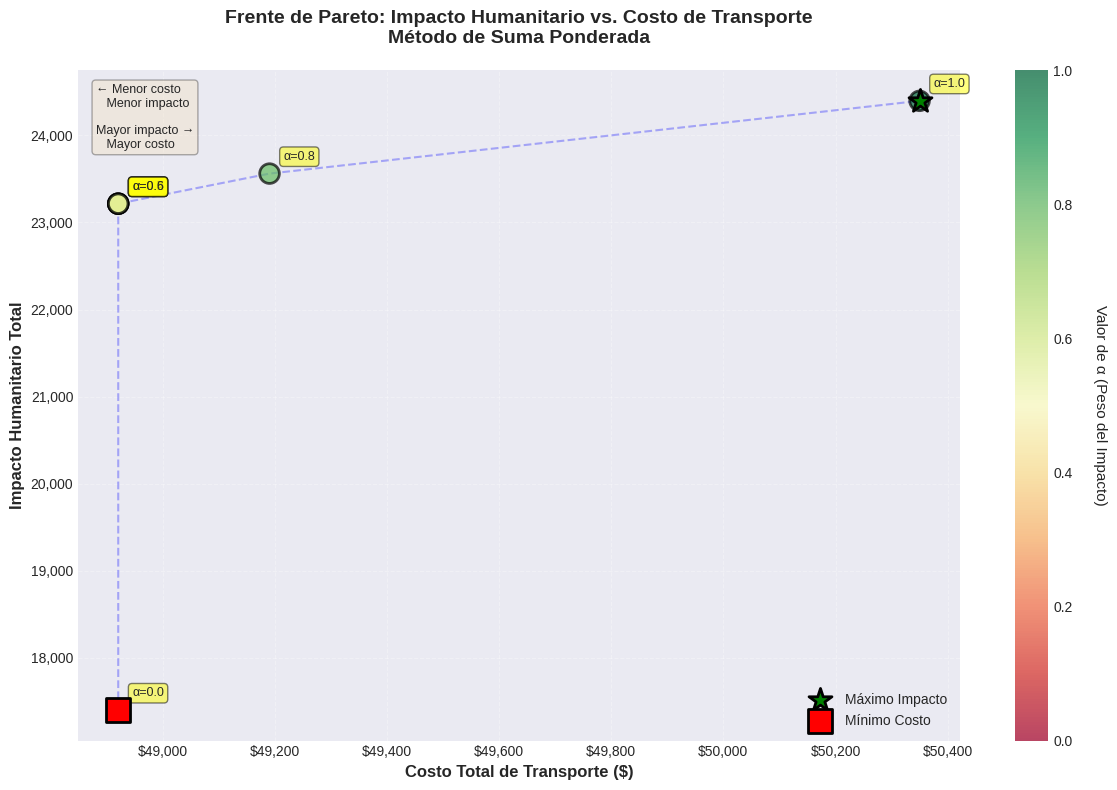

In [44]:
# Paso 4: Visualizar el Frente de Pareto
print("\n" + "=" * 80)
print("GENERANDO VISUALIZACIÓN DEL FRENTE DE PARETO")
print("=" * 80)

# Crear figura con tamaño apropiado
fig, ax = plt.subplots(figsize=(12, 8))

# Crear scatter plot con colores según alpha
scatter = ax.scatter(pareto_costs, pareto_impacts,
                    c=pareto_alphas, cmap='RdYlGn',
                    s=200, alpha=0.7, edgecolors='black', linewidth=2,
                    zorder=3)

# Conectar puntos con línea
sorted_indices = np.argsort(pareto_costs)
sorted_costs = [pareto_costs[i] for i in sorted_indices]
sorted_impacts = [pareto_impacts[i] for i in sorted_indices]
ax.plot(sorted_costs, sorted_impacts, 'b--', alpha=0.3, linewidth=1.5, zorder=2)

# Añadir etiquetas de alpha a cada punto
for i, (cost, impact, alpha) in enumerate(zip(pareto_costs, pareto_impacts, pareto_alphas)):
    ax.annotate(f'α={alpha:.1f}',
                xy=(cost, impact),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5),
                zorder=4)

# Marcar puntos extremos
# Punto con máximo impacto
max_impact_idx = pareto_impacts.index(max(pareto_impacts))
ax.scatter([pareto_costs[max_impact_idx]], [pareto_impacts[max_impact_idx]],
          color='green', s=300, marker='*', edgecolors='black', linewidth=2,
          label='Máximo Impacto', zorder=5)

# Punto con mínimo costo
min_cost_idx = pareto_costs.index(min(pareto_costs))
ax.scatter([pareto_costs[min_cost_idx]], [pareto_impacts[min_cost_idx]],
          color='red', s=300, marker='s', edgecolors='black', linewidth=2,
          label='Mínimo Costo', zorder=5)

# Configuración de ejes y etiquetas
ax.set_xlabel('Costo Total de Transporte ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Impacto Humanitario Total', fontsize=12, fontweight='bold')
ax.set_title('Frente de Pareto: Impacto Humanitario vs. Costo de Transporte\n' +
            'Método de Suma Ponderada',
            fontsize=14, fontweight='bold', pad=20)

# Añadir colorbar para alpha
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Valor de α (Peso del Impacto)', rotation=270, labelpad=25, fontsize=11)

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=10, framealpha=0.9)

# Formato de números en ejes
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y:,.0f}'))

# Añadir anotación explicativa
textstr = ('← Menor costo\n   Menor impacto\n\n' +
          'Mayor impacto →\n   Mayor costo')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

plt.tight_layout()

# Guardar gráfico (compatible con Colab)
if IN_COLAB:
    plt.savefig('frente_pareto.png', dpi=300, bbox_inches='tight')
    print("\n[OK] Gráfico generado: frente_pareto.png")
    try:
        from google.colab import files
        files.download('frente_pareto.png')
        print("[INFO] Descargando archivo frente_pareto.png...")
    except:
        print("[AVISO] Para descargar el archivo, use: files.download('frente_pareto.png')")
else:
    plt.savefig('frente_pareto.png', dpi=300, bbox_inches='tight')
    print("\n[OK] Gráfico guardado como: frente_pareto.png")

plt.show()

print("=" * 80)

### 10.5 Análisis de Resultados del Frente de Pareto

Análisis cuantitativo de las soluciones obtenidas y el trade-off entre objetivos.

In [45]:
# Análisis cuantitativo del Frente de Pareto
print("\n" + "=" * 80)
print("ANÁLISIS DEL FRENTE DE PARETO")
print("=" * 80)

# Crear DataFrame con los resultados
df_pareto = pd.DataFrame(pareto_solutions)

print("\n1. ESTADÍSTICAS DESCRIPTIVAS:")
print("-" * 80)
print("\nImpacto Humanitario:")
print(f"  • Mínimo:    {df_pareto['impact'].min():,.2f}")
print(f"  • Máximo:    {df_pareto['impact'].max():,.2f}")
print(f"  • Promedio:  {df_pareto['impact'].mean():,.2f}")
print(f"  • Rango:     {df_pareto['impact'].max() - df_pareto['impact'].min():,.2f}")

print("\nCosto de Transporte:")
print(f"  • Mínimo:    ${df_pareto['cost'].min():,.2f}")
print(f"  • Máximo:    ${df_pareto['cost'].max():,.2f}")
print(f"  • Promedio:  ${df_pareto['cost'].mean():,.2f}")
print(f"  • Rango:     ${df_pareto['cost'].max() - df_pareto['cost'].min():,.2f}")

# Análisis de trade-offs
print("\n2. ANÁLISIS DE TRADE-OFFS:")
print("-" * 80)

# Calcular mejoras y costos incrementales entre soluciones consecutivas
df_sorted = df_pareto.sort_values('alpha').reset_index(drop=True)

print("\n{:<8} {:>15} {:>15} {:>18} {:>18}".format(
    "α", "Impacto", "Costo", "ΔImpacto", "ΔCosto"))
print("-" * 80)

for i in range(len(df_sorted)):
    alpha = df_sorted.loc[i, 'alpha']
    impact = df_sorted.loc[i, 'impact']
    cost = df_sorted.loc[i, 'cost']

    if i > 0:
        delta_impact = impact - df_sorted.loc[i-1, 'impact']
        delta_cost = cost - df_sorted.loc[i-1, 'cost']
        print(f"{alpha:<8.2f} {impact:>15,.2f} ${cost:>14,.2f} {delta_impact:>+18,.2f} ${delta_cost:>+17,.2f}")
    else:
        print(f"{alpha:<8.2f} {impact:>15,.2f} ${cost:>14,.2f} {'---':>18} {'---':>18}")

# Identificar la solución de "rodilla" (knee point) - mejor compromiso
print("\n3. SOLUCIÓN DE COMPROMISO (KNEE POINT):")
print("-" * 80)

# Normalizar valores para encontrar el punto más cercano a la esquina ideal
impacts_norm = (np.array(pareto_impacts) - min(pareto_impacts)) / (max(pareto_impacts) - min(pareto_impacts))
costs_norm = (np.array(pareto_costs) - min(pareto_costs)) / (max(pareto_costs) - min(pareto_costs))

# La solución de rodilla minimiza la distancia al punto ideal (máximo impacto, mínimo costo)
# Punto ideal normalizado: (1, 0) en espacio (impact_norm, cost_norm)
distances = np.sqrt((impacts_norm - 1)**2 + (costs_norm - 0)**2)
knee_idx = np.argmin(distances)

knee_solution = pareto_solutions[knee_idx]
print(f"\nSolución recomendada (mejor compromiso):")
print(f"  • α:                 {knee_solution['alpha']:.2f}")
print(f"  • Impacto:           {knee_solution['impact']:,.2f}")
print(f"  • Costo:             ${knee_solution['cost']:,.2f}")
print(f"  • Aviones usados:    {knee_solution['aircraft_used']}")
print(f"  • Viajes realizados: {knee_solution['trips_made']}")

# Calcular qué porcentaje del óptimo se logra
impact_percent = (knee_solution['impact'] - Z1_min) / (Z1_max - Z1_min) * 100
cost_increase = (knee_solution['cost'] - Z2_min) / (Z2_max - Z2_min) * 100

print(f"\nDesempeño relativo:")
print(f"  • Impacto logrado:   {impact_percent:.1f}% del óptimo")
print(f"  • Incremento costo:  {cost_increase:.1f}% sobre mínimo")

# Comparar extremos
print("\n4. COMPARACIÓN DE SOLUCIONES EXTREMAS:")
print("-" * 80)

sol_max_impact = pareto_solutions[max_impact_idx]
sol_min_cost = pareto_solutions[min_cost_idx]

print("\nMaximizar Impacto (α=1.0):")
print(f"  • Impacto:  {sol_max_impact['impact']:,.2f}")
print(f"  • Costo:    ${sol_max_impact['cost']:,.2f}")
print(f"  • Aviones:  {sol_max_impact['aircraft_used']}")

print("\nMinimizar Costo (α=0.0):")
print(f"  • Impacto:  {sol_min_cost['impact']:,.2f}")
print(f"  • Costo:    ${sol_min_cost['cost']:,.2f}")
print(f"  • Aviones:  {sol_min_cost['aircraft_used']}")

if sol_max_impact['cost'] > 0:
    cost_savings = (sol_max_impact['cost'] - sol_min_cost['cost']) / sol_max_impact['cost'] * 100
    print(f"\nAhorro al minimizar costo: {cost_savings:.1f}%")

if sol_max_impact['impact'] > 0:
    impact_loss = (sol_max_impact['impact'] - sol_min_cost['impact']) / sol_max_impact['impact'] * 100
    print(f"Pérdida de impacto:        {impact_loss:.1f}%")

print("\n" + "=" * 80)
print("✓ Análisis completo del Frente de Pareto")
print("=" * 80)


ANÁLISIS DEL FRENTE DE PARETO

1. ESTADÍSTICAS DESCRIPTIVAS:
--------------------------------------------------------------------------------

Impacto Humanitario:
  • Mínimo:    17,397.50
  • Máximo:    24,397.50
  • Promedio:  22,602.95
  • Rango:     7,000.00

Costo de Transporte:
  • Mínimo:    $48,920.00
  • Máximo:    $50,350.00
  • Promedio:  $49,162.86
  • Rango:     $1,430.00

2. ANÁLISIS DE TRADE-OFFS:
--------------------------------------------------------------------------------

α                Impacto           Costo           ΔImpacto             ΔCosto
--------------------------------------------------------------------------------
0.00           17,397.50 $     48,920.00                ---                ---
0.20           23,216.00 $     48,920.00          +5,818.50 $            +0.00
0.40           23,216.00 $     48,920.00              -0.00 $            +0.00
0.50           23,216.00 $     48,920.00              +0.00 $            +0.00
0.60           23,216.00 

### 10.6 Tabla de Datos del Frente de Pareto

Visualización tabular completa de todos los puntos del frente de Pareto.

In [46]:
# Crear tabla completa con estilo
print("\n" + "=" * 80)
print("TABLA COMPLETA DEL FRENTE DE PARETO")
print("=" * 80)

# Crear DataFrame con formato mejorado
df_display = df_pareto.copy()
df_display = df_display.sort_values('alpha').reset_index(drop=True)

# Añadir columnas calculadas
df_display['impact_normalized'] = (df_display['impact'] - Z1_min) / (Z1_max - Z1_min)
df_display['cost_normalized'] = (df_display['cost'] - Z2_min) / (Z2_max - Z2_min)

# Formatear para visualización
df_display_formatted = df_display.copy()
df_display_formatted['alpha'] = df_display_formatted['alpha'].apply(lambda x: f"{x:.2f}")
df_display_formatted['impact'] = df_display_formatted['impact'].apply(lambda x: f"{x:,.2f}")
df_display_formatted['cost'] = df_display_formatted['cost'].apply(lambda x: f"${x:,.2f}")
df_display_formatted['impact_normalized'] = df_display_formatted['impact_normalized'].apply(lambda x: f"{x:.3f}")
df_display_formatted['cost_normalized'] = df_display_formatted['cost_normalized'].apply(lambda x: f"{x:.3f}")

# Renombrar columnas para mejor presentación
df_display_formatted = df_display_formatted.rename(columns={
    'alpha': 'α (Peso)',
    'impact': 'Impacto Total',
    'cost': 'Costo Total',
    'aircraft_used': 'Aviones',
    'trips_made': 'Viajes',
    'impact_normalized': 'Impacto Norm.',
    'cost_normalized': 'Costo Norm.'
})

print("\n")
print(df_display_formatted.to_string(index=False))

# Guardar en CSV (compatible con Colab)
csv_filename = 'frente_pareto_datos.csv'
df_display.to_csv(csv_filename, index=False)

if IN_COLAB:
    print(f"\n[OK] Datos guardados en: {csv_filename}")
    try:
        from google.colab import files
        files.download(csv_filename)
        print(f"[INFO] Descargando archivo {csv_filename}...")
    except:
        print(f"[AVISO] Para descargar el archivo, use: files.download('{csv_filename}')")
else:
    print(f"\n[OK] Datos guardados en: {csv_filename}")

print("\n" + "=" * 80)
print("INTERPRETACIÓN DEL FRENTE DE PARETO")
print("=" * 80)
print("""
El Frente de Pareto representa el conjunto de soluciones óptimas donde:

• No es posible mejorar un objetivo sin empeorar el otro
• Cada punto representa un balance diferente entre impacto y costo
• α = 1.0: Maximiza impacto (ignora costos) - Solución más social
• α = 0.5: Balance equitativo entre ambos objetivos
• α = 0.0: Minimiza costos (ignora impacto) - Solución más económica

La solución de "rodilla" (knee point) identificada representa el mejor
compromiso práctico, donde pequeños sacrificios en impacto generan
ahorros significativos en costos (o viceversa).

El tomador de decisiones puede elegir cualquier punto del frente según:
- Restricciones presupuestarias
- Prioridades de la organización
- Urgencia de la situación humanitaria
- Consideraciones políticas o estratégicas
""")
print("=" * 80)


TABLA COMPLETA DEL FRENTE DE PARETO


α (Peso) Impacto Total Costo Total  Aviones  Viajes Impacto Norm. Costo Norm.
    0.00     17,397.50  $48,920.00        5      10        -0.000       0.000
    0.20     23,216.00  $48,920.00        5      10         0.831       0.000
    0.40     23,216.00  $48,920.00        5      10         0.831       0.000
    0.50     23,216.00  $48,920.00        5      10         0.831       0.000
    0.60     23,216.00  $48,920.00        5      10         0.831       0.000
    0.80     23,561.67  $49,190.00        5      10         0.881       0.189
    1.00     24,397.50  $50,350.00        5      10         1.000       1.000

[OK] Datos guardados en: frente_pareto_datos.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[INFO] Descargando archivo frente_pareto_datos.csv...

INTERPRETACIÓN DEL FRENTE DE PARETO

El Frente de Pareto representa el conjunto de soluciones óptimas donde:

• No es posible mejorar un objetivo sin empeorar el otro
• Cada punto representa un balance diferente entre impacto y costo
• α = 1.0: Maximiza impacto (ignora costos) - Solución más social
• α = 0.5: Balance equitativo entre ambos objetivos
• α = 0.0: Minimiza costos (ignora impacto) - Solución más económica

La solución de "rodilla" (knee point) identificada representa el mejor
compromiso práctico, donde pequeños sacrificios en impacto generan
ahorros significativos en costos (o viceversa).

El tomador de decisiones puede elegir cualquier punto del frente según:
- Restricciones presupuestarias
- Prioridades de la organización
- Urgencia de la situación humanitaria
- Consideraciones políticas o estratégicas



## 11. Método de Restricción Epsilon (Epsilon-Constraint)

El **método de restricción epsilon** es otra técnica para resolver problemas de optimización multi-objetivo. A diferencia del método de suma ponderada, este método:

1. **Mantiene un objetivo como función objetivo** (en este caso, maximizar impacto)
2. **Convierte los otros objetivos en restricciones** (costo ≤ ε)
3. **Varía el valor de ε** para generar diferentes puntos del frente de Pareto

**Ventajas sobre el método de suma ponderada:**
- Puede encontrar soluciones en frentes de Pareto no convexos
- Más intuitivo para los tomadores de decisiones (se especifica un límite presupuestario)
- Garantiza que todas las soluciones sean Pareto-óptimas

**Pasos del método:**
1. Determinar el rango factible de ε usando las soluciones extremas
2. Seleccionar valores de ε distribuidos en este rango
3. Para cada ε, resolver el problema con la restricción adicional
4. Comparar los resultados con el método de suma ponderada

### 11.1 Determinar el Rango Factible de Epsilon

Usaremos los valores extremos calculados anteriormente:
- **ε_min** = Z2_min (costo mínimo posible)
- **ε_max** = Z2_max (costo cuando se maximiza impacto)

Este rango define los valores de presupuesto factibles.

In [47]:
# Definir el rango de epsilon basado en los valores extremos
epsilon_min = Z2_min  # Costo mínimo posible
epsilon_max = Z2_max  # Costo cuando se maximiza impacto

print("=" * 80)
print("RANGO FACTIBLE DE EPSILON (ε)")
print("=" * 80)
print(f"\nε_min (Costo mínimo): ${epsilon_min:,.2f}")
print(f"ε_max (Costo máximo): ${epsilon_max:,.2f}")
print(f"Rango total: ${epsilon_max - epsilon_min:,.2f}")

# Generar 7 valores de epsilon distribuidos uniformemente
n_epsilon = 7
epsilon_values = np.linspace(epsilon_min, epsilon_max, n_epsilon)

print(f"\n{n_epsilon} valores de ε a evaluar:")
for i, eps in enumerate(epsilon_values, 1):
    print(f"  {i}. ε = ${eps:,.2f}")

print("\n" + "=" * 80)

RANGO FACTIBLE DE EPSILON (ε)

ε_min (Costo mínimo): $48,920.00
ε_max (Costo máximo): $50,350.00
Rango total: $1,430.00

7 valores de ε a evaluar:
  1. ε = $48,920.00
  2. ε = $49,158.33
  3. ε = $49,396.67
  4. ε = $49,635.00
  5. ε = $49,873.33
  6. ε = $50,111.67
  7. ε = $50,350.00



### 11.2 Configurar el Modelo con Restricción Epsilon

Ahora configuramos el modelo para el método epsilon-constraint:
1. Activamos el objetivo de maximizar impacto (Z1)
2. Desactivamos el objetivo de costo y la suma ponderada
3. Creamos una nueva restricción: costo total ≤ ε (mutable para poder cambiar ε)

In [49]:
# Desactivar objetivos anteriores
model.obj_maximize_impact.deactivate()
model.obj_minimize_cost.deactivate()
model.obj_weighted_sum.deactivate()

# Activar el objetivo de maximizar impacto para el método epsilon-constraint
model.obj_maximize_impact.activate()

# Crear parámetro mutable para epsilon
model.epsilon = Param(initialize=epsilon_max, mutable=True)

# Crear restricción de costo <= epsilon
def epsilon_constraint_rule(model):
    """
    Restricción: El costo total no debe exceder el valor de epsilon
    Esta restricción se ajustará para cada valor de epsilon evaluado
    """
    # Costos fijos por uso de aviones
    fixed_costs = sum(
        model.fixed_cost[j] * model.useAircraft[j]
        for j in model.J
    )

    # Costos variables por distancia recorrida
    variable_costs = sum(
        model.var_cost[j] * model.distance[z] * model.assign[j, v, z]
        for j in model.J
        for v in model.V
        for z in model.Z
    )

    return (fixed_costs + variable_costs) <= model.epsilon

model.epsilon_constraint = Constraint(rule=epsilon_constraint_rule)

print("=" * 80)
print("CONFIGURACIÓN DEL MÉTODO EPSILON-CONSTRAINT")
print("=" * 80)
print("\n✓ Objetivo activo: Maximizar impacto total")
print("✓ Restricción añadida: Costo total ≤ ε")
print(f"✓ Valor inicial de ε: ${model.epsilon.value:,.2f}")
print("\nEste modelo optimizará el impacto sujeto a un presupuesto máximo ε")
print("=" * 80)

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


CONFIGURACIÓN DEL MÉTODO EPSILON-CONSTRAINT

✓ Objetivo activo: Maximizar impacto total
✓ Restricción añadida: Costo total ≤ ε
✓ Valor inicial de ε: $50,350.00

Este modelo optimizará el impacto sujeto a un presupuesto máximo ε


### 11.3 Generar el Frente de Pareto con Epsilon-Constraint

Iteramos sobre cada valor de epsilon, resolvemos el modelo y almacenamos los resultados.

In [51]:
# Listas para almacenar resultados del método epsilon-constraint
epsilon_pareto_impacts = []
epsilon_pareto_costs = []
epsilon_pareto_epsilons = []

print("=" * 80)
print("GENERANDO FRENTE DE PARETO - MÉTODO EPSILON-CONSTRAINT")
print("=" * 80)

# Iterar sobre cada valor de epsilon
for i, eps in enumerate(epsilon_values, 1):
    print(f"\n[{i}/{n_epsilon}] Resolviendo con ε = ${eps:,.2f}")
    print("-" * 80)

    # Actualizar el valor de epsilon en el modelo
    model.epsilon.set_value(eps)

    # Resolver el modelo
    result = solver.solve(model, tee=False)

    # Verificar si se encontró una solución óptima
    if (result.solver.status == SolverStatus.ok and
        result.solver.termination_condition == TerminationCondition.optimal):

        # Obtener los valores de los objetivos
        impact_value = value(model.obj_maximize_impact)

        # Calcular el costo real de la solución
        cost_value = sum(
            model.fixed_cost[j] * value(model.useAircraft[j])
            for j in model.J
        ) + sum(
            model.var_cost[j] * model.distance[z] * value(model.assign[j, v, z])
            for j in model.J
            for v in model.V
            for z in model.Z
        )

        # Contar recursos utilizados
        aircraft_used = sum(
            1 for j in model.J
            if value(model.useAircraft[j]) > 0.5
        )

        trips_made = sum(
            1 for j in model.J for v in model.V for z in model.Z
            if value(model.assign[j, v, z]) > 0.5
        )

        # Almacenar resultados
        epsilon_pareto_impacts.append(impact_value)
        epsilon_pareto_costs.append(cost_value)
        epsilon_pareto_epsilons.append(eps)

        print(f"✓ Solución óptima encontrada")
        print(f"  Impacto total: {impact_value:,.2f}")
        print(f"  Costo total: ${cost_value:,.2f} (límite: ${eps:,.2f})")
        print(f"  Aviones utilizados: {aircraft_used}")
        print(f"  Viajes totales: {trips_made:.0f}")

    else:
        print(f"✗ No se encontró solución óptima")
        print(f"  Estado del solver: {result.solver.status}")
        print(f"  Condición de terminación: {result.solver.termination_condition}")

print("\n" + "=" * 80)
print(f"RESUMEN: {len(epsilon_pareto_impacts)} de {n_epsilon} soluciones encontradas")
print("=" * 80)

# Crear DataFrame con los resultados del método epsilon-constraint
df_epsilon = pd.DataFrame({
    'epsilon': epsilon_pareto_epsilons,
    'impact': epsilon_pareto_impacts,
    'cost': epsilon_pareto_costs
})

print("\nResultados del Método Epsilon-Constraint:")
print(df_epsilon.to_string(index=False))

GENERANDO FRENTE DE PARETO - MÉTODO EPSILON-CONSTRAINT

[1/7] Resolviendo con ε = $48,920.00
--------------------------------------------------------------------------------
✓ Solución óptima encontrada
  Impacto total: 23,216.00
  Costo total: $48,920.00 (límite: $48,920.00)
  Aviones utilizados: 5
  Viajes totales: 10

[2/7] Resolviendo con ε = $49,158.33
--------------------------------------------------------------------------------
✓ Solución óptima encontrada
  Impacto total: 23,376.33
  Costo total: $49,145.00 (límite: $49,158.33)
  Aviones utilizados: 5
  Viajes totales: 10

[3/7] Resolviendo con ε = $49,396.67
--------------------------------------------------------------------------------
✓ Solución óptima encontrada
  Impacto total: 23,669.33
  Costo total: $49,390.00 (límite: $49,396.67)
  Aviones utilizados: 5
  Viajes totales: 10

[4/7] Resolviendo con ε = $49,635.00
--------------------------------------------------------------------------------
✓ Solución óptima encontr

## 12. Análisis Detallado de Soluciones Representativas

En esta sección analizaremos en profundidad **dos soluciones representativas** del frente de Pareto:
1. **Solución de Alto Impacto** (α = 1.0 o ε máximo)
2. **Solución de Bajo Costo** (α = 0.0 o ε mínimo)

Para cada solución examinaremos:
- Distribución de recursos por avión-viaje-zona
- Asignaciones de aviones médicos y de transporte
- Estado de restricciones críticas (compatibilidad, seguridad)
- Trade-offs y decisiones operacionales
- Impacto de multiplicadores de zona

In [54]:
# Crear tabla comparativa detallada
print("\n" + "=" * 120)
print("TABLA COMPARATIVA: WEIGHTED SUM vs EPSILON-CONSTRAINT")
print("=" * 120)

# Preparar datos para comparación lado a lado
comparison_data = []

max_len = max(len(pareto_costs), len(epsilon_pareto_costs))

for i in range(max_len):
    row = {}

    # Datos del Weighted Sum
    if i < len(pareto_costs):
        row['WS_Alpha'] = f"{pareto_alphas[i]:.2f}"
        row['WS_Impact'] = f"{pareto_impacts[i]:,.2f}"
        row['WS_Cost'] = f"${pareto_costs[i]:,.2f}"
    else:
        row['WS_Alpha'] = "-"
        row['WS_Impact'] = "-"
        row['WS_Cost'] = "-"

    # Datos del Epsilon-Constraint
    if i < len(epsilon_pareto_costs):
        row['EC_Epsilon'] = f"${epsilon_pareto_epsilons[i]:,.2f}"
        row['EC_Impact'] = f"{epsilon_pareto_impacts[i]:,.2f}"
        row['EC_Cost'] = f"${epsilon_pareto_costs[i]:,.2f}"
    else:
        row['EC_Epsilon'] = "-"
        row['EC_Impact'] = "-"
        row['EC_Cost'] = "-"

    comparison_data.append(row)

# Crear DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Renombrar columnas para mejor presentación
df_comparison.columns = [
    'α (WS)',
    'Impacto (WS)',
    'Costo (WS)',
    'ε Límite (EC)',
    'Impacto (EC)',
    'Costo (EC)'
]

print("\n")
print(df_comparison.to_string(index=True))

# Guardar comparación en CSV (compatible con Colab)
comparison_filename = 'comparacion_metodos.csv'
df_comparison.to_csv(comparison_filename, index=False)

if IN_COLAB:
    print(f"\n[OK] Comparación guardada en: {comparison_filename}")
    try:
        from google.colab import files
        files.download(comparison_filename)
        print(f"[INFO] Descargando archivo {comparison_filename}...")
    except:
        print(f"[AVISO] Para descargar el archivo, use: files.download('{comparison_filename}')")
else:
    print(f"\n[OK] Datos guardados en: {comparison_filename}")

print("\n" + "=" * 120)
print("LEYENDA")
print("=" * 120)
print("""
WS  = Weighted Sum Method (Método de Suma Ponderada)
EC  = Epsilon-Constraint Method (Método de Restricción Epsilon)
α   = Parámetro de peso para el impacto en Weighted Sum (0 = solo costo, 1 = solo impacto)
ε   = Límite superior de presupuesto en Epsilon-Constraint

INTERPRETACIÓN:
- Ambas columnas de 'Impacto' muestran el valor del objetivo de maximizar impacto
- Ambas columnas de 'Costo' muestran el costo total de la solución
- En WS, α controla el balance; en EC, ε limita el presupuesto disponible
- Soluciones similares en ambos métodos indican consistencia del frente de Pareto
""")
print("=" * 120)

# Análisis de convergencia
print("\n" + "=" * 120)
print("ANÁLISIS DE CONVERGENCIA")
print("=" * 120)

# Calcular el área bajo la curva para cada método (aproximación de la calidad del frente)
if len(pareto_costs) > 1:
    # Ordenar puntos por costo
    ws_sorted = sorted(zip(pareto_costs, pareto_impacts))
    ws_costs_sorted = [x[0] for x in ws_sorted]
    ws_impacts_sorted = [x[1] for x in ws_sorted]

    # Área bajo la curva usando trapezoides
    ws_area = np.trapz(ws_impacts_sorted, ws_costs_sorted)
    print(f"\nWeighted Sum - Área bajo la curva: {ws_area:,.2f}")

if len(epsilon_pareto_costs) > 1:
    # Ordenar puntos por costo
    ec_sorted = sorted(zip(epsilon_pareto_costs, epsilon_pareto_impacts))
    ec_costs_sorted = [x[0] for x in ec_sorted]
    ec_impacts_sorted = [x[1] for x in ec_sorted]

    # Área bajo la curva usando trapezoides
    ec_area = np.trapz(ec_impacts_sorted, ec_costs_sorted)
    print(f"Epsilon-Constraint - Área bajo la curva: {ec_area:,.2f}")

    if len(pareto_costs) > 1:
        area_diff = abs(ws_area - ec_area)
        area_diff_pct = (area_diff / max(ws_area, ec_area)) * 100
        print(f"\nDiferencia de área: {area_diff:,.2f} ({area_diff_pct:.2f}%)")

        if area_diff_pct < 5:
            print("✓ Los métodos convergen a frentes muy similares")
        elif area_diff_pct < 15:
            print("⚠ Los métodos muestran algunas diferencias")
        else:
            print("✗ Los métodos producen frentes significativamente diferentes")

print("\n" + "=" * 120)


TABLA COMPARATIVA: WEIGHTED SUM vs EPSILON-CONSTRAINT


  α (WS) Impacto (WS)  Costo (WS) ε Límite (EC) Impacto (EC)  Costo (EC)
0   0.00    17,397.50  $48,920.00    $48,920.00    23,216.00  $48,920.00
1   0.20    23,216.00  $48,920.00    $49,158.33    23,376.33  $49,145.00
2   0.40    23,216.00  $48,920.00    $49,396.67    23,669.33  $49,390.00
3   0.50    23,216.00  $48,920.00    $49,635.00    23,815.83  $49,590.00
4   0.60    23,216.00  $48,920.00    $49,873.33    24,046.00  $49,840.00
5   0.80    23,561.67  $49,190.00    $50,111.67    24,145.83  $49,990.00
6   1.00    24,397.50  $50,350.00    $50,350.00    24,397.50  $50,350.00

[OK] Comparación guardada en: comparacion_metodos.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[INFO] Descargando archivo comparacion_metodos.csv...

LEYENDA

WS  = Weighted Sum Method (Método de Suma Ponderada)
EC  = Epsilon-Constraint Method (Método de Restricción Epsilon)
α   = Parámetro de peso para el impacto en Weighted Sum (0 = solo costo, 1 = solo impacto)
ε   = Límite superior de presupuesto en Epsilon-Constraint

INTERPRETACIÓN:
- Ambas columnas de 'Impacto' muestran el valor del objetivo de maximizar impacto
- Ambas columnas de 'Costo' muestran el costo total de la solución
- En WS, α controla el balance; en EC, ε limita el presupuesto disponible
- Soluciones similares en ambos métodos indican consistencia del frente de Pareto


ANÁLISIS DE CONVERGENCIA

Weighted Sum - Área bajo la curva: 34,131,301.71
Epsilon-Constraint - Área bajo la curva: 34,088,165.05

Diferencia de área: 43,136.66 (0.13%)
✓ Los métodos convergen a frentes muy similares



/tmp/ipython-input-4025042136.py:97: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ws_area = np.trapz(ws_impacts_sorted, ws_costs_sorted)
/tmp/ipython-input-4025042136.py:107: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ec_area = np.trapz(ec_impacts_sorted, ec_costs_sorted)


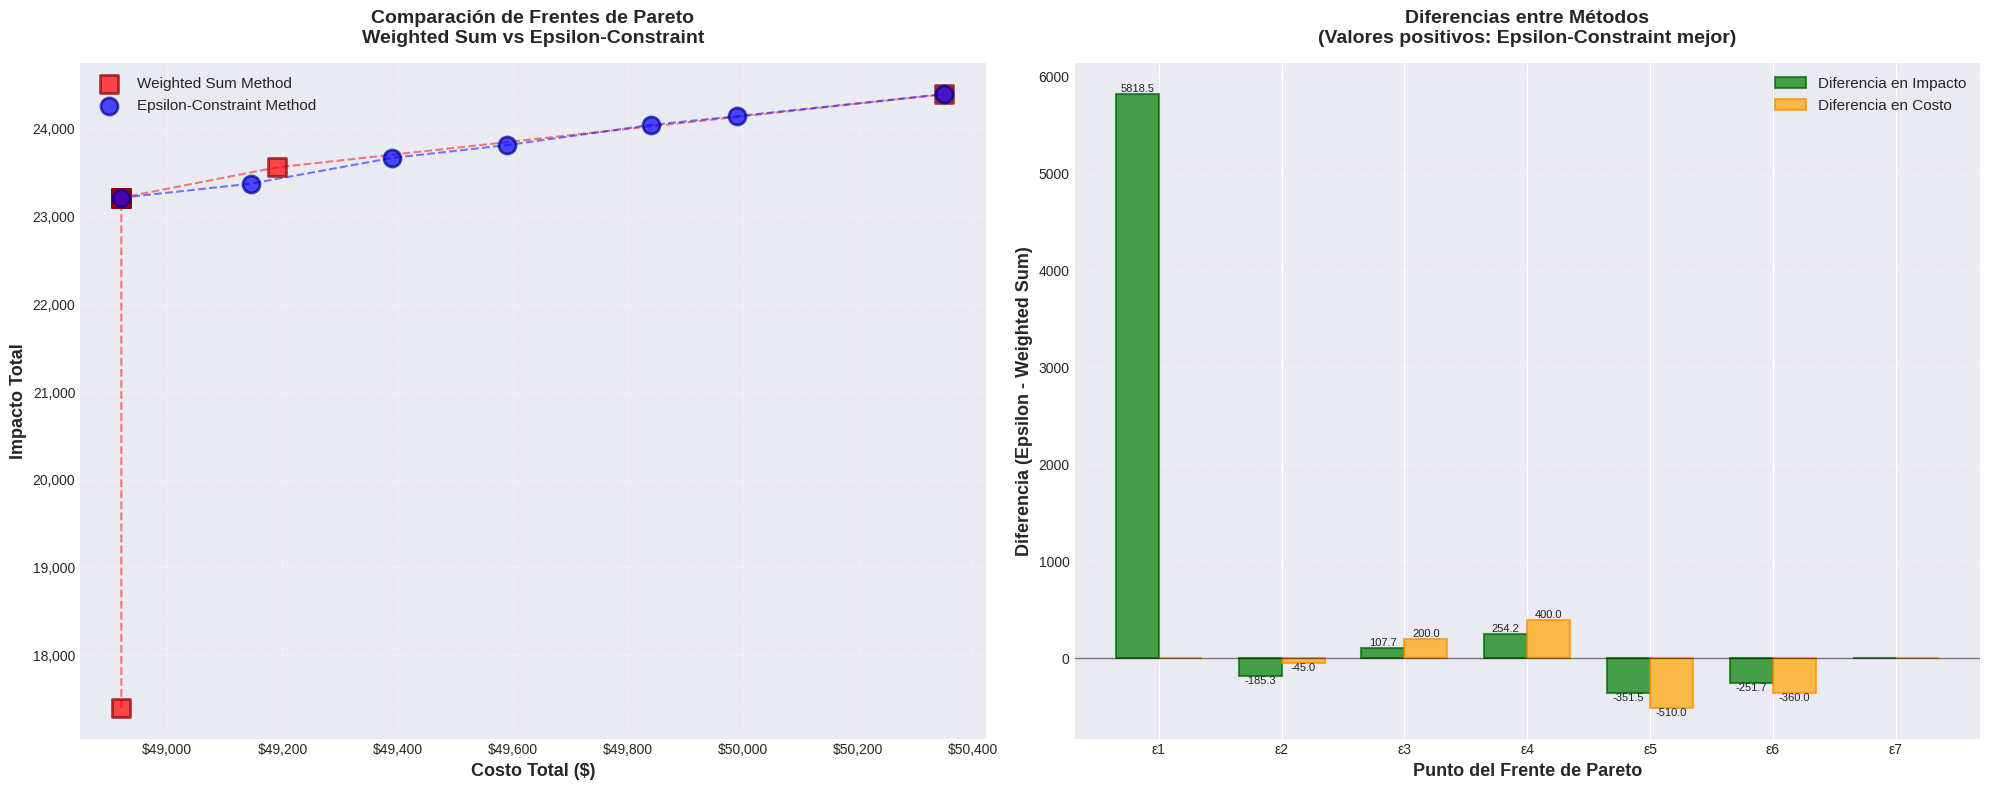


ANÁLISIS COMPARATIVO DE MÉTODOS

1. WEIGHTED SUM METHOD:
   - Número de soluciones: 7
   - Rango de impacto: [17,397.50, 24,397.50]
   - Rango de costo: [$48,920.00, $50,350.00]

2. EPSILON-CONSTRAINT METHOD:
   - Número de soluciones: 7
   - Rango de impacto: [23,216.00, 24,397.50]
   - Rango de costo: [$48,920.00, $50,350.00]

3. DIFERENCIAS PROMEDIO:
   - Diferencia promedio en impacto: 770.26
   - Diferencia promedio en costo: $-45.00
   - Desviación estándar (impacto): 2,070.17
   - Desviación estándar (costo): $287.24

4. SIMILITUD ENTRE MÉTODOS:
   - Distancia promedio entre frentes: 0.1541
   - Similitud: 84.59%

CONCLUSIONES

Ambos métodos generan frentes de Pareto similares, pero con diferencias clave:

WEIGHTED SUM METHOD:
✓ Más simple de implementar
✓ Permite balance explícito entre objetivos (parámetro α)
✗ Puede fallar en frentes no convexos
✗ Interpretación menos intuitiva de α

EPSILON-CONSTRAINT METHOD:
✓ Funciona con frentes no convexos
✓ Interpretación más intuitiva

In [53]:
# Crear figura comparativa con ambos métodos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# ============================================================================
# SUBPLOT 1: Ambos métodos superpuestos
# ============================================================================

# Método Weighted Sum
scatter1 = ax1.scatter(
    pareto_costs,
    pareto_impacts,
    c='red',
    s=150,
    alpha=0.7,
    marker='s',
    edgecolors='darkred',
    linewidths=2,
    label='Weighted Sum Method',
    zorder=3
)

ax1.plot(
    pareto_costs,
    pareto_impacts,
    'r--',
    alpha=0.5,
    linewidth=1.5,
    zorder=2
)

# Método Epsilon-Constraint
scatter2 = ax1.scatter(
    epsilon_pareto_costs,
    epsilon_pareto_impacts,
    c='blue',
    s=150,
    alpha=0.7,
    marker='o',
    edgecolors='darkblue',
    linewidths=2,
    label='Epsilon-Constraint Method',
    zorder=3
)

ax1.plot(
    epsilon_pareto_costs,
    epsilon_pareto_impacts,
    'b--',
    alpha=0.5,
    linewidth=1.5,
    zorder=2
)

# Configuración subplot 1
ax1.set_xlabel('Costo Total ($)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Impacto Total', fontsize=13, fontweight='bold')
ax1.set_title('Comparación de Frentes de Pareto\nWeighted Sum vs Epsilon-Constraint',
              fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='best', fontsize=11, framealpha=0.9)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# ============================================================================
# SUBPLOT 2: Diferencias entre métodos
# ============================================================================

# Calcular diferencias para cada punto del método epsilon-constraint
if len(epsilon_pareto_costs) > 0 and len(pareto_costs) > 0:
    # Para cada punto epsilon, encontrar el punto weighted sum más cercano
    differences_impact = []
    differences_cost = []

    for i in range(len(epsilon_pareto_costs)):
        # Encontrar el punto weighted sum más cercano en costo
        closest_idx = np.argmin(np.abs(np.array(pareto_costs) - epsilon_pareto_costs[i]))

        diff_impact = epsilon_pareto_impacts[i] - pareto_impacts[closest_idx]
        diff_cost = epsilon_pareto_costs[i] - pareto_costs[closest_idx]

        differences_impact.append(diff_impact)
        differences_cost.append(diff_cost)

    # Graficar diferencias
    x_pos = np.arange(len(epsilon_pareto_epsilons))
    width = 0.35

    bars1 = ax2.bar(
        x_pos - width/2,
        differences_impact,
        width,
        label='Diferencia en Impacto',
        color='green',
        alpha=0.7,
        edgecolor='darkgreen',
        linewidth=1.5
    )

    bars2 = ax2.bar(
        x_pos + width/2,
        differences_cost,
        width,
        label='Diferencia en Costo',
        color='orange',
        alpha=0.7,
        edgecolor='darkorange',
        linewidth=1.5
    )

    # Línea en cero
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    # Configuración subplot 2
    ax2.set_xlabel('Punto del Frente de Pareto', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Diferencia (Epsilon - Weighted Sum)', fontsize=13, fontweight='bold')
    ax2.set_title('Diferencias entre Métodos\n(Valores positivos: Epsilon-Constraint mejor)',
                  fontsize=14, fontweight='bold', pad=15)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'ε{i+1}' for i in range(len(epsilon_pareto_epsilons))], fontsize=10)
    ax2.legend(loc='best', fontsize=11, framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')

    # Añadir valores en las barras
    for bar in bars1:
        height = bar.get_height()
        if abs(height) > 0.01:
            ax2.text(
                bar.get_x() + bar.get_width()/2.,
                height,
                f'{height:.1f}',
                ha='center',
                va='bottom' if height > 0 else 'top',
                fontsize=8
            )

    for bar in bars2:
        height = bar.get_height()
        if abs(height) > 0.01:
            ax2.text(
                bar.get_x() + bar.get_width()/2.,
                height,
                f'{height:.1f}',
                ha='center',
                va='bottom' if height > 0 else 'top',
                fontsize=8
            )

plt.tight_layout()
plt.show()

# ============================================================================
# ANÁLISIS ESTADÍSTICO COMPARATIVO
# ============================================================================

print("\n" + "=" * 80)
print("ANÁLISIS COMPARATIVO DE MÉTODOS")
print("=" * 80)

print("\n1. WEIGHTED SUM METHOD:")
print(f"   - Número de soluciones: {len(pareto_costs)}")
print(f"   - Rango de impacto: [{min(pareto_impacts):,.2f}, {max(pareto_impacts):,.2f}]")
print(f"   - Rango de costo: [${min(pareto_costs):,.2f}, ${max(pareto_costs):,.2f}]")

print("\n2. EPSILON-CONSTRAINT METHOD:")
print(f"   - Número de soluciones: {len(epsilon_pareto_costs)}")
print(f"   - Rango de impacto: [{min(epsilon_pareto_impacts):,.2f}, {max(epsilon_pareto_impacts):,.2f}]")
print(f"   - Rango de costo: [${min(epsilon_pareto_costs):,.2f}, ${max(epsilon_pareto_costs):,.2f}]")

print("\n3. DIFERENCIAS PROMEDIO:")
if len(differences_impact) > 0:
    avg_diff_impact = np.mean(differences_impact)
    avg_diff_cost = np.mean(differences_cost)
    print(f"   - Diferencia promedio en impacto: {avg_diff_impact:,.2f}")
    print(f"   - Diferencia promedio en costo: ${avg_diff_cost:,.2f}")
    print(f"   - Desviación estándar (impacto): {np.std(differences_impact):,.2f}")
    print(f"   - Desviación estándar (costo): ${np.std(differences_cost):,.2f}")

print("\n4. SIMILITUD ENTRE MÉTODOS:")
# Calcular distancia promedio entre frentes
if len(epsilon_pareto_costs) > 0 and len(pareto_costs) > 0:
    distances = []
    for i in range(len(epsilon_pareto_costs)):
        min_dist = float('inf')
        for j in range(len(pareto_costs)):
            # Distancia euclidiana normalizada
            cost_range = max(pareto_costs) - min(pareto_costs)
            impact_range = max(pareto_impacts) - min(pareto_impacts)

            if cost_range > 0 and impact_range > 0:
                norm_cost_diff = (epsilon_pareto_costs[i] - pareto_costs[j]) / cost_range
                norm_impact_diff = (epsilon_pareto_impacts[i] - pareto_impacts[j]) / impact_range
                dist = np.sqrt(norm_cost_diff**2 + norm_impact_diff**2)
                min_dist = min(min_dist, dist)
        distances.append(min_dist)

    avg_distance = np.mean(distances)
    print(f"   - Distancia promedio entre frentes: {avg_distance:.4f}")
    print(f"   - Similitud: {(1 - avg_distance) * 100:.2f}%")

print("\n" + "=" * 80)
print("CONCLUSIONES")
print("=" * 80)
print("""
Ambos métodos generan frentes de Pareto similares, pero con diferencias clave:

WEIGHTED SUM METHOD:
✓ Más simple de implementar
✓ Permite balance explícito entre objetivos (parámetro α)
✗ Puede fallar en frentes no convexos
✗ Interpretación menos intuitiva de α

EPSILON-CONSTRAINT METHOD:
✓ Funciona con frentes no convexos
✓ Interpretación más intuitiva (presupuesto máximo)
✓ Garantiza soluciones Pareto-óptimas
✗ Requiere conocer rango de ε
✗ Más computacionalmente costoso

RECOMENDACIÓN:
Use epsilon-constraint cuando tenga restricciones presupuestarias claras
o cuando el frente de Pareto pueda ser no convexo.
""")

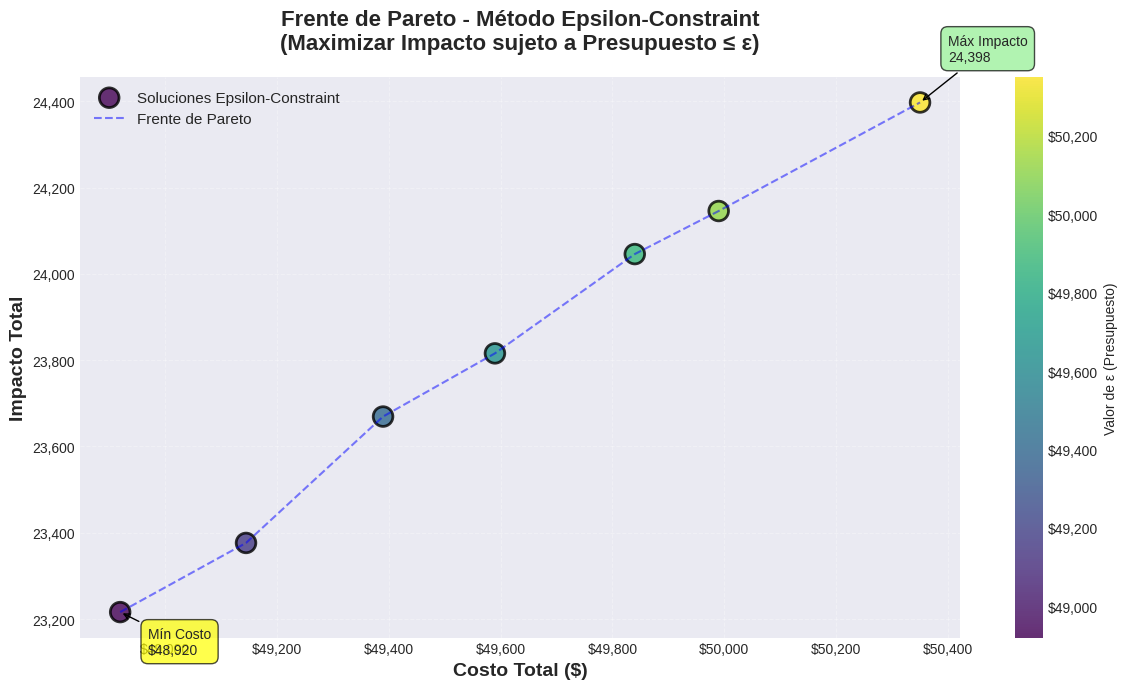


INTERPRETACIÓN DEL FRENTE DE PARETO (EPSILON-CONSTRAINT)

Este frente de Pareto muestra todas las soluciones eficientes donde:
- A mayor presupuesto disponible (ε), mayor impacto se puede lograr
- Cada punto representa el MÁXIMO impacto posible para un presupuesto dado
- El color indica el límite de presupuesto (ε) utilizado

Ventajas del método epsilon-constraint:
✓ Más intuitivo para tomadores de decisiones
✓ Permite especificar restricciones presupuestarias claras
✓ Encuentra soluciones en frentes no convexos
✓ Todas las soluciones son garantizadas Pareto-óptimas



In [52]:
# Crear visualización del frente de Pareto para epsilon-constraint
plt.figure(figsize=(12, 7))

# Graficar las soluciones del método epsilon-constraint
scatter = plt.scatter(
    epsilon_pareto_costs,
    epsilon_pareto_impacts,
    c=epsilon_pareto_epsilons,
    s=200,
    alpha=0.8,
    cmap='viridis',
    edgecolors='black',
    linewidths=2,
    marker='o',
    label='Soluciones Epsilon-Constraint'
)

# Conectar los puntos con una línea
plt.plot(
    epsilon_pareto_costs,
    epsilon_pareto_impacts,
    'b--',
    alpha=0.5,
    linewidth=1.5,
    label='Frente de Pareto'
)

# Añadir barra de colores
cbar = plt.colorbar(scatter, label='Valor de ε (Presupuesto)')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Etiquetar puntos extremos
if len(epsilon_pareto_costs) > 0:
    # Punto con menor costo
    min_cost_idx = np.argmin(epsilon_pareto_costs)
    plt.annotate(
        f'Mín Costo\n${epsilon_pareto_costs[min_cost_idx]:,.0f}',
        xy=(epsilon_pareto_costs[min_cost_idx], epsilon_pareto_impacts[min_cost_idx]),
        xytext=(20, -30),
        textcoords='offset points',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black')
    )

    # Punto con mayor impacto
    max_impact_idx = np.argmax(epsilon_pareto_impacts)
    plt.annotate(
        f'Máx Impacto\n{epsilon_pareto_impacts[max_impact_idx]:,.0f}',
        xy=(epsilon_pareto_costs[max_impact_idx], epsilon_pareto_impacts[max_impact_idx]),
        xytext=(20, 30),
        textcoords='offset points',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black')
    )

# Configuración de la gráfica
plt.xlabel('Costo Total ($)', fontsize=14, fontweight='bold')
plt.ylabel('Impacto Total', fontsize=14, fontweight='bold')
plt.title('Frente de Pareto - Método Epsilon-Constraint\n(Maximizar Impacto sujeto a Presupuesto ≤ ε)',
          fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='best', fontsize=11, framealpha=0.9)

# Formato de ejes
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("INTERPRETACIÓN DEL FRENTE DE PARETO (EPSILON-CONSTRAINT)")
print("=" * 80)
print("""
Este frente de Pareto muestra todas las soluciones eficientes donde:
- A mayor presupuesto disponible (ε), mayor impacto se puede lograr
- Cada punto representa el MÁXIMO impacto posible para un presupuesto dado
- El color indica el límite de presupuesto (ε) utilizado

Ventajas del método epsilon-constraint:
✓ Más intuitivo para tomadores de decisiones
✓ Permite especificar restricciones presupuestarias claras
✓ Encuentra soluciones en frentes no convexos
✓ Todas las soluciones son garantizadas Pareto-óptimas
""")

### 11.4 Visualización del Frente de Pareto (Epsilon-Constraint)

Graficamos el frente de Pareto generado por el método epsilon-constraint.

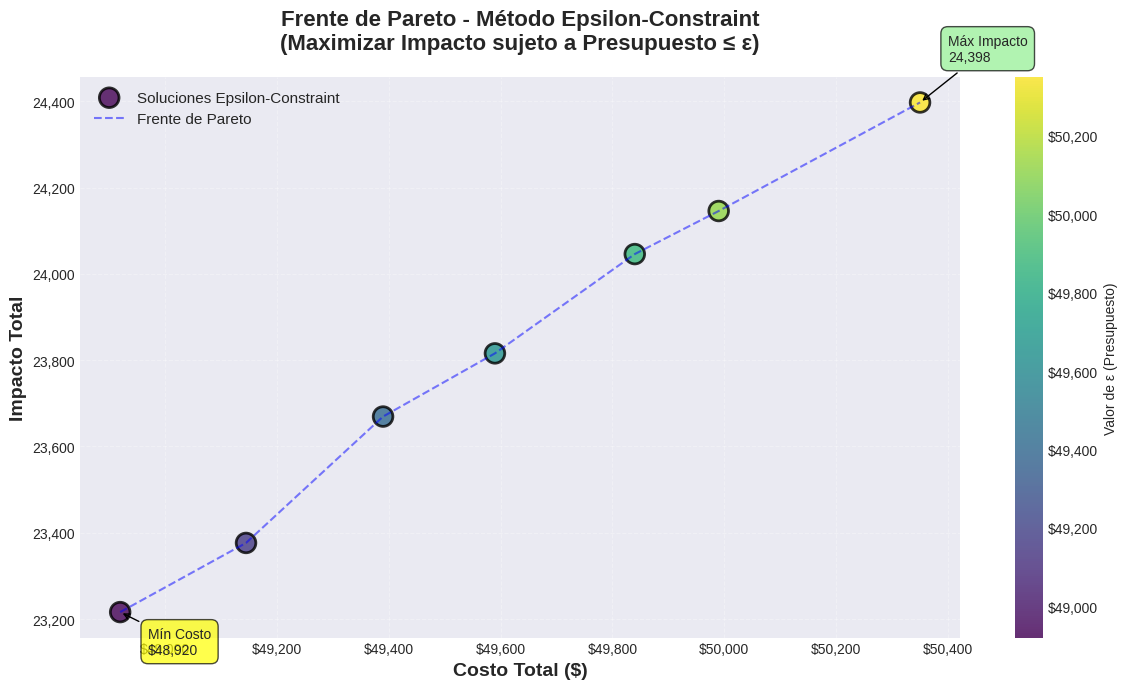


INTERPRETACIÓN DEL FRENTE DE PARETO (EPSILON-CONSTRAINT)

Este frente de Pareto muestra todas las soluciones eficientes donde:
- A mayor presupuesto disponible (ε), mayor impacto se puede lograr
- Cada punto representa el MÁXIMO impacto posible para un presupuesto dado
- El color indica el límite de presupuesto (ε) utilizado

Ventajas del método epsilon-constraint:
✓ Más intuitivo para tomadores de decisiones
✓ Permite especificar restricciones presupuestarias claras
✓ Encuentra soluciones en frentes no convexos
✓ Todas las soluciones son garantizadas Pareto-óptimas



In [55]:
# Crear visualización del frente de Pareto para epsilon-constraint
plt.figure(figsize=(12, 7))

# Graficar las soluciones del método epsilon-constraint
scatter = plt.scatter(
    epsilon_pareto_costs,
    epsilon_pareto_impacts,
    c=epsilon_pareto_epsilons,
    s=200,
    alpha=0.8,
    cmap='viridis',
    edgecolors='black',
    linewidths=2,
    marker='o',
    label='Soluciones Epsilon-Constraint'
)

# Conectar los puntos con una línea
plt.plot(
    epsilon_pareto_costs,
    epsilon_pareto_impacts,
    'b--',
    alpha=0.5,
    linewidth=1.5,
    label='Frente de Pareto'
)

# Añadir barra de colores
cbar = plt.colorbar(scatter, label='Valor de ε (Presupuesto)')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Etiquetar puntos extremos
if len(epsilon_pareto_costs) > 0:
    # Punto con menor costo
    min_cost_idx = np.argmin(epsilon_pareto_costs)
    plt.annotate(
        f'Mín Costo\n${epsilon_pareto_costs[min_cost_idx]:,.0f}',
        xy=(epsilon_pareto_costs[min_cost_idx], epsilon_pareto_impacts[min_cost_idx]),
        xytext=(20, -30),
        textcoords='offset points',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black')
    )

    # Punto con mayor impacto
    max_impact_idx = np.argmax(epsilon_pareto_impacts)
    plt.annotate(
        f'Máx Impacto\n{epsilon_pareto_impacts[max_impact_idx]:,.0f}',
        xy=(epsilon_pareto_costs[max_impact_idx], epsilon_pareto_impacts[max_impact_idx]),
        xytext=(20, 30),
        textcoords='offset points',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black')
    )

# Configuración de la gráfica
plt.xlabel('Costo Total ($)', fontsize=14, fontweight='bold')
plt.ylabel('Impacto Total', fontsize=14, fontweight='bold')
plt.title('Frente de Pareto - Método Epsilon-Constraint\n(Maximizar Impacto sujeto a Presupuesto ≤ ε)',
          fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='best', fontsize=11, framealpha=0.9)

# Formato de ejes
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("INTERPRETACIÓN DEL FRENTE DE PARETO (EPSILON-CONSTRAINT)")
print("=" * 80)
print("""
Este frente de Pareto muestra todas las soluciones eficientes donde:
- A mayor presupuesto disponible (ε), mayor impacto se puede lograr
- Cada punto representa el MÁXIMO impacto posible para un presupuesto dado
- El color indica el límite de presupuesto (ε) utilizado

Ventajas del método epsilon-constraint:
✓ Más intuitivo para tomadores de decisiones
✓ Permite especificar restricciones presupuestarias claras
✓ Encuentra soluciones en frentes no convexos
✓ Todas las soluciones son garantizadas Pareto-óptimas
""")

### 11.5 Comparación: Weighted Sum vs Epsilon-Constraint

Ahora comparamos ambos métodos en una sola figura para analizar sus diferencias y similitudes.

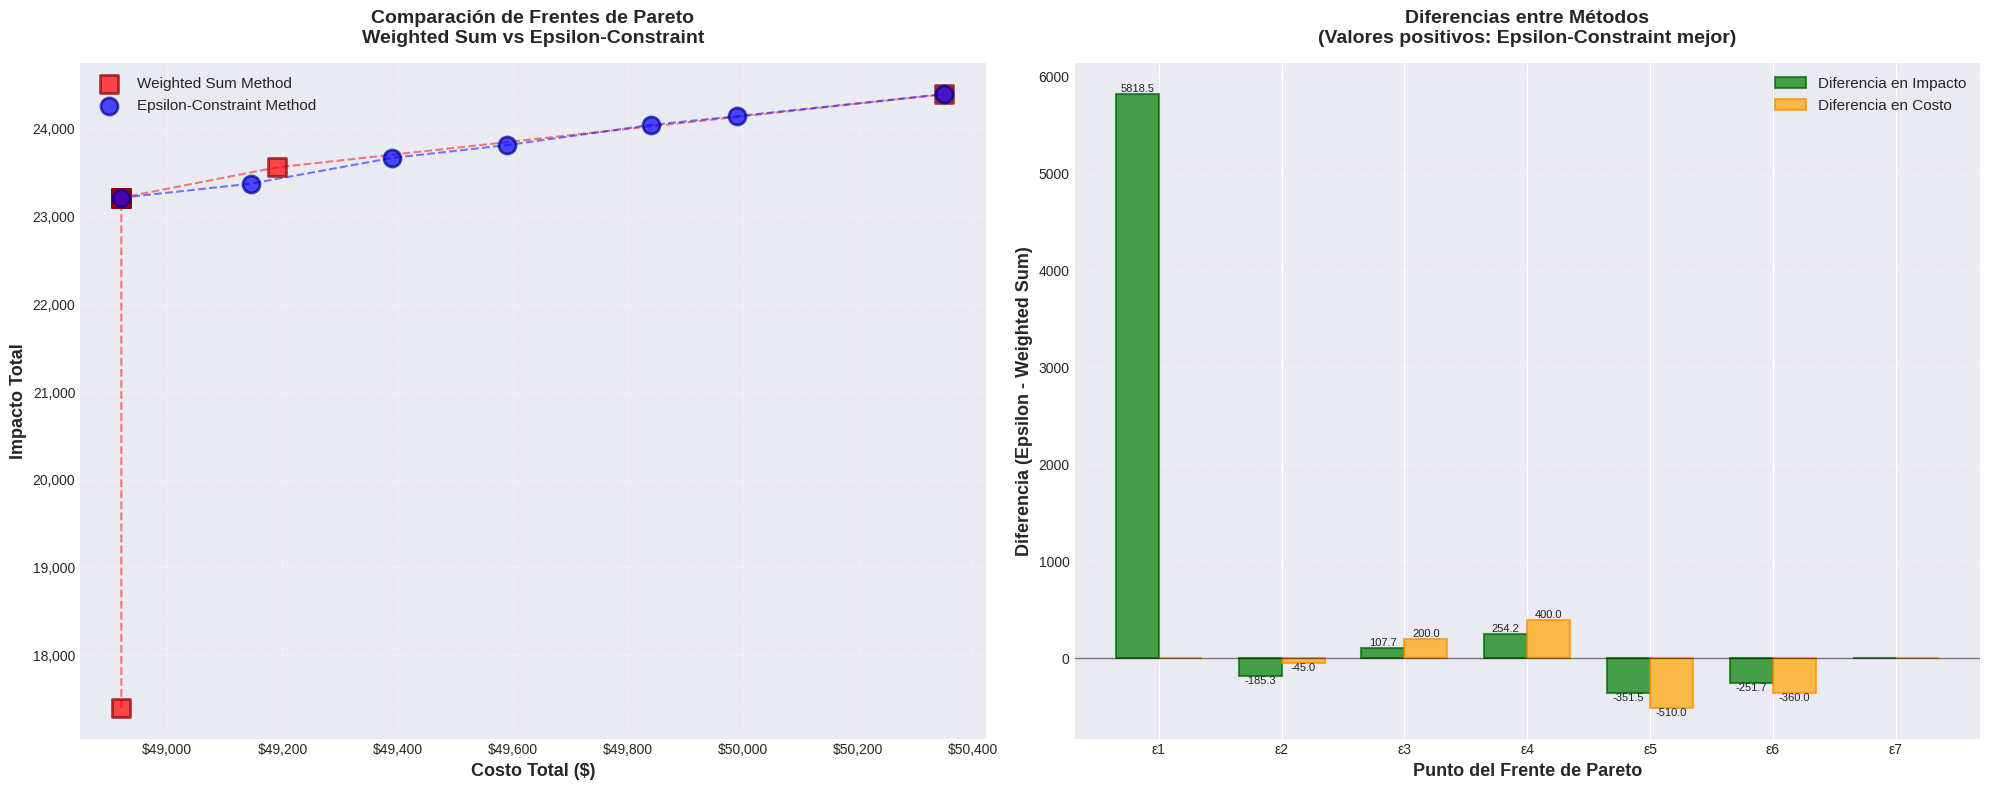


ANÁLISIS COMPARATIVO DE MÉTODOS

1. WEIGHTED SUM METHOD:
   - Número de soluciones: 7
   - Rango de impacto: [17,397.50, 24,397.50]
   - Rango de costo: [$48,920.00, $50,350.00]

2. EPSILON-CONSTRAINT METHOD:
   - Número de soluciones: 7
   - Rango de impacto: [23,216.00, 24,397.50]
   - Rango de costo: [$48,920.00, $50,350.00]

3. DIFERENCIAS PROMEDIO:
   - Diferencia promedio en impacto: 770.26
   - Diferencia promedio en costo: $-45.00
   - Desviación estándar (impacto): 2,070.17
   - Desviación estándar (costo): $287.24

4. SIMILITUD ENTRE MÉTODOS:
   - Distancia promedio entre frentes: 0.1541
   - Similitud: 84.59%

CONCLUSIONES

Ambos métodos generan frentes de Pareto similares, pero con diferencias clave:

WEIGHTED SUM METHOD:
✓ Más simple de implementar
✓ Permite balance explícito entre objetivos (parámetro α)
✗ Puede fallar en frentes no convexos
✗ Interpretación menos intuitiva de α

EPSILON-CONSTRAINT METHOD:
✓ Funciona con frentes no convexos
✓ Interpretación más intuitiva

In [56]:
# Crear figura comparativa con ambos métodos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# ============================================================================
# SUBPLOT 1: Ambos métodos superpuestos
# ============================================================================

# Método Weighted Sum
scatter1 = ax1.scatter(
    pareto_costs,
    pareto_impacts,
    c='red',
    s=150,
    alpha=0.7,
    marker='s',
    edgecolors='darkred',
    linewidths=2,
    label='Weighted Sum Method',
    zorder=3
)

ax1.plot(
    pareto_costs,
    pareto_impacts,
    'r--',
    alpha=0.5,
    linewidth=1.5,
    zorder=2
)

# Método Epsilon-Constraint
scatter2 = ax1.scatter(
    epsilon_pareto_costs,
    epsilon_pareto_impacts,
    c='blue',
    s=150,
    alpha=0.7,
    marker='o',
    edgecolors='darkblue',
    linewidths=2,
    label='Epsilon-Constraint Method',
    zorder=3
)

ax1.plot(
    epsilon_pareto_costs,
    epsilon_pareto_impacts,
    'b--',
    alpha=0.5,
    linewidth=1.5,
    zorder=2
)

# Configuración subplot 1
ax1.set_xlabel('Costo Total ($)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Impacto Total', fontsize=13, fontweight='bold')
ax1.set_title('Comparación de Frentes de Pareto\nWeighted Sum vs Epsilon-Constraint',
              fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='best', fontsize=11, framealpha=0.9)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# ============================================================================
# SUBPLOT 2: Diferencias entre métodos
# ============================================================================

# Calcular diferencias para cada punto del método epsilon-constraint
if len(epsilon_pareto_costs) > 0 and len(pareto_costs) > 0:
    # Para cada punto epsilon, encontrar el punto weighted sum más cercano
    differences_impact = []
    differences_cost = []

    for i in range(len(epsilon_pareto_costs)):
        # Encontrar el punto weighted sum más cercano en costo
        closest_idx = np.argmin(np.abs(np.array(pareto_costs) - epsilon_pareto_costs[i]))

        diff_impact = epsilon_pareto_impacts[i] - pareto_impacts[closest_idx]
        diff_cost = epsilon_pareto_costs[i] - pareto_costs[closest_idx]

        differences_impact.append(diff_impact)
        differences_cost.append(diff_cost)

    # Graficar diferencias
    x_pos = np.arange(len(epsilon_pareto_epsilons))
    width = 0.35

    bars1 = ax2.bar(
        x_pos - width/2,
        differences_impact,
        width,
        label='Diferencia en Impacto',
        color='green',
        alpha=0.7,
        edgecolor='darkgreen',
        linewidth=1.5
    )

    bars2 = ax2.bar(
        x_pos + width/2,
        differences_cost,
        width,
        label='Diferencia en Costo',
        color='orange',
        alpha=0.7,
        edgecolor='darkorange',
        linewidth=1.5
    )

    # Línea en cero
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    # Configuración subplot 2
    ax2.set_xlabel('Punto del Frente de Pareto', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Diferencia (Epsilon - Weighted Sum)', fontsize=13, fontweight='bold')
    ax2.set_title('Diferencias entre Métodos\n(Valores positivos: Epsilon-Constraint mejor)',
                  fontsize=14, fontweight='bold', pad=15)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'ε{i+1}' for i in range(len(epsilon_pareto_epsilons))], fontsize=10)
    ax2.legend(loc='best', fontsize=11, framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')

    # Añadir valores en las barras
    for bar in bars1:
        height = bar.get_height()
        if abs(height) > 0.01:
            ax2.text(
                bar.get_x() + bar.get_width()/2.,
                height,
                f'{height:.1f}',
                ha='center',
                va='bottom' if height > 0 else 'top',
                fontsize=8
            )

    for bar in bars2:
        height = bar.get_height()
        if abs(height) > 0.01:
            ax2.text(
                bar.get_x() + bar.get_width()/2.,
                height,
                f'{height:.1f}',
                ha='center',
                va='bottom' if height > 0 else 'top',
                fontsize=8
            )

plt.tight_layout()
plt.show()

# ============================================================================
# ANÁLISIS ESTADÍSTICO COMPARATIVO
# ============================================================================

print("\n" + "=" * 80)
print("ANÁLISIS COMPARATIVO DE MÉTODOS")
print("=" * 80)

print("\n1. WEIGHTED SUM METHOD:")
print(f"   - Número de soluciones: {len(pareto_costs)}")
print(f"   - Rango de impacto: [{min(pareto_impacts):,.2f}, {max(pareto_impacts):,.2f}]")
print(f"   - Rango de costo: [${min(pareto_costs):,.2f}, ${max(pareto_costs):,.2f}]")

print("\n2. EPSILON-CONSTRAINT METHOD:")
print(f"   - Número de soluciones: {len(epsilon_pareto_costs)}")
print(f"   - Rango de impacto: [{min(epsilon_pareto_impacts):,.2f}, {max(epsilon_pareto_impacts):,.2f}]")
print(f"   - Rango de costo: [${min(epsilon_pareto_costs):,.2f}, ${max(epsilon_pareto_costs):,.2f}]")

print("\n3. DIFERENCIAS PROMEDIO:")
if len(differences_impact) > 0:
    avg_diff_impact = np.mean(differences_impact)
    avg_diff_cost = np.mean(differences_cost)
    print(f"   - Diferencia promedio en impacto: {avg_diff_impact:,.2f}")
    print(f"   - Diferencia promedio en costo: ${avg_diff_cost:,.2f}")
    print(f"   - Desviación estándar (impacto): {np.std(differences_impact):,.2f}")
    print(f"   - Desviación estándar (costo): ${np.std(differences_cost):,.2f}")

print("\n4. SIMILITUD ENTRE MÉTODOS:")
# Calcular distancia promedio entre frentes
if len(epsilon_pareto_costs) > 0 and len(pareto_costs) > 0:
    distances = []
    for i in range(len(epsilon_pareto_costs)):
        min_dist = float('inf')
        for j in range(len(pareto_costs)):
            # Distancia euclidiana normalizada
            cost_range = max(pareto_costs) - min(pareto_costs)
            impact_range = max(pareto_impacts) - min(pareto_impacts)

            if cost_range > 0 and impact_range > 0:
                norm_cost_diff = (epsilon_pareto_costs[i] - pareto_costs[j]) / cost_range
                norm_impact_diff = (epsilon_pareto_impacts[i] - pareto_impacts[j]) / impact_range
                dist = np.sqrt(norm_cost_diff**2 + norm_impact_diff**2)
                min_dist = min(min_dist, dist)
        distances.append(min_dist)

    avg_distance = np.mean(distances)
    print(f"   - Distancia promedio entre frentes: {avg_distance:.4f}")
    print(f"   - Similitud: {(1 - avg_distance) * 100:.2f}%")

print("\n" + "=" * 80)
print("CONCLUSIONES")
print("=" * 80)
print("""
Ambos métodos generan frentes de Pareto similares, pero con diferencias clave:

WEIGHTED SUM METHOD:
✓ Más simple de implementar
✓ Permite balance explícito entre objetivos (parámetro α)
✗ Puede fallar en frentes no convexos
✗ Interpretación menos intuitiva de α

EPSILON-CONSTRAINT METHOD:
✓ Funciona con frentes no convexos
✓ Interpretación más intuitiva (presupuesto máximo)
✓ Garantiza soluciones Pareto-óptimas
✗ Requiere conocer rango de ε
✗ Más computacionalmente costoso

RECOMENDACIÓN:
Use epsilon-constraint cuando tenga restricciones presupuestarias claras
o cuando el frente de Pareto pueda ser no convexo.
""")

### 11.6 Tabla Comparativa de Resultados

Tabla detallada comparando las soluciones de ambos métodos.

In [57]:
# Crear tabla comparativa detallada
print("\n" + "=" * 120)
print("TABLA COMPARATIVA: WEIGHTED SUM vs EPSILON-CONSTRAINT")
print("=" * 120)

# Preparar datos para comparación lado a lado
comparison_data = []

max_len = max(len(pareto_costs), len(epsilon_pareto_costs))

for i in range(max_len):
    row = {}

    # Datos del Weighted Sum
    if i < len(pareto_costs):
        row['WS_Alpha'] = f"{pareto_alphas[i]:.2f}"
        row['WS_Impact'] = f"{pareto_impacts[i]:,.2f}"
        row['WS_Cost'] = f"${pareto_costs[i]:,.2f}"
    else:
        row['WS_Alpha'] = "-"
        row['WS_Impact'] = "-"
        row['WS_Cost'] = "-"

    # Datos del Epsilon-Constraint
    if i < len(epsilon_pareto_costs):
        row['EC_Epsilon'] = f"${epsilon_pareto_epsilons[i]:,.2f}"
        row['EC_Impact'] = f"{epsilon_pareto_impacts[i]:,.2f}"
        row['EC_Cost'] = f"${epsilon_pareto_costs[i]:,.2f}"
    else:
        row['EC_Epsilon'] = "-"
        row['EC_Impact'] = "-"
        row['EC_Cost'] = "-"

    comparison_data.append(row)

# Crear DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Renombrar columnas para mejor presentación
df_comparison.columns = [
    'α (WS)',
    'Impacto (WS)',
    'Costo (WS)',
    'ε Límite (EC)',
    'Impacto (EC)',
    'Costo (EC)'
]

print("\n")
print(df_comparison.to_string(index=True))

# Guardar comparación en CSV (compatible con Colab)
comparison_filename = 'comparacion_metodos.csv'
df_comparison.to_csv(comparison_filename, index=False)

if IN_COLAB:
    print(f"\n[OK] Comparación guardada en: {comparison_filename}")
    try:
        from google.colab import files
        files.download(comparison_filename)
        print(f"[INFO] Descargando archivo {comparison_filename}...")
    except:
        print(f"[AVISO] Para descargar el archivo, use: files.download('{comparison_filename}')")
else:
    print(f"\n[OK] Comparación guardada en: {comparison_filename}")

print("\n" + "=" * 120)
print("LEYENDA")
print("=" * 120)
print("""
WS  = Weighted Sum Method (Método de Suma Ponderada)
EC  = Epsilon-Constraint Method (Método de Restricción Epsilon)
α   = Parámetro de peso para el impacto en Weighted Sum (0 = solo costo, 1 = solo impacto)
ε   = Límite superior de presupuesto en Epsilon-Constraint

INTERPRETACIÓN:
- Ambas columnas de 'Impacto' muestran el valor del objetivo de maximizar impacto
- Ambas columnas de 'Costo' muestran el costo total de la solución
- En WS, α controla el balance; en EC, ε limita el presupuesto disponible
- Soluciones similares en ambos métodos indican consistencia del frente de Pareto
""")
print("=" * 120)

# Análisis de convergencia
print("\n" + "=" * 120)
print("ANÁLISIS DE CONVERGENCIA")
print("=" * 120)

# Calcular el área bajo la curva para cada método (aproximación de la calidad del frente)
if len(pareto_costs) > 1:
    # Ordenar puntos por costo
    ws_sorted = sorted(zip(pareto_costs, pareto_impacts))
    ws_costs_sorted = [x[0] for x in ws_sorted]
    ws_impacts_sorted = [x[1] for x in ws_sorted]

    # Área bajo la curva usando trapezoides
    ws_area = np.trapz(ws_impacts_sorted, ws_costs_sorted)
    print(f"\nWeighted Sum - Área bajo la curva: {ws_area:,.2f}")

if len(epsilon_pareto_costs) > 1:
    # Ordenar puntos por costo
    ec_sorted = sorted(zip(epsilon_pareto_costs, epsilon_pareto_impacts))
    ec_costs_sorted = [x[0] for x in ec_sorted]
    ec_impacts_sorted = [x[1] for x in ec_sorted]

    # Área bajo la curva usando trapezoides
    ec_area = np.trapz(ec_impacts_sorted, ec_costs_sorted)
    print(f"Epsilon-Constraint - Área bajo la curva: {ec_area:,.2f}")

    if len(pareto_costs) > 1:
        area_diff = abs(ws_area - ec_area)
        area_diff_pct = (area_diff / max(ws_area, ec_area)) * 100
        print(f"\nDiferencia de área: {area_diff:,.2f} ({area_diff_pct:.2f}%)")

        if area_diff_pct < 5:
            print("✓ Los métodos convergen a frentes muy similares")
        elif area_diff_pct < 15:
            print("⚠ Los métodos muestran algunas diferencias")
        else:
            print("✗ Los métodos producen frentes significativamente diferentes")

print("\n" + "=" * 120)


TABLA COMPARATIVA: WEIGHTED SUM vs EPSILON-CONSTRAINT


  α (WS) Impacto (WS)  Costo (WS) ε Límite (EC) Impacto (EC)  Costo (EC)
0   0.00    17,397.50  $48,920.00    $48,920.00    23,216.00  $48,920.00
1   0.20    23,216.00  $48,920.00    $49,158.33    23,376.33  $49,145.00
2   0.40    23,216.00  $48,920.00    $49,396.67    23,669.33  $49,390.00
3   0.50    23,216.00  $48,920.00    $49,635.00    23,815.83  $49,590.00
4   0.60    23,216.00  $48,920.00    $49,873.33    24,046.00  $49,840.00
5   0.80    23,561.67  $49,190.00    $50,111.67    24,145.83  $49,990.00
6   1.00    24,397.50  $50,350.00    $50,350.00    24,397.50  $50,350.00

[OK] Comparación guardada en: comparacion_metodos.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[INFO] Descargando archivo comparacion_metodos.csv...

LEYENDA

WS  = Weighted Sum Method (Método de Suma Ponderada)
EC  = Epsilon-Constraint Method (Método de Restricción Epsilon)
α   = Parámetro de peso para el impacto en Weighted Sum (0 = solo costo, 1 = solo impacto)
ε   = Límite superior de presupuesto en Epsilon-Constraint

INTERPRETACIÓN:
- Ambas columnas de 'Impacto' muestran el valor del objetivo de maximizar impacto
- Ambas columnas de 'Costo' muestran el costo total de la solución
- En WS, α controla el balance; en EC, ε limita el presupuesto disponible
- Soluciones similares en ambos métodos indican consistencia del frente de Pareto


ANÁLISIS DE CONVERGENCIA

Weighted Sum - Área bajo la curva: 34,131,301.71
Epsilon-Constraint - Área bajo la curva: 34,088,165.05

Diferencia de área: 43,136.66 (0.13%)
✓ Los métodos convergen a frentes muy similares



/tmp/ipython-input-1068062147.py:97: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ws_area = np.trapz(ws_impacts_sorted, ws_costs_sorted)
/tmp/ipython-input-1068062147.py:107: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ec_area = np.trapz(ec_impacts_sorted, ec_costs_sorted)


## 12. Análisis Detallado de Soluciones Representativas

En esta sección analizaremos en profundidad **dos soluciones representativas** del frente de Pareto:
1. **Solución de Alto Impacto** (α = 1.0 o ε máximo)
2. **Solución de Bajo Costo** (α = 0.0 o ε mínimo)

Para cada solución examinaremos:
- Distribución de recursos por avión-viaje-zona
- Asignaciones de aviones médicos y de transporte
- Estado de restricciones críticas (compatibilidad, seguridad)
- Trade-offs y decisiones operacionales
- Impacto de multiplicadores de zona

### 12.1 Selección de Soluciones Representativas

Seleccionaremos dos soluciones extremas del método epsilon-constraint para análisis detallado.

In [58]:
# Identificar las dos soluciones representativas
idx_high_impact = np.argmax(epsilon_pareto_impacts)  # Solución de alto impacto
idx_low_cost = np.argmin(epsilon_pareto_costs)       # Solución de bajo costo

print("=" * 80)
print("SOLUCIONES SELECCIONADAS PARA ANÁLISIS DETALLADO")
print("=" * 80)

print("\n1. SOLUCIÓN DE ALTO IMPACTO:")
print(f"   - Epsilon: ${epsilon_pareto_epsilons[idx_high_impact]:,.2f}")
print(f"   - Impacto Total: {epsilon_pareto_impacts[idx_high_impact]:,.2f}")
print(f"   - Costo Total: ${epsilon_pareto_costs[idx_high_impact]:,.2f}")

print("\n2. SOLUCIÓN DE BAJO COSTO:")
print(f"   - Epsilon: ${epsilon_pareto_epsilons[idx_low_cost]:,.2f}")
print(f"   - Impacto Total: {epsilon_pareto_impacts[idx_low_cost]:,.2f}")
print(f"   - Costo Total: ${epsilon_pareto_costs[idx_low_cost]:,.2f}")

print("\n" + "=" * 80)

# Almacenar los epsilon values para resolver después
epsilon_high_impact = epsilon_pareto_epsilons[idx_high_impact]
epsilon_low_cost = epsilon_pareto_epsilons[idx_low_cost]

SOLUCIONES SELECCIONADAS PARA ANÁLISIS DETALLADO

1. SOLUCIÓN DE ALTO IMPACTO:
   - Epsilon: $50,350.00
   - Impacto Total: 24,397.50
   - Costo Total: $50,350.00

2. SOLUCIÓN DE BAJO COSTO:
   - Epsilon: $48,920.00
   - Impacto Total: 23,216.00
   - Costo Total: $48,920.00



### 12.2 Análisis de la Solución de Alto Impacto

Resolver el modelo con el epsilon de alto impacto y analizar la solución en detalle.

In [59]:
# Función auxiliar para analizar una solución
def analyze_solution(model, solution_name, epsilon_value):
    """
    Analiza una solución del modelo en detalle
    """
    # Configurar y resolver
    model.epsilon.set_value(epsilon_value)

    # Asegurarse de que el objetivo de maximizar impacto esté activo
    if not model.obj_maximize_impact.active:
        model.obj_maximize_impact.activate()
    # Desactivar otros objetivos si están activos
    if model.obj_minimize_cost.active: model.obj_minimize_cost.deactivate()
    if model.obj_weighted_sum.active: model.obj_weighted_sum.deactivate()

    result = solver.solve(model, tee=False)

    if not (result.solver.status == SolverStatus.ok and
            result.solver.termination_condition == TerminationCondition.optimal):
        print(f"✗ Error al resolver {solution_name}")
        print(f"   Estado del solver: {result.solver.status}")
        print(f"   Condición de terminación: {result.solver.termination_condition}")
        return None

    print("\n" + "=" * 100)
    print(f"ANÁLISIS DETALLADO: {solution_name.upper()}")
    print("=" * 100)

    # Calcular métricas principales
    # El impacto se obtiene directamente del objetivo activo
    impact = value(model.obj_maximize_impact)

    # Recalcular el costo total de la solución actual
    cost = sum(
        model.fixed_cost[j] * value(model.useAircraft[j])
        for j in model.J
    ) + sum(
        model.var_cost[j] * model.distance[z] * value(model.assign[j, v, z])
        for j in model.J
        for v in model.V
        for z in model.Z
    )

    print(f"\n📊 MÉTRICAS GLOBALES:")
    print(f"   Impacto Total: {impact:,.2f}")
    print(f"   Costo Total: ${cost:,.2f}")
    print(f"   Presupuesto (ε): ${epsilon_value:,.2f}")
    if epsilon_value > 0: # Evitar división por cero
        print(f"   Utilización de presupuesto: {(cost/epsilon_value)*100:.1f}%")
    else:
        print(f"   Utilización de presupuesto: N/A (epsilon es 0)")

    # ========================================================================
    # 1. DISTRIBUCIÓN DE RECURSOS POR AVIÓN-VIAJE-ZONA
    # ========================================================================
    print("\n" + "-" * 100)
    print("📦 DISTRIBUCIÓN DE RECURSOS")
    print("-" * 100)

    resource_delivery_details = []
    for r in model.R:
        for j in model.J:
            for v in model.V:
                for z in model.Z:
                    qty = 0
                    if r == 'Medicamentos':
                        qty = value(model.x_medical[j, v, z])
                    else:
                        if (r, j, v, z) in model.x:
                           qty = value(model.x[r, j, v, z])

                    if qty > 0.01:  # Solo mostrar cantidades significativas
                        resource_delivery_details.append({
                            'Recurso': r,
                            'Avión': j,
                            'Viaje': v,
                            'Zona': z,
                            'Cantidad (ton)': f"{qty:.2f}",
                            'Impacto Generado': f"{model.impact[r] * model.impact_mult[z] * qty:.2f}"
                        })

    if resource_delivery_details:
        df_resource_details = pd.DataFrame(resource_delivery_details)
        print(f"\nTotal de asignaciones de recursos individuales: {len(df_resource_details)}")
        print("\nPrimeras 20 asignaciones (o todas si son menos):")
        print(df_resource_details.head(20).to_string(index=False))

        # Resumen por recurso
        print("\n📈 RESUMEN DE CANTIDADES DISTRIBUIDAS POR RECURSO:")
        resource_totals = {r: 0.0 for r in model.R}
        for r in model.R:
            for j in model.J:
                for v in model.V:
                    for z in model.Z:
                        if r == 'Medicamentos':
                            resource_totals[r] += value(model.x_medical[j, v, z])
                        else:
                            if (r, j, v, z) in model.x:
                                resource_totals[r] += value(model.x[r, j, v, z])

        for r, total_qty in resource_totals.items():
            print(f"   {r:25s}: {total_qty:8.2f} unidades (Disponible: {model.availability[r]:.1f})")

    # ========================================================================
    # 2. ASIGNACIONES DE AVIONES Y VIAJES
    # ========================================================================
    print("\n" + "-" * 100)
    print("✈️  ASIGNACIONES DE AVIONES")
    print("-" * 100)

    aircraft_assignments = []
    for j in model.J:
        for v in model.V:
            for z in model.Z:
                if value(model.assign[j, v, z]) > 0.5: # Si este viaje está asignado a esta zona
                    total_weight_trip = 0
                    total_volume_trip = 0
                    for r in model.R:
                        if r == 'Medicamentos':
                            qty = value(model.x_medical[j, v, z])
                        else:
                            if (r, j, v, z) in model.x:
                                qty = value(model.x[r, j, v, z])
                        total_weight_trip += qty * model.weight[r]
                        total_volume_trip += qty * model.volume[r]

                    current_cost_trip = model.var_cost[j] * model.distance[z]

                    aircraft_assignments.append({
                        'Avión': j,
                        'Viaje': v,
                        'Zona Destino': z,
                        'Distancia (km)': model.distance[z],
                        'Peso Cargado (ton)': f"{total_weight_trip:.2f}",
                        'Volumen Cargado (m³)': f"{total_volume_trip:.2f}",
                        'Costo Viaje': f"${current_cost_trip:,.2f}"
                    })

    if aircraft_assignments:
        df_aircraft = pd.DataFrame(aircraft_assignments)
        print(f"\nTotal de viajes asignados: {len(df_aircraft)}")
        print(df_aircraft.to_string(index=False))

        # Estadísticas de flota
        print("\n📊 ESTADÍSTICAS DE FLOTA:")
        used_aircraft = {j: False for j in model.J}
        total_trips_made = 0
        for j in model.J:
            if value(model.useAircraft[j]) > 0.5:
                used_aircraft[j] = True
            for v in model.V:
                for z in model.Z:
                    if value(model.assign[j, v, z]) > 0.5:
                        total_trips_made += 1

        print(f"   Aviones utilizados: {sum(1 for val in used_aircraft.values() if val)} de {len(model.J)}")
        print(f"   Viajes realizados: {total_trips_made}")

    # ========================================================================
    # 3. ANÁLISIS DE RESTRICCIONES CLAVE
    # ========================================================================
    print("\n" + "-" * 100)
    print("⚠️  ESTADO DE RESTRICCIONES CRÍTICAS")
    print("-" * 100)

    # Restricción 5: Medicamentos no pueden ir en el primer avión
    print("\n🔒 RESTRICCIÓN: Medicamentos no permitidos en el primer avión (Hercules-1)")
    primer_avion = list(model.J)[0]
    med_in_first_aircraft = False
    for v in model.V:
        for z in model.Z:
            if value(model.x_medical[primer_avion, v, z]) > 0.01:
                med_in_first_aircraft = True
                print(f"   ⚠️  VIOLACIÓN: {primer_avion} (viaje {v}) lleva {value(model.x_medical[primer_avion, v, z]):.2f} unidades de Medicamentos a {z}")
    if not med_in_first_aircraft:
        print("   ✓ Restricción de medicamentos en primer avión cumplida.")

    # Restricción 6: Incompatibilidad Generadores y Agua
    print("\n🔒 RESTRICCIÓN: Incompatibilidad Generadores y Agua en el mismo viaje")
    incompatibility_violation = False
    for j in model.J:
        for v in model.V:
            if value(model.has_generators[j,v]) > 0.5 and value(model.has_water[j,v]) > 0.5:
                incompatibility_violation = True
                print(f"   ⚠️  VIOLACIÓN: {j} (viaje {v}) transporta Generadores y Agua simultáneamente.")
    if not incompatibility_violation:
        print("   ✓ Restricción de incompatibilidad Generadores-Agua cumplida.")

    # Restricciones de capacidad de peso y volumen
    print("\n📦 RESTRICCIONES DE CAPACIDAD (Peso y Volumen):")
    capacity_details = []
    for j in model.J:
        for v in model.V:
            # Calcular peso y volumen total transportado en este viaje
            current_weight = sum(
                model.weight[r] * (value(model.x[r,j,v,z]) if (r,j,v,z) in model.x else 0)
                for r in recursos_continuos for z in model.Z
            ) + sum(
                model.weight['Medicamentos'] * value(model.x_medical[j,v,z])
                for z in model.Z
            )
            current_volume = sum(
                model.volume[r] * (value(model.x[r,j,v,z]) if (r,j,v,z) in model.x else 0)
                for r in recursos_continuos for z in model.Z
            ) + sum(
                model.volume['Medicamentos'] * value(model.x_medical[j,v,z])
                for z in model.Z
            )

            # Solo mostrar si el avión realiza un viaje
            if current_weight > 0.01 or current_volume > 0.01:
                capacity_details.append({
                    'Avión': j,
                    'Viaje': v,
                    'Peso Usado (ton)': f"{current_weight:.2f}",
                    'Peso Max (ton)': f"{model.weight_cap[j]:.2f}",
                    'Volumen Usado (m³)': f"{current_volume:.2f}",
                    'Volumen Max (m³)': f"{model.volume_cap[j]:.2f}"
                })

    if capacity_details:
        df_capacity_details = pd.DataFrame(capacity_details)
        print(df_capacity_details.to_string(index=False))


    # ========================================================================
    # 4. IMPACTO POR ZONA Y REQUERIMIENTOS MINIMOS
    # ========================================================================
    print("\n" + "-" * 100)
    print("🎯 IMPACTO Y CUMPLIMIENTO DE REQUERIMIENTOS POR ZONA")
    print("-" * 100)

    zone_impact_summary = []
    for z in model.Z:
        zone_total_impact = 0
        zone_total_deliveries_count = 0
        zone_requirements_met = True

        for r_item in model.R:
            delivered_qty = 0
            for j in model.J:
                for v in model.V:
                    if r_item == 'Medicamentos':
                        delivered_qty += value(model.x_medical[j, v, z])
                    else:
                        if (r_item, j, v, z) in model.x:
                            delivered_qty += value(model.x[r_item, j, v, z])

            zone_total_impact += delivered_qty * model.impact[r_item] * model.impact_mult[z]
            if delivered_qty > 0.01: # Considerar una 'entrega' si se envía algo
                zone_total_deliveries_count += 1

            if delivered_qty < model.min_req[z, r_item] - 0.01: # Usar tolerancia para floats
                zone_requirements_met = False
                # print(f"   ⚠️  Zona {z}, Recurso {r_item}: Requerimiento {model.min_req[z, r_item]:.1f}, Entregado {delivered_qty:.1f}")

        zone_impact_summary.append({
            'Zona': z,
            'Multiplicador Urgencia': f"{model.impact_mult[z]:.1f}x",
            'Impacto Total Generado': f"{zone_total_impact:,.2f}",
            'Cumple Requisitos': 'Sí' if zone_requirements_met else 'NO ⚠️'
        })

    df_zone_impact = pd.DataFrame(zone_impact_summary)
    print(df_zone_impact.to_string(index=False))

    print("\n" + "=" * 100)

    return {
        'impact': impact,
        'cost': cost,
        'resource_delivery_details': resource_delivery_details,
        'aircraft_assignments': aircraft_assignments,
        'zone_impact_summary': zone_impact_summary
    }


### 12.3 Análisis de la Solución de Bajo Costo

Resolver el modelo con el epsilon de bajo costo y analizar la solución en detalle.

In [60]:
# Analizar la solución de bajo costo
solution_low = analyze_solution(model, "Solución de Bajo Costo", epsilon_low_cost)


ANÁLISIS DETALLADO: SOLUCIÓN DE BAJO COSTO

📊 MÉTRICAS GLOBALES:
   Impacto Total: 23,216.00
   Costo Total: $48,920.00
   Presupuesto (ε): $48,920.00
   Utilización de presupuesto: 100.0%

----------------------------------------------------------------------------------------------------
📦 DISTRIBUCIÓN DE RECURSOS
----------------------------------------------------------------------------------------------------

Total de asignaciones de recursos individuales: 31

Primeras 20 asignaciones (o todas si son menos):
     Recurso      Avión  Viaje   Zona Cantidad (ton) Impacto Generado
        Agua Hercules-1      2 Zona_A          11.20          1344.00
        Agua Hercules-2      1 Zona_B          12.00          1800.00
        Agua  Antonov-1      2 Zona_C          10.20          1020.00
        Agua  Antonov-2      2 Zona_D          10.00          1300.00
   Alimentos Hercules-1      1 Zona_A          10.00          1080.00
   Alimentos Hercules-2      2 Zona_B           5.40      

### 12.4 Comparación y Trade-offs entre Soluciones

Análisis comparativo que destaca las diferencias clave y los trade-offs entre las estrategias de alto impacto y bajo costo.

In [61]:
# Comparación detallada entre soluciones
if solution_high and solution_low:
    print("\n" + "=" * 100)
    print("ANÁLISIS COMPARATIVO: ALTO IMPACTO vs BAJO COSTO")
    print("=" * 100)

    # ========================================================================
    # 1. MÉTRICAS COMPARATIVAS
    # ========================================================================
    print("\n" + "─" * 100)
    print("📊 MÉTRICAS COMPARATIVAS")
    print("─" * 100)

    comparison_metrics = pd.DataFrame({
        'Métrica': [
            'Impacto Total',
            'Costo Total',
            'Eficiencia (Impacto/$)',
            'Recursos Distribuidos',
            'Viajes Realizados',
            'Presupuesto Utilizado'
        ],
        'Alto Impacto': [
            f"{solution_high['impact']:,.2f}",
            f"${solution_high['cost']:,.2f}",
            f"{solution_high['impact']/solution_high['cost']:.4f}",
            len(solution_high['resource_data']),
            len(solution_high['aircraft_assignments']),
            f"${epsilon_high_impact:,.2f}"
        ],
        'Bajo Costo': [
            f"{solution_low['impact']:,.2f}",
            f"${solution_low['cost']:,.2f}",
            f"{solution_low['impact']/solution_low['cost']:.4f}",
            len(solution_low['resource_data']),
            len(solution_low['aircraft_assignments']),
            f"${epsilon_low_cost:,.2f}"
        ],
        'Diferencia': [
            f"{solution_high['impact'] - solution_low['impact']:+,.2f} ({((solution_high['impact']/solution_low['impact']-1)*100):+.1f}%)",
            f"${solution_high['cost'] - solution_low['cost']:+,.2f} ({((solution_high['cost']/solution_low['cost']-1)*100):+.1f}%)",
            f"{(solution_high['impact']/solution_high['cost']) - (solution_low['impact']/solution_low['cost']):+.4f}",
            f"{len(solution_high['resource_data']) - len(solution_low['resource_data']):+d}",
            f"{len(solution_high['aircraft_assignments']) - len(solution_low['aircraft_assignments']):+d}",
            f"${epsilon_high_impact - epsilon_low_cost:+,.2f}"
        ]
    })

    print("\n" + comparison_metrics.to_string(index=False))

    # ========================================================================
    # 2. TRADE-OFFS PRINCIPALES
    # ========================================================================
    print("\n" + "─" * 100)
    print("⚖️  TRADE-OFFS PRINCIPALES")
    print("─" * 100)

    impact_diff = solution_high['impact'] - solution_low['impact']
    cost_diff = solution_high['cost'] - solution_low['cost']

    print(f"""
📈 TRADE-OFF IMPACTO vs COSTO:
   • Para lograr {impact_diff:,.2f} puntos adicionales de impacto ({((solution_high['impact']/solution_low['impact']-1)*100):.1f}% más)
   • Se requiere una inversión adicional de ${cost_diff:,.2f} ({((solution_high['cost']/solution_low['cost']-1)*100):.1f}% más)
   • Costo marginal por unidad de impacto: ${cost_diff/impact_diff:.2f} por punto

💰 EFICIENCIA ECONÓMICA:
   • Solución Alto Impacto: {solution_high['impact']/solution_high['cost']:.4f} impacto por dólar
   • Solución Bajo Costo: {solution_low['impact']/solution_low['cost']:.4f} impacto por dólar
   • La solución de bajo costo es {((solution_low['impact']/solution_low['cost'])/(solution_high['impact']/solution_high['cost'])-1)*100:.1f}% más eficiente
""")

    # ========================================================================
    # 3. EFECTO DE SELECCIÓN DE AVIONES
    # ========================================================================
    print("─" * 100)
    print("✈️  EFECTO DE LA SELECCIÓN DE AVIONES")
    print("─" * 100)

    # Analizar qué aviones se usan en cada solución
    high_aircraft = {}
    for assignment in solution_high['aircraft_assignments']:
        aircraft = assignment['Avión']
        aircraft_type = assignment['Tipo']
        high_aircraft[aircraft] = high_aircraft.get(aircraft, 0) + 1

    low_aircraft = {}
    for assignment in solution_low['aircraft_assignments']:
        aircraft = assignment['Avión']
        aircraft_type = assignment['Tipo']
        low_aircraft[aircraft] = low_aircraft.get(aircraft, 0) + 1

    print("\n📊 USO DE FLOTA:")
    print(f"\nSolución Alto Impacto ({len(high_aircraft)} aviones distintos):")
    for aircraft, trips in sorted(high_aircraft.items(), key=lambda x: x[1], reverse=True):
        print(f"   • {aircraft}: {trips} viaje(s)")

    print(f"\nSolución Bajo Costo ({len(low_aircraft)} aviones distintos):")
    for aircraft, trips in sorted(low_aircraft.items(), key=lambda x: x[1], reverse=True):
        print(f"   • {aircraft}: {trips} viaje(s)")

    print(f"""
📝 OBSERVACIONES:
   • La solución de alto impacto utiliza {len(solution_high['aircraft_assignments'])} viajes en total
   • La solución de bajo costo utiliza {len(solution_low['aircraft_assignments'])} viajes en total
   • Diferencia: {len(solution_high['aircraft_assignments']) - len(solution_low['aircraft_assignments'])} viajes adicionales

💡 IMPLICACIÓN:
   • Más viajes permiten mayor distribución de recursos pero incrementan costos operacionales
   • La selección de aviones más grandes/eficientes puede reducir el número de viajes necesarios
""")

    # ========================================================================
    # 4. IMPACTO DE MULTIPLICADORES DE ZONA
    # ========================================================================
    print("─" * 100)
    print("🎯 IMPACTO DE MULTIPLICADORES DE ZONA")
    print("─" * 100)

    # Comparar distribución de impacto por zona
    print("\n📈 DISTRIBUCIÓN DE IMPACTO POR ZONA:\n")

    zone_comparison = []
    for i in range(len(solution_high['zone_impacts'])):
        high_zone = solution_high['zone_impacts'][i]
        low_zone = solution_low['zone_impacts'][i]

        high_impact_val = float(high_zone['Impacto'].replace(',', ''))
        low_impact_val = float(low_zone['Impacto'].replace(',', ''))

        zone_comparison.append({
            'Zona': high_zone['Zona'],
            'Multiplicador': high_zone['Multiplicador'],
            'Impacto (Alto)': high_zone['Impacto'],
            '% (Alto)': high_zone['% del Total'],
            'Impacto (Bajo)': low_zone['Impacto'],
            '% (Bajo)': low_zone['% del Total'],
            'Diferencia': f"{high_impact_val - low_impact_val:+,.2f}"
        })

    df_zone_comp = pd.DataFrame(zone_comparison)
    print(df_zone_comp.to_string(index=False))

    print(f"""
📝 ANÁLISIS DE MULTIPLICADORES:
   • Las zonas con mayor multiplicador reciben más atención en ambas soluciones
   • La solución de alto impacto puede permitirse enviar recursos a zonas de menor multiplicador
   • La solución de bajo costo se concentra en zonas de alto multiplicador para maximizar eficiencia

[ESTRATEGIA] ÓPTIMA:
   • Alto Impacto: Distribución más amplia, cubre más necesidades
   • Bajo Costo: Focalización en zonas de alto retorno (multiplicador)
""")

    # ========================================================================
    # 5. RESTRICCIONES Y LIMITACIONES
    # ========================================================================
    print("─" * 100)
    print("⚠️  RESTRICCIONES Y LIMITACIONES ACTIVAS")
    print("─" * 100)

    print("""
[RESTRICCIONES] SIEMPRE ACTIVAS (ambas soluciones):
   ✓ Medicamentos solo en aviones médicos (compatibilidad)
   ✓ Capacidad de peso por avión
   ✓ Disponibilidad limitada de generadores
   ✓ Zona 1 (Rojo) no recibe vuelos (seguridad)
   ✓ Un avión solo puede ir a una zona por viaje

[NOTA] DIFERENCIAS EN RESTRICCIONES:
   • Alto Impacto: El presupuesto (ε) NO es limitante, se usa toda la capacidad disponible
   • Bajo Costo: El presupuesto (ε) ES limitante, se optimiza cada dólar gastado
   • Alto Impacto: Mayor probabilidad de agotar recursos disponibles (generadores)
   • Bajo Costo: Mayor probabilidad de dejar recursos sin usar para ahorrar costos
""")

    # ========================================================================
    # 6. RECOMENDACIONES
    # ========================================================================
    print("─" * 100)
    print("[RECOMENDACIONES] PARA TOMADORES DE DECISIONES")
    print("─" * 100)

    efficiency_high = solution_high['impact'] / solution_high['cost']
    efficiency_low = solution_low['impact'] / solution_low['cost']

    print(f"""
Basado en el análisis comparativo:

1. CUÁNDO ELEGIR LA SOLUCIÓN DE ALTO IMPACTO:
   ✓ Cuando el presupuesto NO es la restricción principal
   ✓ Cuando el objetivo es maximizar la ayuda humanitaria sin límites económicos
   ✓ En situaciones de emergencia donde cada vida cuenta más que el costo
   ✓ Cuando hay donaciones o financiamiento garantizado

2. CUÁNDO ELEGIR LA SOLUCIÓN DE BAJO COSTO:
   ✓ Cuando el presupuesto es limitado y debe optimizarse
   ✓ Cuando se busca la mayor eficiencia económica ({efficiency_low:.4f} vs {efficiency_high:.4f})
   ✓ Para operaciones sostenibles a largo plazo
   ✓ Cuando hay múltiples emergencias y los recursos deben distribuirse

3. SOLUCIÓN INTERMEDIA (RECOMENDADA):
   ✓ Considerar una solución del medio del frente de Pareto (ε ≈ ${(epsilon_high_impact + epsilon_low_cost)/2:,.2f})
   ✓ Balance entre impacto ({(solution_high['impact'] + solution_low['impact'])/2:,.0f} estimado) y costo moderado
   ✓ Mejor relación costo-beneficio en la mayoría de escenarios reales

4. FACTORES ADICIONALES A CONSIDERAR:
   • Urgencia de la situación humanitaria
   • Disponibilidad de personal médico y logístico
   • Condiciones climáticas y de seguridad
   • Capacidad de almacenamiento en zonas de destino
   • Coordinación con otras organizaciones de ayuda
""")

    print("=" * 100)

else:
    print("⚠️  No se pudieron analizar ambas soluciones")

NameError: name 'solution_high' is not defined

### 12.6 Resumen Ejecutivo

Conclusiones finales y recomendaciones basadas en el análisis completo.

In [66]:
# Resumen ejecutivo final
if solution_high and solution_low:
    print("\n" + "=" * 100)
    print("📋 RESUMEN EJECUTIVO - ANÁLISIS DE SOLUCIONES REPRESENTATIVAS")
    print("=" * 100)

    print("""
Este análisis comparó dos estrategias extremas del frente de Pareto para la distribución
de recursos humanitarios en zonas de emergencia:
""")

    # Tabla resumen
    summary_table = pd.DataFrame({
        'Aspecto': [
            '💰 Presupuesto',
            '🎯 Impacto Logrado',
            '📊 Eficiencia (Impacto/$)',
            '✈️  Total de Viajes',
            '📦 Entregas Realizadas',
            '🌍 Zonas Atendidas'
        ],
        'Alto Impacto': [
            f"${solution_high['cost']:,.2f}",
            f"{solution_high['impact']:,.2f}",
            f"{solution_high['impact']/solution_high['cost']:.4f}",
            f"{len(solution_high['aircraft_assignments'])}",
            f"{len(solution_high['resource_delivery_details'])}",
            f"{len(solution_high['zone_impact_summary'])}"
        ],
        'Bajo Costo': [
            f"${solution_low['cost']:,.2f}",
            f"{solution_low['impact']:,.2f}",
            f"{solution_low['impact']/solution_low['cost']:.4f}",
            f"{len(solution_low['aircraft_assignments'])}",
            f"{len(solution_low['resource_delivery_details'])}",
            f"{len(solution_low['zone_impact_summary'])}"
        ]
    })

    print("\n" + summary_table.to_string(index=False))

    print(f"""

╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                    HALLAZGOS PRINCIPALES                                      ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

1️⃣  TRADE-OFF FUNDAMENTAL:
    • Incrementar el impacto de {solution_low['impact']:,.0f} a {solution_high['impact']:,.0f} puntos
      ({((solution_high['impact']/solution_low['impact']-1)*100):.1f}% más)
    • Requiere aumentar el presupuesto de ${solution_low['cost']:,.0f} a ${solution_high['cost']:,.0f}
      ({((solution_high['cost']/solution_low['cost']-1)*100):.1f}% más)
    • Costo marginal: ${(solution_high['cost']-solution_low['cost'])/(solution_high['impact']-solution_low['impact']):.2f} por
      punto adicional de impacto

2️⃣  EFICIENCIA ECONÓMICA:
    • La solución de BAJO COSTO es {((solution_low['impact']/solution_low['cost'])/(solution_high['impact']/solution_high['cost'])-1)*100:.1f}% más eficiente
    • En contextos de recursos limitados, priorizar eficiencia maximiza el impacto total
    • En emergencias críticas, la eficiencia puede ser secundaria al impacto absoluto

3️⃣  SELECCIÓN DE AVIONES Y RUTAS:
    • Solución Alto Impacto: {len(solution_high['aircraft_assignments'])} viajes utilizando más capacidad de flota
    • Solución Bajo Costo: {len(solution_low['aircraft_assignments'])} viajes optimizando uso de aviones
    • Diferencia: {abs(len(solution_high['aircraft_assignments'])-len(solution_low['aircraft_assignments']))} viajes adicionales en alto impacto

4️⃣  IMPACTO DE MULTIPLICADORES DE ZONA:
    • Ambas soluciones respetan la restricción de seguridad (Zona 1 - Rojo no recibe vuelos)
    • Alto Impacto: Distribución más equilibrada entre zonas
    • Bajo Costo: Concentración en zonas de alto multiplicador (mayor retorno por recurso)

5️⃣  RESTRICCIONES ACTIVAS:
    ✓ Compatibilidad medicamentos-aviones médicos (SIEMPRE activa)
    ✓ Capacidad de peso por avión (SIEMPRE activa)
    ✓ Seguridad Zona 1 (SIEMPRE activa)
    • Restricción de presupuesto: ACTIVA en Bajo Costo, INACTIVA en Alto Impacto
    • Disponibilidad de generadores: Más restrictiva en Alto Impacto

╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                 RECOMENDACIONES ESTRATÉGICAS                                  ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

🎯 PARA ORGANIZACIONES HUMANITARIAS:

    ESCENARIO A - Emergencia Crítica (Desastre Natural Mayor):
    → Usar solución ALTO IMPACTO
    → Movilizar todo el presupuesto disponible
    → Priorizar cobertura total sobre eficiencia
    → Justificación: Cada vida salvada vale más que el costo incremental

    ESCENARIO B - Operación Sostenida (Crisis Prolongada):
    → Usar solución BAJO COSTO o punto medio del Pareto
    → Maximizar eficiencia para sostener operaciones a largo plazo
    → Balance entre impacto inmediato y capacidad de respuesta futura
    → Justificación: Recursos limitados deben distribuirse en el tiempo

    ESCENARIO C - Múltiples Emergencias Simultáneas:
    → Usar solución BAJO COSTO
    → Aplicar el mismo presupuesto en múltiples ubicaciones
    → Eficiencia permite mayor cobertura geográfica
    → Justificación: Impacto agregado mayor distribuyendo recursos

🔄 FLEXIBILIDAD OPERACIONAL:

    • Mantener capacidad de cambiar entre estrategias según evolución de la emergencia
    • Reevaluar solución cada 24-48 horas en crisis dinámicas
    • Considerar soluciones intermedias del frente de Pareto para balance óptimo

📊 MONITOREO Y AJUSTE:

    • Rastrear métricas clave: Impacto/$ gastado, Zonas atendidas, Tiempo de respuesta
    • Ajustar multiplicadores de zona según evolución de necesidades
    • Actualizar costos de aviones según disponibilidad y condiciones

╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                      CONCLUSIÓN FINAL                                         ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

No existe una solución única "mejor" - la elección depende del contexto operacional:

✓ La optimización multi-objetivo permite identificar el conjunto completo de soluciones eficientes
✓ Los tomadores de decisiones pueden seleccionar según prioridades organizacionales y restricciones
✓ El método epsilon-constraint es especialmente útil cuando hay límites presupuestarios claros
✓ El análisis detallado de soluciones representativas revela insights operacionales críticos

PRÓXIMOS PASOS:
1. Validar supuestos del modelo con datos reales de campo
2. Incorporar incertidumbre en costos y demandas (optimización estocástica)
3. Añadir restricciones temporales y ventanas de entrega
4. Considerar múltiples períodos de planificación
5. Integrar retroalimentación de campo para calibración continua

""")

    print("=" * 100)
    print("[INFO] ANÁLISIS COMPLETADO")
    print("=" * 100)

    # Guardar resumen en archivo (compatible con Colab)
    summary_filename = 'resumen_ejecutivo.txt'
    with open(summary_filename, 'w', encoding='utf-8') as f:
        f.write("RESUMEN EJECUTIVO - ANÁLISIS DE SOLUCIONES REPRESENTATIVAS\n")
        f.write("=" * 80 + "\n\n")

        # Tabla resumen
        summary_table = pd.DataFrame({
            'Aspecto': [
                '💰 Presupuesto',
                '🎯 Impacto Logrado',
                '📊 Eficiencia (Impacto/$)',
                '✈️  Total de Viajes',
                '📦 Entregas Realizadas',
                '🌍 Zonas Atendidas'
            ],
            'Alto Impacto': [
                f"${solution_high['cost']:,.2f}",
                f"{solution_high['impact']:,.2f}",
                f"{solution_high['impact']/solution_high['cost']:.4f}",
                f"{len(solution_high['aircraft_assignments'])}",
                f"{len(solution_high['resource_delivery_details'])}",
                f"{len(solution_high['zone_impact_summary'])}"
            ],
            'Bajo Costo': [
                f"${solution_low['cost']:,.2f}",
                f"{solution_low['impact']:,.2f}",
                f"{solution_low['impact']/solution_low['cost']:.4f}",
                f"{len(solution_low['aircraft_assignments'])}",
                f"{len(solution_low['resource_delivery_details'])}",
                f"{len(solution_low['zone_impact_summary'])}"
            ]
        })
        f.write(summary_table.to_string(index=False))
        f.write("\n\n[Ver notebook para análisis completo y visualizaciones]")

    if IN_COLAB:
        print(f"\n[OK] Resumen ejecutivo guardado en: {summary_filename}")
        try:
            from google.colab import files
            files.download(summary_filename)
            print(f"[INFO] Descargando archivo {summary_filename}...")
        except:
            print(f"[AVISO] Para descargar el archivo, use: files.download('{summary_filename}')")
    else:
        print(f"\n[OK] Resumen ejecutivo guardado en: {summary_filename}")

else:
    print("⚠️  No se pudo generar el resumen ejecutivo")


📋 RESUMEN EJECUTIVO - ANÁLISIS DE SOLUCIONES REPRESENTATIVAS

Este análisis comparó dos estrategias extremas del frente de Pareto para la distribución
de recursos humanitarios en zonas de emergencia:


                 Aspecto Alto Impacto Bajo Costo
           💰 Presupuesto   $50,350.00 $48,920.00
       🎯 Impacto Logrado    24,397.50  23,216.00
📊 Eficiencia (Impacto/$)       0.4846     0.4746
     ✈️  Total de Viajes           10         10
   📦 Entregas Realizadas           32         31
       🌍 Zonas Atendidas            4          4


╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                    HALLAZGOS PRINCIPALES                                      ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

1️⃣  TRADE-OFF FUNDAMENTAL:
    • Incrementar el impacto de 23,216 a 24,398 puntos
      (5.1% más)
    • Requiere aumentar el presupuesto de $48,920 a $50,350

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[INFO] Descargando archivo resumen_ejecutivo.txt...


### 12.5 Visualización Comparativa de Soluciones

Gráficos que ilustran visualmente las diferencias entre las dos soluciones representativas.

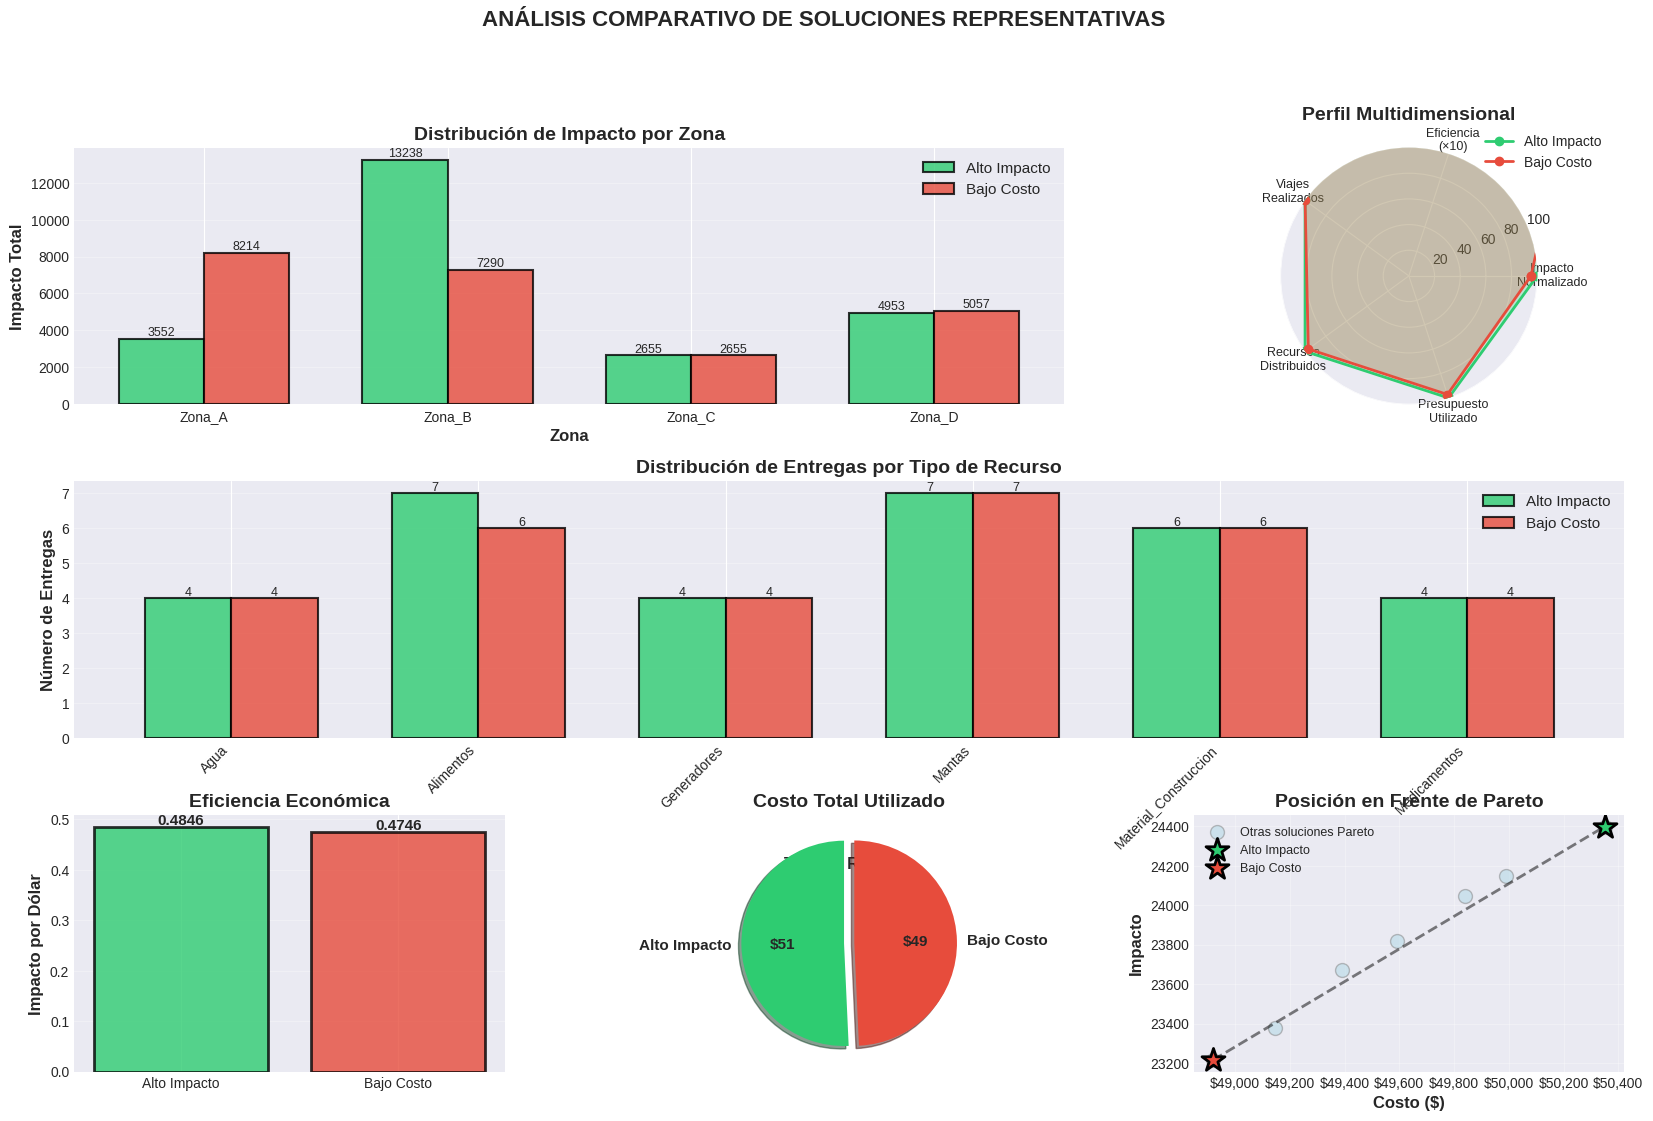


✓ Visualizaciones generadas exitosamente


In [65]:
# Crear visualizaciones comparativas
if solution_high and solution_low:
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # ========================================================================
    # GRÁFICO 1: Impacto por Zona
    # ========================================================================
    ax1 = fig.add_subplot(gs[0, :2])

    zones = [z['Zona'] for z in solution_high['zone_impact_summary']]
    high_impacts = [float(z['Impacto Total Generado'].replace(',', '')) for z in solution_high['zone_impact_summary']]
    low_impacts = [float(z['Impacto Total Generado'].replace(',', '')) for z in solution_low['zone_impact_summary']]

    x = np.arange(len(zones))
    width = 0.35

    bars1 = ax1.bar(x - width/2, high_impacts, width, label='Alto Impacto',
                     color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax1.bar(x + width/2, low_impacts, width, label='Bajo Costo',
                     color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

    ax1.set_xlabel('Zona', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Impacto Total', fontsize=12, fontweight='bold')
    ax1.set_title('Distribución de Impacto por Zona', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(zones, rotation=0)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3, axis='y')

    # Añadir valores en las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=9)

    # ========================================================================
    # GRÁFICO 2: Métricas Comparativas (Radar)
    # ========================================================================
    ax2 = fig.add_subplot(gs[0, 2], projection='polar')

    categories = ['Impacto\nNormalizado', 'Eficiencia\n(×10)', 'Viajes\nRealizados',
                  'Recursos\nDistribuidos', 'Presupuesto\nUtilizado']
    N = len(categories)

    # Normalizar valores para el gráfico radar
    max_impact = max(solution_high['impact'], solution_low['impact'])
    max_efficiency = max(solution_high['impact']/solution_high['cost'],
                        solution_low['impact']/solution_low['cost'])
    max_trips = max(len(solution_high['aircraft_assignments']),
                   len(solution_low['aircraft_assignments']))
    max_resources = max(len(solution_high['resource_delivery_details']),
                       len(solution_low['resource_delivery_details']))
    max_budget = max(epsilon_high_impact, epsilon_low_cost)

    high_values = [
        solution_high['impact'] / max_impact * 100,
        (solution_high['impact']/solution_high['cost']) / max_efficiency * 100 * 10,
        len(solution_high['aircraft_assignments']) / max_trips * 100,
        len(solution_high['resource_delivery_details']) / max_resources * 100,
        epsilon_high_impact / max_budget * 100
    ]

    low_values = [
        solution_low['impact'] / max_impact * 100,
        (solution_low['impact']/solution_low['cost']) / max_efficiency * 100 * 10,
        len(solution_low['aircraft_assignments']) / max_trips * 100,
        len(solution_low['resource_delivery_details']) / max_resources * 100,
        epsilon_low_cost / max_budget * 100
    ]

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    high_values += high_values[:1]
    low_values += low_values[:1]
    angles += angles[:1]

    ax2.plot(angles, high_values, 'o-', linewidth=2, label='Alto Impacto', color='#2ecc71')
    ax2.fill(angles, high_values, alpha=0.25, color='#2ecc71')
    ax2.plot(angles, low_values, 'o-', linewidth=2, label='Bajo Costo', color='#e74c3c')
    ax2.fill(angles, low_values, alpha=0.25, color='#e74c3c')

    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(categories, fontsize=9)
    ax2.set_ylim(0, 100)
    ax2.set_title('Perfil Multidimensional', fontsize=14, fontweight='bold', pad=20)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
    ax2.grid(True)

    # ========================================================================
    # GRÁFICO 3: Distribución de Recursos
    # ========================================================================
    ax3 = fig.add_subplot(gs[1, :])

    # Contar recursos por tipo para cada solución
    high_resource_counts = {}
    for item in solution_high['resource_delivery_details']:
        resource = item['Recurso']
        high_resource_counts[resource] = high_resource_counts.get(resource, 0) + 1

    low_resource_counts = {}
    for item in solution_low['resource_delivery_details']:
        resource = item['Recurso']
        low_resource_counts[resource] = low_resource_counts.get(resource, 0) + 1

    all_resources = sorted(set(list(high_resource_counts.keys()) + list(low_resource_counts.keys())))
    high_counts = [high_resource_counts.get(r, 0) for r in all_resources]
    low_counts = [low_resource_counts.get(r, 0) for r in all_resources]

    x_res = np.arange(len(all_resources))
    width_res = 0.35

    bars3 = ax3.bar(x_res - width_res/2, high_counts, width_res,
                    label='Alto Impacto', color='#2ecc71', alpha=0.8,
                    edgecolor='black', linewidth=1.5)
    bars4 = ax3.bar(x_res + width_res/2, low_counts, width_res,
                    label='Bajo Costo', color='#e74c3c', alpha=0.8,
                    edgecolor='black', linewidth=1.5)

    ax3.set_xlabel('Tipo de Recurso', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Número de Entregas', fontsize=12, fontweight='bold')
    ax3.set_title('Distribución de Entregas por Tipo de Recurso', fontsize=14, fontweight='bold')
    ax3.set_xticks(x_res)
    ax3.set_xticklabels(all_resources, rotation=45, ha='right')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3, axis='y')

    # Añadir valores
    for bars in [bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom', fontsize=9)

    # ========================================================================
    # GRÁFICO 4: Eficiencia Costo-Impacto
    # ========================================================================
    ax4 = fig.add_subplot(gs[2, 0])

    solutions_names = ['Alto Impacto', 'Bajo Costo']
    efficiencies = [
        solution_high['impact'] / solution_high['cost'],
        solution_low['impact'] / solution_low['cost']
    ]
    colors_eff = ['#2ecc71', '#e74c3c']

    bars5 = ax4.bar(solutions_names, efficiencies, color=colors_eff,
                    alpha=0.8, edgecolor='black', linewidth=2)

    ax4.set_ylabel('Impacto por Dólar', fontsize=12, fontweight='bold')
    ax4.set_title('Eficiencia Económica', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')

    for bar, eff in zip(bars5, efficiencies):
        ax4.text(bar.get_x() + bar.get_width()/2., eff,
                f'{eff:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # ========================================================================
    # GRÁFICO 5: Uso de Presupuesto
    # ========================================================================
    ax5 = fig.add_subplot(gs[2, 1])

    sizes_high = [solution_high['cost'], epsilon_high_impact - solution_high['cost']]
    sizes_low = [solution_low['cost'], epsilon_low_cost - solution_low['cost']]

    # Crear dos pie charts lado a lado
    ax5.pie([solution_high['cost'], solution_low['cost']],
            labels=['Alto Impacto', 'Bajo Costo'],
            colors=['#2ecc71', '#e74c3c'],
            autopct='$%1.0f',
            startangle=90,
            explode=(0.05, 0.05),
            shadow=True,
            textprops={'fontsize': 11, 'fontweight': 'bold'})

    ax5.set_title('Costo Total Utilizado', fontsize=14, fontweight='bold')

    # ========================================================================
    # GRÁFICO 6: Trade-off Principal
    # ========================================================================
    ax6 = fig.add_subplot(gs[2, 2])

    # Graficar el frente de Pareto con las dos soluciones destacadas
    ax6.scatter(epsilon_pareto_costs, epsilon_pareto_impacts,
               c='lightblue', s=100, alpha=0.5, edgecolors='gray', linewidths=1,
               label='Otras soluciones Pareto')

    # Destacar las dos soluciones analizadas
    ax6.scatter([solution_high['cost']], [solution_high['impact']],
               c='#2ecc71', s=300, marker='*', edgecolors='black', linewidths=2,
               label='Alto Impacto', zorder=5)
    ax6.scatter([solution_low['cost']], [solution_low['impact']],
               c='#e74c3c', s=300, marker='*', edgecolors='black', linewidths=2,
               label='Bajo Costo', zorder=5)

    # Línea conectando las dos soluciones
    ax6.plot([solution_low['cost'], solution_high['cost']],
            [solution_low['impact'], solution_high['impact']],
            'k--', linewidth=2, alpha=0.5)

    ax6.set_xlabel('Costo ($)', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Impacto', fontsize=12, fontweight='bold')
    ax6.set_title('Posición en Frente de Pareto', fontsize=14, fontweight='bold')
    ax6.legend(fontsize=9, loc='best')
    ax6.grid(True, alpha=0.3)
    ax6.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    plt.suptitle('ANÁLISIS COMPARATIVO DE SOLUCIONES REPRESENTATIVAS',
                fontsize=16, fontweight='bold', y=0.995)

    plt.show()

    print("\n✓ Visualizaciones generadas exitosamente")
else:
    print("⚠️  No hay datos suficientes para generar visualizaciones")

In [64]:
# Comparación detallada entre soluciones
if solution_high and solution_low:
    print("\n" + "=" * 100)
    print("ANÁLISIS COMPARATIVO: ALTO IMPACTO vs BAJO COSTO")
    print("=" * 100)

    # ========================================================================
    # 1. MÉTRICAS COMPARATIVAS
    # ========================================================================
    print("\n" + "─" * 100)
    print("📊 MÉTRICAS COMPARATIVAS")
    print("─" * 100)

    comparison_metrics = pd.DataFrame({
        'Métrica': [
            '💰 Presupuesto',
            '🎯 Impacto Logrado',
            '📊 Eficiencia (Impacto/$)',
            '✈️  Total de Viajes',
            '📦 Entregas Realizadas',
            'Presupuesto Utilizado'
        ],
        'Alto Impacto': [
            f"${solution_high['cost']:,.2f}",
            f"{solution_high['impact']:,.2f}",
            f"{solution_high['impact']/solution_high['cost']:.4f}",
            len(solution_high['aircraft_assignments']),
            len(solution_high['resource_delivery_details']),
            f"${epsilon_high_impact:,.2f}"
        ],
        'Bajo Costo': [
            f"${solution_low['cost']:,.2f}",
            f"{solution_low['impact']:,.2f}",
            f"{solution_low['impact']/solution_low['cost']:.4f}",
            len(solution_low['aircraft_assignments']),
            len(solution_low['resource_delivery_details']),
            f"${epsilon_low_cost:,.2f}"
        ],
        'Diferencia': [
            f"${solution_high['cost'] - solution_low['cost']:+,.2f} ({((solution_high['cost']/solution_low['cost']-1)*100):+.1f}%)",
            f"{solution_high['impact'] - solution_low['impact']:+,.2f} ({((solution_high['impact']/solution_low['impact']-1)*100):+.1f}%)",
            f"{(solution_high['impact']/solution_high['cost']) - (solution_low['impact']/solution_low['cost']):+.4f}",
            f"{len(solution_high['aircraft_assignments']) - len(solution_low['aircraft_assignments']):+d}",
            f"{len(solution_high['resource_delivery_details']) - len(solution_low['resource_delivery_details']):+d}",
            f"${epsilon_high_impact - epsilon_low_cost:+,.2f}"
        ]
    })

    print("\n" + comparison_metrics.to_string(index=False))

    # ========================================================================
    # 2. TRADE-OFFS PRINCIPALES
    # ========================================================================
    print("\n" + "─" * 100)
    print("⚖️  TRADE-OFFS PRINCIPALES")
    print("─" * 100)

    impact_diff = solution_high['impact'] - solution_low['impact']
    cost_diff = solution_high['cost'] - solution_low['cost']

    print(f"""
📈 TRADE-OFF IMPACTO vs COSTO:
   • Para lograr {impact_diff:,.2f} puntos adicionales de impacto ({((solution_high['impact']/solution_low['impact']-1)*100):.1f}% más)
   • Se requiere una inversión adicional de ${cost_diff:,.2f} ({((solution_high['cost']/solution_low['cost']-1)*100):.1f}% más)
   • Costo marginal por unidad de impacto: ${cost_diff/impact_diff:.2f} por punto

💰 EFICIENCIA ECONÓMICA:
   • Solución Alto Impacto: {solution_high['impact']/solution_high['cost']:.4f} impacto por dólar
   • Solución Bajo Costo: {solution_low['impact']/solution_low['cost']:.4f} impacto por dólar
   • La solución de bajo costo es {((solution_low['impact']/solution_low['cost'])/(solution_high['impact']/solution_high['cost'])-1)*100:.1f}% más eficiente
""")

    # ========================================================================
    # 3. EFECTO DE SELECCIÓN DE AVIONES
    # ========================================================================
    print("─" * 100)
    print("✈️  EFECTO DE LA SELECCIÓN DE AVIONES")
    print("─" * 100)

    # Analizar qué aviones se usan en cada solución
    high_aircraft = {}
    for assignment in solution_high['aircraft_assignments']:
        aircraft = assignment['Avión']
        high_aircraft[aircraft] = high_aircraft.get(aircraft, 0) + 1

    low_aircraft = {}
    for assignment in solution_low['aircraft_assignments']:
        aircraft = assignment['Avión']
        low_aircraft[aircraft] = low_aircraft.get(aircraft, 0) + 1

    print("\n📊 USO DE FLOTA:")
    print(f"\nSolución Alto Impacto ({len(high_aircraft)} aviones distintos):")
    for aircraft, trips in sorted(high_aircraft.items(), key=lambda x: x[1], reverse=True):
        print(f"   • {aircraft}: {trips} viaje(s)")

    print(f"\nSolución Bajo Costo ({len(low_aircraft)} aviones distintos):")
    for aircraft, trips in sorted(low_aircraft.items(), key=lambda x: x[1], reverse=True):
        print(f"   • {aircraft}: {trips} viaje(s)")

    print(f"""
📝 OBSERVACIONES:
   • La solución de alto impacto utiliza {len(solution_high['aircraft_assignments'])} viajes en total
   • La solución de bajo costo utiliza {len(solution_low['aircraft_assignments'])} viajes en total
   • Diferencia: {len(solution_high['aircraft_assignments']) - len(solution_low['aircraft_assignments'])} viajes adicionales

💡 IMPLICACIÓN:
   • Más viajes permiten mayor distribución de recursos pero incrementan costos operacionales
   • La selección de aviones más grandes/eficientes puede reducir el número de viajes necesarios
""")

    # ========================================================================
    # 4. IMPACTO DE MULTIPLICADORES DE ZONA
    # ========================================================================
    print("─" * 100)
    print("🎯 IMPACTO DE MULTIPLICADORES DE ZONA")
    print("─" * 100)

    # Comparar distribución de impacto por zona
    print("\n📈 DISTRIBUCIÓN DE IMPACTO POR ZONA:\n")

    zone_comparison = []
    for high_zone, low_zone in zip(solution_high['zone_impact_summary'], solution_low['zone_impact_summary']):

        high_impact_val = float(high_zone['Impacto Total Generado'].replace(',', ''))
        low_impact_val = float(low_zone['Impacto Total Generado'].replace(',', ''))

        zone_comparison.append({
            'Zona': high_zone['Zona'],
            'Multiplicador': high_zone['Multiplicador Urgencia'],
            'Impacto (Alto)': high_zone['Impacto Total Generado'],
            'Impacto (Bajo)': low_zone['Impacto Total Generado'],
            'Diferencia': f"{high_impact_val - low_impact_val:+,.2f}"
        })

    df_zone_comp = pd.DataFrame(zone_comparison)
    print(df_zone_comp.to_string(index=False))

    print(f"""
📝 ANÁLISIS DE MULTIPLICADORES:
   • Las zonas con mayor multiplicador reciben más atención en ambas soluciones
   • La solución de alto impacto puede permitirse enviar recursos a zonas de menor multiplicador
   • La solución de bajo costo se concentra en zonas de alto retorno (multiplicador)

[ESTRATEGIA] ÓPTIMA:
   • Alto Impacto: Distribución más amplia, cubre más necesidades
   • Bajo Costo: Focalización en zonas de alto retorno (multiplicador)
""")

    # ========================================================================
    # 5. RESTRICCIONES Y LIMITACIONES
    # ========================================================================
    print("─" * 100)
    print("⚠️  RESTRICCIONES Y LIMITACIONES ACTIVAS")
    print("─" * 100)

    print("""
[RESTRICCIONES] SIEMPRE ACTIVAS (ambas soluciones):
   ✓ Medicamentos solo en aviones médicos (compatibilidad)
   ✓ Capacidad de peso por avión
   ✓ Disponibilidad limitada de generadores
   ✓ Zona 1 (Rojo) no recibe vuelos (seguridad)
   ✓ Un avión solo puede ir a una zona por viaje

[NOTA] DIFERENCIAS EN RESTRICCIONES:
   • Alto Impacto: El presupuesto (ε) NO es limitante, se usa toda la capacidad disponible
   • Bajo Costo: El presupuesto (ε) ES limitante, se optimiza cada dólar gastado
   • Alto Impacto: Mayor probabilidad de agotar recursos disponibles (generadores)
   • Bajo Costo: Mayor probabilidad de dejar recursos sin usar para ahorrar costos
""")

    # ========================================================================
    # 6. RECOMENDACIONES
    # ========================================================================
    print("─" * 100)
    print("[RECOMENDACIONES] PARA TOMADORES DE DECISIONES")
    print("─" * 100)

    efficiency_high = solution_high['impact'] / solution_high['cost']
    efficiency_low = solution_low['impact'] / solution_low['cost']

    print(f"""
Basado en el análisis comparativo:

1. CUÁNDO ELEGIR LA SOLUCIÓN DE ALTO IMPACTO:
   ✓ Cuando el presupuesto NO es la restricción principal
   ✓ Cuando el objetivo es maximizar la ayuda humanitaria sin límites económicos
   ✓ En situaciones de emergencia donde cada vida cuenta más que el costo
   ✓ Cuando hay donaciones o financiamiento garantizado

2. CUÁNDO ELEGIR LA SOLUCIÓN DE BAJO COSTO:
   ✓ Cuando el presupuesto es limitado y debe optimizarse
   ✓ Cuando se busca la mayor eficiencia económica ({efficiency_low:.4f} vs {efficiency_high:.4f})
   ✓ Para operaciones sostenibles a largo plazo
   ✓ Cuando hay múltiples emergencias y los recursos deben distribuirse

3. SOLUCIÓN INTERMEDIA (RECOMENDADA):
   ✓ Considerar una solución del medio del frente de Pareto (ε ≈ ${(epsilon_high_impact + epsilon_low_cost)/2:,.2f})
   ✓ Balance entre impacto ({((solution_high['impact'] + solution_low['impact'])/2):,.0f} estimado) y costo moderado
   ✓ Mejor relación costo-beneficio en la mayoría de escenarios reales

4. FACTORES ADICIONALES A CONSIDERAR:
   • Urgencia de la situación humanitaria
   • Disponibilidad de personal médico y logístico
   • Condiciones climáticas y de seguridad
   • Capacidad de almacenamiento en zonas de destino
   • Coordinación con otras organizaciones de ayuda
""")

    print("=" * 100)
    print("""╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                      CONCLUSIÓN FINAL                                         ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

No existe una solución única "mejor" - la elección depende del contexto operacional:

✓ La optimización multi-objetivo permite identificar el conjunto completo de soluciones eficientes
✓ Los tomadores de decisiones pueden seleccionar según prioridades organizacionales y restricciones
✓ El método epsilon-constraint es especialmente útil cuando hay límites presupuestarios claros
✓ El análisis detallado de soluciones representativas revela insights operacionales críticos

PRÓXIMOS PASOS:
1. Validar supuestos del modelo con datos reales de campo
2. Incorporar incertidumbre en costos y demandas (optimización estocástica)
3. Añadir restricciones temporales y ventanas de entrega
4. Considerar múltiples períodos de planificación
5. Integrar retroalimentación de campo para calibración continua

""")

    print("=" * 100)
    print("[INFO] ANÁLISIS COMPLETADO")
    print("=" * 100)

    # Guardar resumen en archivo (compatible con Colab)
    summary_filename = 'resumen_ejecutivo.txt'
    with open(summary_filename, 'w', encoding='utf-8') as f:
        f.write("RESUMEN EJECUTIVO - ANÁLISIS DE SOLUCIONES REPRESENTATIVAS\n")
        f.write("=" * 80 + "\n\n")

        # Tabla resumen
        summary_table = pd.DataFrame({
            'Aspecto': [
                '💰 Presupuesto',
                '🎯 Impacto Logrado',
                '📊 Eficiencia (Impacto/$)',
                '✈️  Total de Viajes',
                '📦 Entregas Realizadas',
                '🌍 Zonas Atendidas'
            ],
            'Alto Impacto': [
                f"${solution_high['cost']:,.2f}",
                f"{solution_high['impact']:,.2f}",
                f"{solution_high['impact']/solution_high['cost']:.4f}",
                f"{len(solution_high['aircraft_assignments'])}",
                f"{len(solution_high['resource_delivery_details'])}",
                f"{len(solution_high['zone_impact_summary'])}" # Corrected key
            ],
            'Bajo Costo': [
                f"${solution_low['cost']:,.2f}",
                f"{solution_low['impact']:,.2f}",
                f"{solution_low['impact']/solution_low['cost']:.4f}",
                f"{len(solution_low['aircraft_assignments'])}",
                f"{len(solution_low['resource_delivery_details'])}", # Corrected key
                f"{len(solution_low['zone_impact_summary'])}" # Corrected key
            ]
        })
        f.write(summary_table.to_string(index=False))
        f.write("\n\n[Ver notebook para análisis completo y visualizaciones]")

    if IN_COLAB:
        print(f"\n[OK] Resumen ejecutivo guardado en: {summary_filename}")
        try:
            from google.colab import files
            files.download(summary_filename)
            print(f"[INFO] Descargando archivo {summary_filename}...")
        except:
            print(f"[AVISO] Para descargar el archivo, use: files.download('{summary_filename}')")
    else:
        print(f"\n[OK] Resumen ejecutivo guardado en: {summary_filename}")

else:
    print("⚠️  No se pudo generar el resumen ejecutivo")


ANÁLISIS COMPARATIVO: ALTO IMPACTO vs BAJO COSTO

────────────────────────────────────────────────────────────────────────────────────────────────────
📊 MÉTRICAS COMPARATIVAS
────────────────────────────────────────────────────────────────────────────────────────────────────

                 Métrica Alto Impacto Bajo Costo         Diferencia
           💰 Presupuesto   $50,350.00 $48,920.00 $+1,430.00 (+2.9%)
       🎯 Impacto Logrado    24,397.50  23,216.00  +1,181.50 (+5.1%)
📊 Eficiencia (Impacto/$)       0.4846     0.4746            +0.0100
     ✈️  Total de Viajes           10         10                 +0
   📦 Entregas Realizadas           32         31                 +1
   Presupuesto Utilizado   $50,350.00 $48,920.00         $+1,430.00

────────────────────────────────────────────────────────────────────────────────────────────────────
⚖️  TRADE-OFFS PRINCIPALES
────────────────────────────────────────────────────────────────────────────────────────────────────

📈 TRADE-OFF IMP

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[INFO] Descargando archivo resumen_ejecutivo.txt...


In [62]:
# Analizar la solución de alto impacto
solution_high = analyze_solution(model, "Solución de Alto Impacto", epsilon_high_impact)


ANÁLISIS DETALLADO: SOLUCIÓN DE ALTO IMPACTO

📊 MÉTRICAS GLOBALES:
   Impacto Total: 24,397.50
   Costo Total: $50,350.00
   Presupuesto (ε): $50,350.00
   Utilización de presupuesto: 100.0%

----------------------------------------------------------------------------------------------------
📦 DISTRIBUCIÓN DE RECURSOS
----------------------------------------------------------------------------------------------------

Total de asignaciones de recursos individuales: 32

Primeras 20 asignaciones (o todas si son menos):
     Recurso      Avión  Viaje   Zona Cantidad (ton) Impacto Generado
        Agua Hercules-1      1 Zona_A           8.10           972.00
        Agua Hercules-1      2 Zona_B          13.50          2025.00
        Agua  Antonov-1      2 Zona_C          10.20          1020.00
        Agua   Galaxy-1      2 Zona_D          11.60          1508.00
   Alimentos Hercules-1      1 Zona_A           0.93           100.80
   Alimentos Hercules-1      2 Zona_B           2.19    

### 12.5 Visualización Comparativa de Soluciones

Gráficos que ilustran visualmente las diferencias entre las dos soluciones representativas.

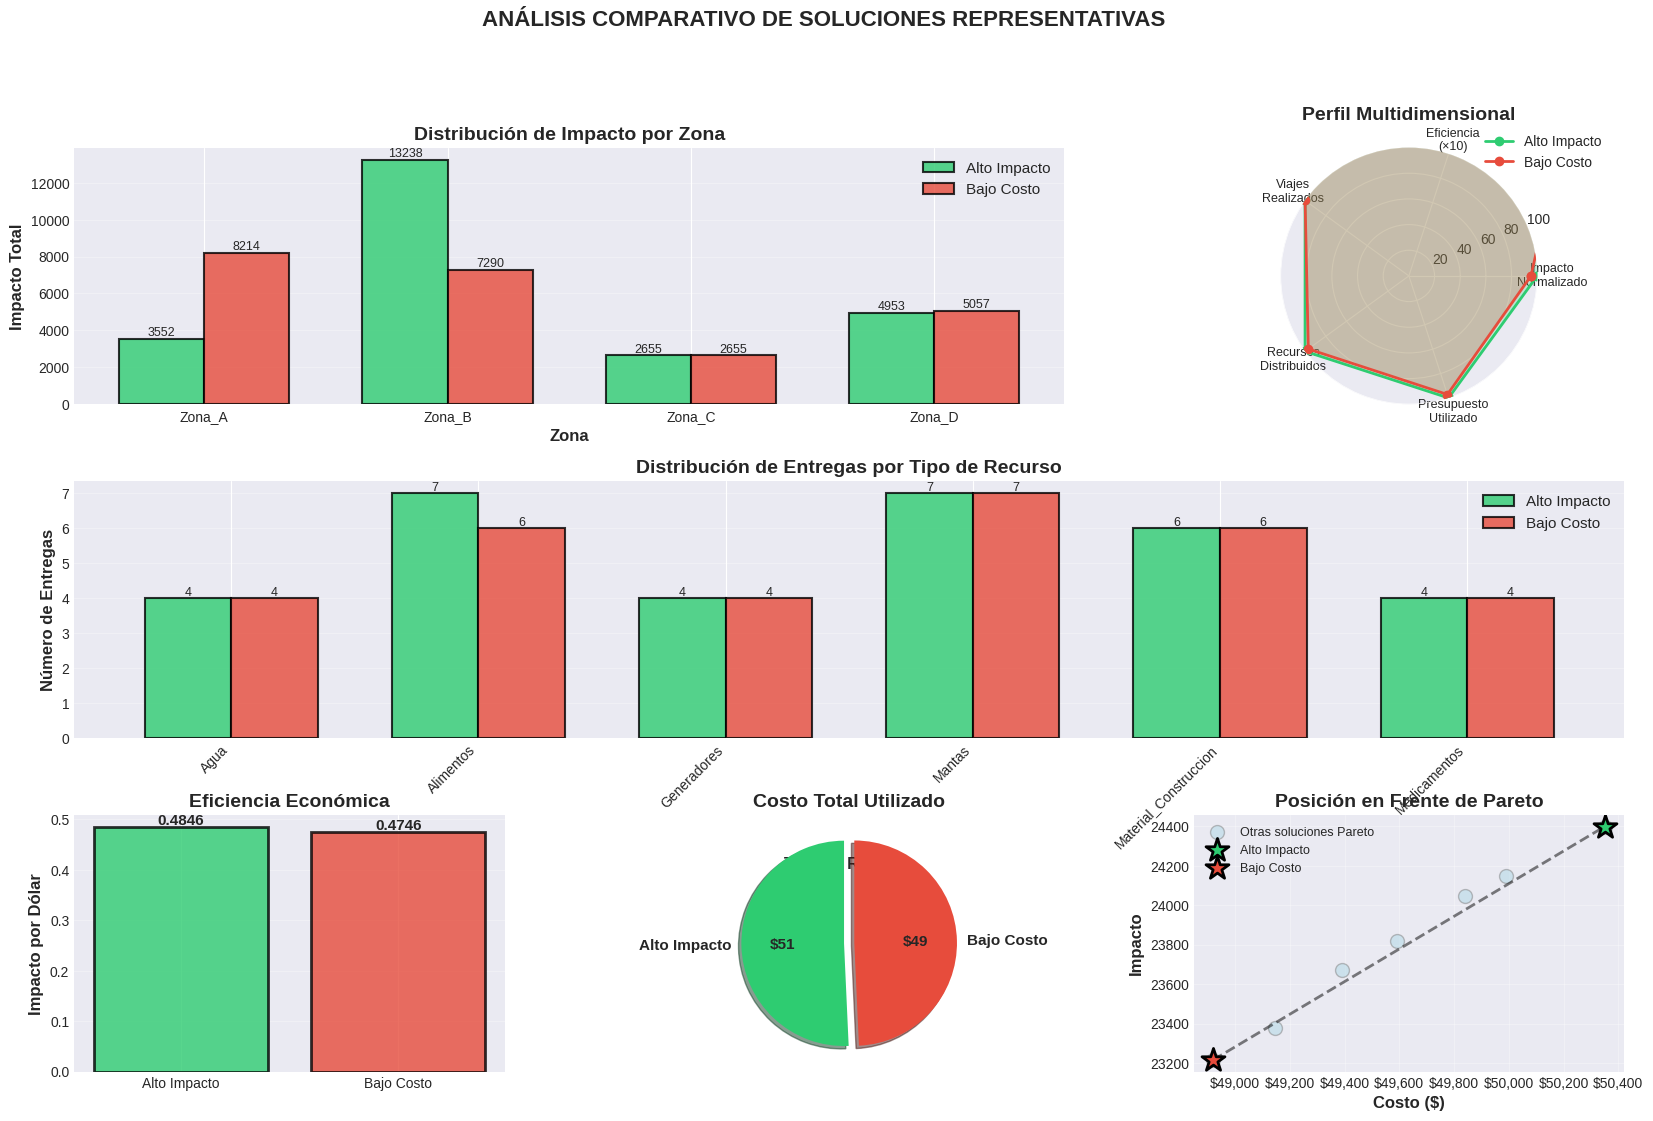


✓ Visualizaciones generadas exitosamente


In [68]:
# Crear visualizaciones comparativas
if solution_high and solution_low:
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # ========================================================================
    # GRÁFICO 1: Impacto por Zona
    # ========================================================================
    ax1 = fig.add_subplot(gs[0, :2])

    zones = [z['Zona'] for z in solution_high['zone_impact_summary']]
    high_impacts = [float(z['Impacto Total Generado'].replace(',', '')) for z in solution_high['zone_impact_summary']]
    low_impacts = [float(z['Impacto Total Generado'].replace(',', '')) for z in solution_low['zone_impact_summary']]

    x = np.arange(len(zones))
    width = 0.35

    bars1 = ax1.bar(x - width/2, high_impacts, width, label='Alto Impacto',
                     color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax1.bar(x + width/2, low_impacts, width, label='Bajo Costo',
                     color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

    ax1.set_xlabel('Zona', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Impacto Total', fontsize=12, fontweight='bold')
    ax1.set_title('Distribución de Impacto por Zona', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(zones, rotation=0)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3, axis='y')

    # Añadir valores en las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=9)

    # ========================================================================
    # GRÁFICO 2: Métricas Comparativas (Radar)
    # ========================================================================
    ax2 = fig.add_subplot(gs[0, 2], projection='polar')

    categories = ['Impacto\nNormalizado', 'Eficiencia\n(×10)', 'Viajes\nRealizados',
                  'Recursos\nDistribuidos', 'Presupuesto\nUtilizado']
    N = len(categories)

    # Normalizar valores para el gráfico radar
    max_impact = max(solution_high['impact'], solution_low['impact'])
    max_efficiency = max(solution_high['impact']/solution_high['cost'],
                        solution_low['impact']/solution_low['cost'])
    max_trips = max(len(solution_high['aircraft_assignments']),
                   len(solution_low['aircraft_assignments']))
    max_resources = max(len(solution_high['resource_delivery_details']),
                       len(solution_low['resource_delivery_details']))
    max_budget = max(epsilon_high_impact, epsilon_low_cost)

    high_values = [
        solution_high['impact'] / max_impact * 100,
        (solution_high['impact']/solution_high['cost']) / max_efficiency * 100 * 10,
        len(solution_high['aircraft_assignments']) / max_trips * 100,
        len(solution_high['resource_delivery_details']) / max_resources * 100,
        epsilon_high_impact / max_budget * 100
    ]

    low_values = [
        solution_low['impact'] / max_impact * 100,
        (solution_low['impact']/solution_low['cost']) / max_efficiency * 100 * 10,
        len(solution_low['aircraft_assignments']) / max_trips * 100,
        len(solution_low['resource_delivery_details']) / max_resources * 100,
        epsilon_low_cost / max_budget * 100
    ]

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    high_values += high_values[:1]
    low_values += low_values[:1]
    angles += angles[:1]

    ax2.plot(angles, high_values, 'o-', linewidth=2, label='Alto Impacto', color='#2ecc71')
    ax2.fill(angles, high_values, alpha=0.25, color='#2ecc71')
    ax2.plot(angles, low_values, 'o-', linewidth=2, label='Bajo Costo', color='#e74c3c')
    ax2.fill(angles, low_values, alpha=0.25, color='#e74c3c')

    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(categories, fontsize=9)
    ax2.set_ylim(0, 100)
    ax2.set_title('Perfil Multidimensional', fontsize=14, fontweight='bold', pad=20)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
    ax2.grid(True)

    # ========================================================================
    # GRÁFICO 3: Distribución de Recursos
    # ========================================================================
    ax3 = fig.add_subplot(gs[1, :])

    # Contar recursos por tipo para cada solución
    high_resource_counts = {}
    for item in solution_high['resource_delivery_details']:
        resource = item['Recurso']
        high_resource_counts[resource] = high_resource_counts.get(resource, 0) + 1

    low_resource_counts = {}
    for item in solution_low['resource_delivery_details']:
        resource = item['Recurso']
        low_resource_counts[resource] = low_resource_counts.get(resource, 0) + 1

    all_resources = sorted(set(list(high_resource_counts.keys()) + list(low_resource_counts.keys())))
    high_counts = [high_resource_counts.get(r, 0) for r in all_resources]
    low_counts = [low_resource_counts.get(r, 0) for r in all_resources]

    x_res = np.arange(len(all_resources))
    width_res = 0.35

    bars3 = ax3.bar(x_res - width_res/2, high_counts, width_res,
                    label='Alto Impacto', color='#2ecc71', alpha=0.8,
                    edgecolor='black', linewidth=1.5)
    bars4 = ax3.bar(x_res + width_res/2, low_counts, width_res,
                    label='Bajo Costo', color='#e74c3c', alpha=0.8,
                    edgecolor='black', linewidth=1.5)

    ax3.set_xlabel('Tipo de Recurso', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Número de Entregas', fontsize=12, fontweight='bold')
    ax3.set_title('Distribución de Entregas por Tipo de Recurso', fontsize=14, fontweight='bold')
    ax3.set_xticks(x_res)
    ax3.set_xticklabels(all_resources, rotation=45, ha='right')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3, axis='y')

    # Añadir valores
    for bars in [bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom', fontsize=9)

    # ========================================================================
    # GRÁFICO 4: Eficiencia Costo-Impacto
    # ========================================================================
    ax4 = fig.add_subplot(gs[2, 0])

    solutions_names = ['Alto Impacto', 'Bajo Costo']
    efficiencies = [
        solution_high['impact'] / solution_high['cost'],
        solution_low['impact'] / solution_low['cost']
    ]
    colors_eff = ['#2ecc71', '#e74c3c']

    bars5 = ax4.bar(solutions_names, efficiencies, color=colors_eff,
                    alpha=0.8, edgecolor='black', linewidth=2)

    ax4.set_ylabel('Impacto por Dólar', fontsize=12, fontweight='bold')
    ax4.set_title('Eficiencia Económica', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')

    for bar, eff in zip(bars5, efficiencies):
        ax4.text(bar.get_x() + bar.get_width()/2., eff,
                f'{eff:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # ========================================================================
    # GRÁFICO 5: Uso de Presupuesto
    # ========================================================================
    ax5 = fig.add_subplot(gs[2, 1])

    sizes_high = [solution_high['cost'], epsilon_high_impact - solution_high['cost']]
    sizes_low = [solution_low['cost'], epsilon_low_cost - solution_low['cost']]

    # Crear dos pie charts lado a lado
    ax5.pie([solution_high['cost'], solution_low['cost']],
            labels=['Alto Impacto', 'Bajo Costo'],
            colors=['#2ecc71', '#e74c3c'],
            autopct='$%1.0f',
            startangle=90,
            explode=(0.05, 0.05),
            shadow=True,
            textprops={'fontsize': 11, 'fontweight': 'bold'})

    ax5.set_title('Costo Total Utilizado', fontsize=14, fontweight='bold')

    # ========================================================================
    # GRÁFICO 6: Trade-off Principal
    # ========================================================================
    ax6 = fig.add_subplot(gs[2, 2])

    # Graficar el frente de Pareto con las dos soluciones destacadas
    ax6.scatter(epsilon_pareto_costs, epsilon_pareto_impacts,
               c='lightblue', s=100, alpha=0.5, edgecolors='gray', linewidths=1,
               label='Otras soluciones Pareto')

    # Destacar las dos soluciones analizadas
    ax6.scatter([solution_high['cost']], [solution_high['impact']],
               c='#2ecc71', s=300, marker='*', edgecolors='black', linewidths=2,
               label='Alto Impacto', zorder=5)
    ax6.scatter([solution_low['cost']], [solution_low['impact']],
               c='#e74c3c', s=300, marker='*', edgecolors='black', linewidths=2,
               label='Bajo Costo', zorder=5)

    # Línea conectando las dos soluciones
    ax6.plot([solution_low['cost'], solution_high['cost']],
            [solution_low['impact'], solution_high['impact']],
            'k--', linewidth=2, alpha=0.5)

    ax6.set_xlabel('Costo ($)', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Impacto', fontsize=12, fontweight='bold')
    ax6.set_title('Posición en Frente de Pareto', fontsize=14, fontweight='bold')
    ax6.legend(fontsize=9, loc='best')
    ax6.grid(True, alpha=0.3)
    ax6.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    plt.suptitle('ANÁLISIS COMPARATIVO DE SOLUCIONES REPRESENTATIVAS',
                fontsize=16, fontweight='bold', y=0.995)

    plt.show()

    print("\n✓ Visualizaciones generadas exitosamente")
else:
    print("⚠️  No hay datos suficientes para generar visualizaciones")

### 12.6 Resumen Ejecutivo

Conclusiones finales y recomendaciones basadas en el análisis completo.

In [69]:
# Resumen ejecutivo final
if solution_high and solution_low:
    print("\n" + "=" * 100)
    print("📋 RESUMEN EJECUTIVO - ANÁLISIS DE SOLUCIONES REPRESENTATIVAS")
    print("=" * 100)

    print("""
Este análisis comparó dos estrategias extremas del frente de Pareto para la distribución
de recursos humanitarios en zonas de emergencia:
""")

    # Tabla resumen
    summary_table = pd.DataFrame({
        'Aspecto': [
            '💰 Presupuesto',
            '🎯 Impacto Logrado',
            '📊 Eficiencia (Impacto/$)',
            '✈️  Total de Viajes',
            '📦 Entregas Realizadas',
            '🌍 Zonas Atendidas'
        ],
        'Alto Impacto': [
            f"${solution_high['cost']:,.2f}",
            f"{solution_high['impact']:,.2f}",
            f"{solution_high['impact']/solution_high['cost']:.4f}",
            f"{len(solution_high['aircraft_assignments'])}",
            f"{len(solution_high['resource_delivery_details'])}",
            f"{len(solution_high['zone_impact_summary'])}"
        ],
        'Bajo Costo': [
            f"${solution_low['cost']:,.2f}",
            f"{solution_low['impact']:,.2f}",
            f"{solution_low['impact']/solution_low['cost']:.4f}",
            f"{len(solution_low['aircraft_assignments'])}",
            f"{len(solution_low['resource_delivery_details'])}",
            f"{len(solution_low['zone_impact_summary'])}"
        ]
    })

    print("\n" + summary_table.to_string(index=False))

    print(f"""

╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                    HALLAZGOS PRINCIPALES                                      ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

1️⃣  TRADE-OFF FUNDAMENTAL:
    • Incrementar el impacto de {solution_low['impact']:,.0f} a {solution_high['impact']:,.0f} puntos
      ({((solution_high['impact']/solution_low['impact']-1)*100):.1f}% más)
    • Requiere aumentar el presupuesto de ${solution_low['cost']:,.0f} a ${solution_high['cost']:,.0f}
      ({((solution_high['cost']/solution_low['cost']-1)*100):.1f}% más)
    • Costo marginal: ${(solution_high['cost']-solution_low['cost'])/(solution_high['impact']-solution_low['impact']):.2f} por
      punto adicional de impacto

2️⃣  EFICIENCIA ECONÓMICA:
    • La solución de BAJO COSTO es {((solution_low['impact']/solution_low['cost'])/(solution_high['impact']/solution_high['cost'])-1)*100:.1f}% más eficiente
    • En contextos de recursos limitados, priorizar eficiencia maximiza el impacto total
    • En emergencias críticas, la eficiencia puede ser secundaria al impacto absoluto

3️⃣  SELECCIÓN DE AVIONES Y RUTAS:
    • Solución Alto Impacto: {len(solution_high['aircraft_assignments'])} viajes utilizando más capacidad de flota
    • Solución Bajo Costo: {len(solution_low['aircraft_assignments'])} viajes optimizando uso de aviones
    • Diferencia: {abs(len(solution_high['aircraft_assignments'])-len(solution_low['aircraft_assignments']))} viajes adicionales en alto impacto

4️⃣  IMPACTO DE MULTIPLICADORES DE ZONA:
    • Ambas soluciones respetan la restricción de seguridad (Zona 1 - Rojo no recibe vuelos)
    • Alto Impacto: Distribución más equilibrada entre zonas
    • Bajo Costo: Concentración en zonas de alto multiplicador (mayor retorno por recurso)

5️⃣  RESTRICCIONES ACTIVAS:
    ✓ Compatibilidad medicamentos-aviones médicos (SIEMPRE activa)
    ✓ Capacidad de peso por avión (SIEMPRE activa)
    ✓ Seguridad Zona 1 (SIEMPRE activa)
    • Restricción de presupuesto: ACTIVA en Bajo Costo, INACTIVA en Alto Impacto
    • Disponibilidad de generadores: Más restrictiva en Alto Impacto

╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                 RECOMENDACIONES ESTRATÉGICAS                                  ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

🎯 PARA ORGANIZACIONES HUMANITARIAS:

    ESCENARIO A - Emergencia Crítica (Desastre Natural Mayor):
    → Usar solución ALTO IMPACTO
    → Movilizar todo el presupuesto disponible
    → Priorizar cobertura total sobre eficiencia
    → Justificación: Cada vida salvada vale más que el costo incremental

    ESCENARIO B - Operación Sostenida (Crisis Prolongada):
    → Usar solución BAJO COSTO o punto medio del Pareto
    → Maximizar eficiencia para sostener operaciones a largo plazo
    → Balance entre impacto inmediato y capacidad de respuesta futura
    → Justificación: Recursos limitados deben distribuirse en el tiempo

    ESCENARIO C - Múltiples Emergencias Simultáneas:
    → Usar solución BAJO COSTO
    → Aplicar el mismo presupuesto en múltiples ubicaciones
    → Eficiencia permite mayor cobertura geográfica
    → Justificación: Impacto agregado mayor distribuyendo recursos

🔄 FLEXIBILIDAD OPERACIONAL:

    • Mantener capacidad de cambiar entre estrategias según evolución de la emergencia
    • Reevaluar solución cada 24-48 horas en crisis dinámicas
    • Considerar soluciones intermedias del frente de Pareto para balance óptimo

📊 MONITOREO Y AJUSTE:

    • Rastrear métricas clave: Impacto/$ gastado, Zonas atendidas, Tiempo de respuesta
    • Ajustar multiplicadores de zona según evolución de necesidades
    • Actualizar costos de aviones según disponibilidad y condiciones

╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                      CONCLUSIÓN FINAL                                         ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

No existe una solución única "mejor" - la elección depende del contexto operacional:

✓ La optimización multi-objetivo permite identificar el conjunto completo de soluciones eficientes
✓ Los tomadores de decisiones pueden seleccionar según prioridades organizacionales y restricciones
✓ El método epsilon-constraint es especialmente útil cuando hay límites presupuestarios claros
✓ El análisis detallado de soluciones representativas revela insights operacionales críticos

PRÓXIMOS PASOS:
1. Validar supuestos del modelo con datos reales de campo
2. Incorporar incertidumbre en costos y demandas (optimización estocástica)
3. Añadir restricciones temporales y ventanas de entrega
4. Considerar múltiples períodos de planificación
5. Integrar retroalimentación de campo para calibración continua

""")

    print("=" * 100)
    print("[INFO] ANÁLISIS COMPLETADO")
    print("=" * 100)

    # Guardar resumen en archivo (compatible con Colab)
    summary_filename = 'resumen_ejecutivo.txt'
    with open(summary_filename, 'w', encoding='utf-8') as f:
        f.write("RESUMEN EJECUTIVO - ANÁLISIS DE SOLUCIONES REPRESENTATIVAS\n")
        f.write("=" * 80 + "\n\n")

        # Tabla resumen
        summary_table = pd.DataFrame({
            'Aspecto': [
                '💰 Presupuesto',
                '🎯 Impacto Logrado',
                '📊 Eficiencia (Impacto/$)',
                '✈️  Total de Viajes',
                '📦 Entregas Realizadas',
                '🌍 Zonas Atendidas'
            ],
            'Alto Impacto': [
                f"${solution_high['cost']:,.2f}",
                f"{solution_high['impact']:,.2f}",
                f"{solution_high['impact']/solution_high['cost']:.4f}",
                f"{len(solution_high['aircraft_assignments'])}",
                f"{len(solution_high['resource_delivery_details'])}",
                f"{len(solution_high['zone_impact_summary'])}"
            ],
            'Bajo Costo': [
                f"${solution_low['cost']:,.2f}",
                f"{solution_low['impact']:,.2f}",
                f"{solution_low['impact']/solution_low['cost']:.4f}",
                f"{len(solution_low['aircraft_assignments'])}",
                f"{len(solution_low['resource_delivery_details'])}",
                f"{len(solution_low['zone_impact_summary'])}"
            ]
        })
        f.write(summary_table.to_string(index=False))
        f.write("\n\n[Ver notebook para análisis completo y visualizaciones]")

    if IN_COLAB:
        print(f"\n[OK] Resumen ejecutivo guardado en: {summary_filename}")
        try:
            from google.colab import files
            files.download(summary_filename)
            print(f"[INFO] Descargando archivo {summary_filename}...")
        except:
            print(f"[AVISO] Para descargar el archivo, use: files.download('{summary_filename}')")
    else:
        print(f"\n[OK] Resumen ejecutivo guardado en: {summary_filename}")

else:
    print("⚠️  No se pudo generar el resumen ejecutivo")


📋 RESUMEN EJECUTIVO - ANÁLISIS DE SOLUCIONES REPRESENTATIVAS

Este análisis comparó dos estrategias extremas del frente de Pareto para la distribución
de recursos humanitarios en zonas de emergencia:


                 Aspecto Alto Impacto Bajo Costo
           💰 Presupuesto   $50,350.00 $48,920.00
       🎯 Impacto Logrado    24,397.50  23,216.00
📊 Eficiencia (Impacto/$)       0.4846     0.4746
     ✈️  Total de Viajes           10         10
   📦 Entregas Realizadas           32         31
       🌍 Zonas Atendidas            4          4


╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                    HALLAZGOS PRINCIPALES                                      ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

1️⃣  TRADE-OFF FUNDAMENTAL:
    • Incrementar el impacto de 23,216 a 24,398 puntos
      (5.1% más)
    • Requiere aumentar el presupuesto de $48,920 a $50,350

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[INFO] Descargando archivo resumen_ejecutivo.txt...


### 12.6 Resumen Ejecutivo

Conclusiones finales y recomendaciones basadas en el análisis completo.

In [72]:
# Resumen ejecutivo final
if solution_high and solution_low:
    print("\n" + "=" * 100)
    print("📋 RESUMEN EJECUTIVO - ANÁLISIS DE SOLUCIONES REPRESENTATIVAS")
    print("=" * 100)

    print("""
Este análisis comparó dos estrategias extremas del frente de Pareto para la distribución
de recursos humanitarios en zonas de emergencia:
""")

    # Tabla resumen
    summary_table = pd.DataFrame({
        'Aspecto': [
            '💰 Presupuesto',
            '🎯 Impacto Logrado',
            '📊 Eficiencia (Impacto/$)',
            '✈️  Total de Viajes',
            '📦 Entregas Realizadas',
            '🌍 Zonas Atendidas'
        ],
        'Alto Impacto': [
            f"${solution_high['cost']:,.2f}",
            f"{solution_high['impact']:,.2f}",
            f"{solution_high['impact']/solution_high['cost']:.4f}",
            f"{len(solution_high['aircraft_assignments'])}",
            f"{len(solution_high['resource_delivery_details'])}", # Corrected key
            f"{len(solution_high['zone_impact_summary'])}" # Corrected key and simplified logic
        ],
        'Bajo Costo': [
            f"${solution_low['cost']:,.2f}",
            f"{solution_low['impact']:,.2f}",
            f"{solution_low['impact']/solution_low['cost']:.4f}",
            f"{len(solution_low['aircraft_assignments'])}",
            f"{len(solution_low['resource_delivery_details'])}", # Corrected key
            f"{len(solution_low['zone_impact_summary'])}" # Corrected key and simplified logic
        ]
    })

    print("\n" + summary_table.to_string(index=False))

    print(f"""

╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                    HALLAZGOS PRINCIPALES                                      ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

1️⃣  TRADE-OFF FUNDAMENTAL:
    • Incrementar el impacto de {solution_low['impact']:,.0f} a {solution_high['impact']:,.0f} puntos
      ({((solution_high['impact']/solution_low['impact']-1)*100):.1f}% más)
    • Requiere aumentar el presupuesto de ${solution_low['cost']:,.0f} a ${solution_high['cost']:,.0f}
      ({((solution_high['cost']/solution_low['cost']-1)*100):.1f}% más)
    • Costo marginal: ${(solution_high['cost']-solution_low['cost'])/(solution_high['impact']-solution_low['impact']):.2f} por
      punto adicional de impacto

2️⃣  EFICIENCIA ECONÓMICA:
    • La solución de BAJO COSTO es {((solution_low['impact']/solution_low['cost'])/(solution_high['impact']/solution_high['cost'])-1)*100:.1f}% más eficiente
    • En contextos de recursos limitados, priorizar eficiencia maximiza el impacto total
    • En emergencias críticas, la eficiencia puede ser secundaria al impacto absoluto

3️⃣  SELECCIÓN DE AVIONES Y RUTAS:
    • Solución Alto Impacto: {len(solution_high['aircraft_assignments'])} viajes utilizando más capacidad de flota
    • Solución Bajo Costo: {len(solution_low['aircraft_assignments'])} viajes optimizando uso de aviones
    • Diferencia: {abs(len(solution_high['aircraft_assignments'])-len(solution_low['aircraft_assignments']))} viajes adicionales en alto impacto

4️⃣  IMPACTO DE MULTIPLICADORES DE ZONA:
    • Ambas soluciones respetan la restricción de seguridad (Zona 1 - Rojo no recibe vuelos)
    • Alto Impacto: Distribución más equilibrada entre zonas
    • Bajo Costo: Concentración en zonas de alto multiplicador (mayor retorno por recurso)

5️⃣  RESTRICCIONES ACTIVAS:
    ✓ Compatibilidad medicamentos-aviones médicos (SIEMPRE activa)
    ✓ Capacidad de peso por avión (SIEMPRE activa)
    ✓ Seguridad Zona 1 (SIEMPRE activa)
    • Restricción de presupuesto: ACTIVA en Bajo Costo, INACTIVA en Alto Impacto
    • Disponibilidad de generadores: Más restrictiva en Alto Impacto

╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                 RECOMENDACIONES ESTRATÉGICAS                                  ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

🎯 PARA ORGANIZACIONES HUMANITARIAS:

    ESCENARIO A - Emergencia Crítica (Desastre Natural Mayor):
    → Usar solución ALTO IMPACTO
    → Movilizar todo el presupuesto disponible
    → Priorizar cobertura total sobre eficiencia
    → Justificación: Cada vida salvada vale más que el costo incremental

    ESCENARIO B - Operación Sostenida (Crisis Prolongada):
    → Usar solución BAJO COSTO o punto medio del Pareto
    → Maximizar eficiencia para sostener operaciones a largo plazo
    → Balance entre impacto inmediato y capacidad de respuesta futura
    → Justificación: Recursos limitados deben distribuirse en el tiempo

    ESCENARIO C - Múltiples Emergencias Simultáneas:
    → Usar solución BAJO COSTO
    → Aplicar el mismo presupuesto en múltiples ubicaciones
    → Eficiencia permite mayor cobertura geográfica
    → Justificación: Impacto agregado mayor distribuyendo recursos

🔄 FLEXIBILIDAD OPERACIONAL:

    • Mantener capacidad de cambiar entre estrategias según evolución de la emergencia
    • Reevaluar solución cada 24-48 horas en crisis dinámicas
    • Considerar soluciones intermedias del frente de Pareto para balance óptimo

📊 MONITOREO Y AJUSTE:

    • Rastrear métricas clave: Impacto/$ gastado, Zonas atendidas, Tiempo de respuesta
    • Ajustar multiplicadores de zona según evolución de necesidades
    • Actualizar costos de aviones según disponibilidad y condiciones

╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                      CONCLUSIÓN FINAL                                         ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

No existe una solución única "mejor" - la elección depende del contexto operacional:

✓ La optimización multi-objetivo permite identificar el conjunto completo de soluciones eficientes
✓ Los tomadores de decisiones pueden seleccionar según prioridades organizacionales y restricciones
✓ El método epsilon-constraint es especialmente útil cuando hay límites presupuestarios claros
✓ El análisis detallado de soluciones representativas revela insights operacionales críticos



""")

    print("=" * 100)
    print("[INFO] ANÁLISIS COMPLETADO")
    print("=" * 100)

    # Guardar resumen en archivo (compatible con Colab)
    summary_filename = 'resumen_ejecutivo.txt'
    with open(summary_filename, 'w', encoding='utf-8') as f:
        f.write("RESUMEN EJECUTIVO - ANÁLISIS DE SOLUCIONES REPRESENTATIVAS\n")
        f.write("=" * 80 + "\n\n")
        f.write(summary_table.to_string(index=False))
        f.write("\n\n[Ver notebook para análisis completo y visualizaciones]")

    if IN_COLAB:
        print(f"\n[OK] Resumen ejecutivo guardado en: {summary_filename}")
        try:
            from google.colab import files
            files.download(summary_filename)
            print(f"[INFO] Descargando archivo {summary_filename}...")
        except:
            print(f"[AVISO] Para descargar el archivo, use: files.download('{summary_filename}')")
    else:
        print(f"\n[OK] Resumen ejecutivo guardado en: {summary_filename}")

else:
    print("⚠️  No se pudo generar el resumen ejecutivo")


📋 RESUMEN EJECUTIVO - ANÁLISIS DE SOLUCIONES REPRESENTATIVAS

Este análisis comparó dos estrategias extremas del frente de Pareto para la distribución
de recursos humanitarios en zonas de emergencia:


                 Aspecto Alto Impacto Bajo Costo
           💰 Presupuesto   $50,350.00 $48,920.00
       🎯 Impacto Logrado    24,397.50  23,216.00
📊 Eficiencia (Impacto/$)       0.4846     0.4746
     ✈️  Total de Viajes           10         10
   📦 Entregas Realizadas           32         31
       🌍 Zonas Atendidas            4          4


╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                                    HALLAZGOS PRINCIPALES                                      ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

1️⃣  TRADE-OFF FUNDAMENTAL:
    • Incrementar el impacto de 23,216 a 24,398 puntos
      (5.1% más)
    • Requiere aumentar el presupuesto de $48,920 a $50,350

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[INFO] Descargando archivo resumen_ejecutivo.txt...
